3d XRD feature extraction with fourier-based background subtraction

In [ ]:
# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter as gf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

from xrdc.datasets import d3d
from xrdc import featurization as feat
from xrdc import source_separation as sep

ModuleNotFoundError: No module named 'dataproc'

> /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py(623)<module>()
    621     return feature_csims1, o_cuts
    622 
--> 623 from dataproc.operations import hitp
    624 def fwhm_finder(patterns, peakShape = 'Voigt', numCurves = 1):
    625     M = patterns.shape[1]



In [2]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [3]:
from xrdc import peak_fitting as pf
reload(pf)

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig


<module 'xrdc.peak_fitting' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/peak_fitting.py'>

In [4]:
debug = False

In [6]:
# %pdb

Automatic pdb calling has been turned ON


## 3D feature extraction

In [5]:
def get_coords(dgrid):
    coords = np.array([dgrid.coord(ii + 1) for ii in range(177)])
    return coords

swap3d = lambda arr: np.einsum("ijk->kij", arr)

def csim3d(activations_n1):
    #activations_n1 = swap3d(activations_n1)
    tmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

    norm = np.linalg.norm(activations_n1, axis = 0)

    norm4d = np.einsum("ij, kl->ijkl", norm, norm)

    tmp_csim = tmp / (norm4d + 1e-30)
    return tmp_csim

def gridstack(arr4d):
    return np.vstack(np.dstack(np.transpose(arr4d, (1, 0, 2, 3))))

def plot_clusters_grid(coords, clust, nclust):
    import matplotlib
    dim = coords.max()
    coordi = coords - 1
    hues = [float(float(x)/float(nclust)) for x in range(1,nclust+1)]
    cg = cluster_grid = np.zeros(shape = (dim,dim,3))
    for k, (x, y) in enumerate(coordi):
        cluster = clust[k]
        cluster_grid[x, y] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,1])
#     if debug:
#         print(coords)

#     fig = plt.figure()
#     fig.tight_layout()
    start, end = nclust - 1, nclust
    Big_labels = []
    Big_labels.append(clust)
    plt.imshow(cg)
    
def rmap(arr):
    """
    Map feature indices to random floats for visualization (temporary hack)
    """
    imax = arr.max()
    arr = arr.copy().astype(float)

    for i in range(1, imax + 1):
        new = np.random.random()
        arr[arr == i] = new
    return arr
 
# merge eventually into featurization.peakfit_featurize, needs to be more general to handle both 2 and 3-d arrays
def peakfit_featurize(patterns_pp, fitlists, size_thresh = 5, normf = feat.norm3d):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
        smooth_ax1 = 1,
        smooth_ax0 = 1, threshold_percentile = 50, thicken = True, size_thresh = size_thresh, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 1,
        thicken_ax1 = 0, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists,
    peakwidth = 1, normf = normf)
    return labeled, feature_masks, activations, norm_, activations_n1

In [6]:
# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

In [7]:
reload(pf.hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc/operations/hitp.py'>

TODO run this on slow_T instead of patterns

In [12]:
reload(pf)

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig


<module 'xrdc.peak_fitting' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/peak_fitting.py'>

In [13]:
from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = True,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple')

# slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns)

# #background = sep.get_background(patterns, threshold = 25, smooth_q = 1.7, method = 'simple')
# background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, bg_fill_method = 'simple')

fsub_stop_2d = pf.curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 2)



(0, 0, 0)
numBlocks: 92, dataPts/Block: 8.695652173913043
[  0.  31.  87. 261. 304. 318. 377. 423. 516. 540. 655. 747. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31.,  87., 261., 304., 318., 377., 423., 516., 540., 655.,
       747., 799.])}
negative values in background-subtracted pattern. taking absolute value.
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Peak at 9, start iteration with error = 0.11721381507501043
Peak at 9, iteration 0: error = 0.1273931674714952
2.6176697215060214
Peak at 9, 

[9.397381904451699, -0.09738271869885184, 15.612188296190764, 7.249999999999999, 7.249999999999999, 28.16458109267361, -0.09148670142305898, 11.791527954743756, 7.249999999999999, 7.249999999999999]
    ----Saving data for block between 31.00 - 86.00
[58.90888651544364, 0.0962614418466576, 26.179415256276215, 1.9849060229597635, 1.0358792137307031]
    ----Saving data for block between 87.00 - 260.00
[136.73120633725242, 0.24929848418008826, 47.296427561346164, 1.5152084248105044, 1.3603593464591859]
    ----Saving data for block between 261.00 - 303.00
[286.3896204201361, 0.07335518567696356, 243.63232458649696, 2.167830995443839, 2.2115316719392646]
    ----Saving data for block between 304.00 - 317.00
[310.4818573469231, 1.5102036551579627, 21.03960089929827, 2.7794170214073346, 3.464721712845543e-11]
    ----Saving data for block between 318.00 - 376.00
[325.13619763195925, 0.36707582861062926, 68.54657746785233, 2.4425436174814474, 1.5145189798609011]
    ----Saving data for block

[715.853485519956, 0.15279269984504248, 94.62922135325739, 5.671982020232708, 2.767038111377198]
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  84. 266. 310. 371. 457. 597. 608. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  84., 266., 310., 371., 457., 597., 608., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.2388363824999872
Peak at 59, iteration 0: error = 0.06901570028121791
0.4109860867609778
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 130, start iteration with error = 0.20433291921354219
Peak at 130, iteration 0: error = 0.07793004583996606
0.22596796575739683
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 10, start iteration with error = 0.1247353866432926
Peak at 10, iteration 0: error = 0.11801712813773599
8.129189415436747
Peak at 10, iteration 1: error = 0.012093775508845226
1.0361069199183084
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.2418366177150685
Peak at 59, iteration 0: error = 0.05747500906396509
0.34378951001191266
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 131, start iteration with error = 0.1894505036167269
Peak at 131, iteration 0: error = 0.07026730779116608
0.20337917110690767
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 287, start iteration with error = 0.5443095727796996


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Peak at 405, start iteration with error = 0.19151460807948498
Peak at 405, iteration 0: error = 0.15872508950442532
5.164785734433322
Peak at 405, iteration 1: error = 0.06500304611371885
2.268523262453632
Peak at 405, iteration 2: error = 0.046464730676584104
                                                                                                                                                                                                                    

    ----Saving data for block between 29.00 - 89.00
[59.495023979313416, 0.12564766445040215, 30.489494771582486, 1.4665402239171605e-14, 3.2342344525512576]
    ----Saving data for block between 90.00 - 162.00
[129.65227307508542, 1.9577458941687096, 31.48917460334783, 9.456759645108205, 1.1824153119703555e-34, 139.64106272427782, -0.8082571316350454, 4.927293719339458, 2.4337175573336736, 1.407254398195195e-38, 125.17480408103803, -0.8801399058079307, 7.487988475480872, 1.7387421440022666, 1.2719669939633133e-44]
    ----Saving data for block between 163.00 - 189.00
[167.74689473799904, 0.01654162176679019, 8.119411697067777, 1.6863026632823472, 1.4544969149304883, 190.29999512609524, 0.1559142475101631, 1.1412422061695335, 2.749636949068436, 3.183593474801444e-15]
    ----Saving data for block between 190.00 - 200.00
[198.90065931571667, 0.5369069534515847, 7.557998397433589, 1.1519954095261193, 2.498437205391482, 192.79121335274232, -0.2784753448574558, 1.2696567237902345, 2.285159

    ----Saving data for block between 30.00 - 89.00
[59.01455209415101, 0.13208943993935934, 30.072573289135367, 1.424836016708081, 1.78232929926833]
    ----Saving data for block between 90.00 - 162.00
[136.74348346881155, -0.7047355357496077, 22.482654986401485, 4.287383941874824, 7.581801400929002e-16, 125.57281739667621, 0.7047444181635348, 12.984745295911614, 1.2917420593600955, 1.985079545109108, 115.29423517629291, 0.23954366872032742, 5.954665090846193, 9.944972679229981e-11, 3.6354201340290944]
    ----Saving data for block between 163.00 - 188.00
[167.90728793701183, 0.007144023045131473, 5.111781596592344, 2.0960565596793934, 1.054181634581746, 189.24999888086603, 0.174122638021685, 0.2723661071890982, 2.3038510074328555, 2.68023576167059e-16]
    ----Saving data for block between 189.00 - 230.00
[198.87905594665904, -0.19178231445641902, 5.290566489015841, 1.1882554872278392, 2.422119250246665, 192.75947069583265, 0.316644092339972, 2.3801310025594486, 1.6938974007612322, 1

    ----Saving data for block between 27.00 - 86.00
[58.921932609811144, 0.18869155845517827, 31.41591778947804, 1.7543936191170326, 1.2386620193697588]
    ----Saving data for block between 87.00 - 261.00
[136.74464503739063, 0.3354922848281397, 33.87476152829368, 1.7897320135610946, 1.224159129924234]
    ----Saving data for block between 262.00 - 303.00
[286.4154436238236, 0.12089299256012134, 279.5738486399383, 2.1216866744623473, 2.104578717875774]
    ----Saving data for block between 304.00 - 317.00
[310.469321914778, 1.3647334682674928, 13.155682680744578, 2.7770018980448197, 2.0052094044456e-13]
    ----Saving data for block between 318.00 - 371.00
[325.00767984821573, 0.39883603081474117, 52.648547576890955, 2.8189459030007447, 1.3475654999560795]
    ----Saving data for block between 372.00 - 423.00
[387.9224819983659, 0.8978836535111303, 19.636523012835887, 3.5681307998714784, 2.137435477430404, 417.98801956295375, -0.4925152926494638, 1.5278397545422966, 4.333757976998692,

    ----Saving data for block between 85.00 - 263.00
[124.83137091125808, 0.11755705617700388, 24.206581580180444, 8.58577784636712, 8.680565632662706]
    ----Saving data for block between 264.00 - 373.00
[286.76016547934455, 0.30282354692132113, 282.5134334381955, 2.011821440520501, 1.8866777707057423]
    ----Saving data for block between 374.00 - 456.00
[388.48161251980804, 0.14938297530478442, 17.332817925827253, 4.57059276296959, 0.27747561505204416]
    ----Saving data for block between 457.00 - 567.00
[531.6970597066248, 0.1315388622742369, 43.1327835747965, 5.391285283147628, 1.5282564018748965]
    ----Saving data for block between 568.00 - 650.00
[604.7457352716261, 0.05170156813712213, 6.708372099966949, 4.952998185050154, 1.1356732861215906e-17, 629.5503617340379, 0.010757418290692001, 1.6952386367390733, 4.962222945389319, 4.420472300066401e-25]
    ----Saving data for block between 651.00 - 798.00
[716.7568267812197, 0.07903467130616935, 129.8688795037146, 4.559250061267

                                                                                                                                                                                                                                                                                                                                   Peak at 718, start iteration with error = 0.2849242296568802
Peak at 718, iteration 0: error = 0.0738310754371738
2.666614834764134
Peak at 718, iteration 1: error = 0.06979952816204214
2.6161379717031292
Peak at 718, iteration 2: error = 0.06979833325425025
     ----Saving data for block between 1.00 - 28.00
[17.623587089779466, 0.12709685897374806, 7.435173397192891, 5.04612974370383, 6.749999904117905, 7.026653701203055, -0.08312155007576717, 1.3877058895885273, 4.27094277633349, 0.0009839836345431822]
    ----Saving data for block between 29.00 - 87.00
[59.277847199134584, 0.03512984383756465, 36.30066730376635, 1.6120237593632185, 1.025000018235268]
    ----Saving

    ----Saving data for block between 331.00 - 342.00
[337.4642965255817, -0.20144279981724977, 5.803197093406632, 2.749999999998647, 2.749999999999998, 340.5157180345741, 0.8819671303696484, 3.037595291811257, 2.7499999999999307, 2.749999999279778]
    ----Saving data for block between 343.00 - 464.00
[388.55675965608503, 0.19998328949679567, 27.230381239466602, 1.02907666527725, 4.7474017222666856, 340.122804475284, 0.39274019136408067, 6.083590102981634, 5.077011790296427, 3.515921343866096e-14]
    ----Saving data for block between 465.00 - 596.00
[533.7779682904065, -0.6706086724982441, 21.30667801487112, 3.16137008988468, 1.7472423973724358, 526.710059342685, 0.4092750408053099, 23.016981317425493, 3.037008332009392, 3.0704791179867654, 458.4588377325174, 0.27787771540396156, 48.13585214943789, 28.403023821047423, 29.898313071626703]
    ----Saving data for block between 597.00 - 607.00
[606.031756141879, -0.00017506394571059652, 5.457433327913148, 2.171932259759331, 2.4999997522

    ----Saving data for block between 30.00 - 91.00
[67.73489189336465, 0.016425705356661435, 43.4817856600958, 1.1805780995970778, 2.733134059175618]
    ----Saving data for block between 92.00 - 136.00
[125.55195352928827, 0.24840443305097867, 61.22411305911211, 0.6307912377936341, 2.251960808608698]
    ----Saving data for block between 137.00 - 162.00
[140.50287056725583, 0.15264841315999386, 16.91525252507201, 1.705108824699334, 1.0841859156345441]
    ----Saving data for block between 163.00 - 189.00
[167.99400822472603, -0.4530520593051744, 12.467267026724466, 1.7294072703264753, 1.5069031757899802, 189.52960383406932, 0.5140296769048237, 0.8360739294285489, 0.7726264769319285, 1.6918007501259587]
    ----Saving data for block between 190.00 - 201.00
[198.73260808584186, -0.19688452987909938, 6.774823906565327, 1.2986010788401297, 2.7499894315719122, 192.3986466520355, 0.2947859314954034, 1.210032874434179, 2.140674522628209, 5.1325857874322985e-06]
    ----Saving data for block

[67.75473111916399, -1.0098874197922554, 31.171865755543724, 2.2285074904655873, 1.5530778575635087, 59.63165798731875, 1.2806668843257412, 10.21113985007436, 3.2038737672313875, 1.3861068017405068e-05]
    ----Saving data for block between 91.00 - 143.00
[125.21570624976879, 0.0447481444931213, 51.233472617867, 0.6564674973559473, 2.2910372661844693, 139.52459069285032, 0.37935537947272147, 17.19460121757573, 2.094629005885447e-09, 2.92772103572374]
    ----Saving data for block between 144.00 - 189.00
[167.79000808893878, 0.6335231477188106, 10.525354053686948, 1.8322366606207119, 1.5251177760295758, 141.7500000100282, -0.4000053058582495, 7.162297178385109, 4.5902438579318665e-06, 3.0229041032921105]
    ----Saving data for block between 190.00 - 201.00
[198.83740742013345, 0.07522551440720766, 7.028749493625191, 1.3243051028574075, 2.749999999970105, 192.76272049765063, 0.12435959438533772, 1.5446090983531926, 2.3312764082953352, 6.644185157978738e-11]
    ----Saving data for block

    ----Saving data for block between 29.00 - 90.00
[67.72172478151938, 1.3544206149654543, 19.0754656061959, 2.836464397066597, 0.7866049044803249, 59.36736415359476, -0.6358208702994605, 18.925800692837914, 2.186189566089226, 1.361840706231825, 26.059933854864273, -0.6664764711872715, 2.844021614704669, 9.951984050865937, 0.00032911602068244183]
    ----Saving data for block between 91.00 - 162.00
[125.30301913527818, 2.0534902488053928, 38.37469402377055, 0.6619402489340892, 2.4072606769759424, 139.70874921419835, -0.6529794338045501, 7.921111494470523, 2.5819224654493245, 5.423145601845051e-14, 133.20177891151414, -1.2203902951485452, 5.062117771733115, 2.3712792105168417, 4.2909199306446776e-27]
    ----Saving data for block between 163.00 - 189.00
[167.78456822996108, 0.45670405256972013, 7.892648799215193, 2.119237668247194, 1.2194302272012105, 190.29999999999998, -0.3086114131992004, 0.9403361298456571, 3.098692182988644, 1.189829753558483e-13]
    ----Saving data for block bet

[8.704786960343275, 0.03439085485747755, 2.5053515113603297, 5.973834506010927, 2.0180509678762136e-17, 23.190771843629378, -0.04282645268828809, 8.311551367695332, 6.999999999999999, 6.999999999999998]
    ----Saving data for block between 30.00 - 89.00
[59.119022271856046, 0.9652083822675427, 22.96888564254424, 2.0789131616661662, 1.1056030024290535, 67.23174699646327, -0.8670266216615551, 9.929395220581096, 3.4866987658054454, 1.477093380119094e-09]
    ----Saving data for block between 90.00 - 162.00
[125.30322571556863, 0.14104279341561587, 25.49013184132469, 1.770464217060171e-10, 2.79974466919269, 137.12413928197319, 0.05290098353953408, 11.546208131563674, 5.164786230305004, 2.1228602188092836e-21]
    ----Saving data for block between 163.00 - 189.00
[167.81388980302782, -0.03616969954684106, 7.3940650354687625, 1.7231890376878798, 1.918000719529263, 190.29999999999345, 0.15073667062899665, 1.6013502763613319, 6.622295062225743e-09, 3.0398596777306923]
    ----Saving data for 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Peak at 388, start iteration with error = 0.14611287301675283
Peak at 388, iteration 0: error = 0.1864399718981457
3.1361286572459597
Peak at 388, iteration 1: error = 0.03352929652271859
0.6470149334713781
                                                                                                                                                                                                                                                          Peak at 531, start iteratio

    ----Saving data for block between 28.00 - 86.00
[59.048597266959725, 0.03626189633828851, 43.55596715019394, 1.4860021652210336, 1.2760367343516819]
    ----Saving data for block between 87.00 - 255.00
[132.66054824769054, 0.3742383289801945, 6.301003814634413, 3.92700584994566, 1.416293685972448e-06, 114.93119274219158, -0.23035793768929577, 6.5958482224972546, 1.661405608120499e-05, 3.3240699146829216]
    ----Saving data for block between 256.00 - 313.00
[286.2549401684809, 0.23482212724324195, 299.9896349246124, 2.2004382239916316, 1.6780199592685776]
    ----Saving data for block between 314.00 - 373.00
[318.56109102970515, 0.13172907351904561, 17.6988445589934, 5.645579596712483, 9.622723228029101e-11]
    ----Saving data for block between 374.00 - 460.00
[387.75092163767795, 0.056237732572666156, 21.671108814835236, 3.9447664559090176, 1.1771547021260376, 418.1019969211826, 0.13363779281840363, 1.3947927588164835, 3.4465621487117946, 2.0305993162437657e-20]
    ----Saving da

                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Peak at 718, start iteration with error = 0.29674712576370355
Peak at 718, iteration 0: error = 0.08755108498817799
2.6289308904597166
Peak at 718, iteration 1: error = 0.09078850461253872
2.6163514840437623
Peak at 718, iteration 2: error = 0.09078749877316099
     ----Saving data for block between 1.00 - 29.00
[9.0153219216622, -0.05701654137642663, 8.763048173736696, 0.004021189285604388, 6.999999999999477, 25.249408713193517, -0.08872071215251884, 10.818413625103737, 6.999999999999999, 6.999999999999999]
    ----Saving data for bloc

                                                                                                                                                                                                                                                                                                                                       Peak at 389, start iteration with error = 0.19314712855382843
Peak at 389, iteration 0: error = 0.1560232191726055
9.333254536956265
Peak at 389, iteration 1: error = 0.034800923181156046
2.50763028629135
Peak at 389, iteration 2: error = 0.02373080489003462
                                                                                                                                                                                                                                                           Peak at 532, start iteration with error = 0.19583100884163004
Peak at 532, iteration 0: error = 0.10486904165770473
2.2321531040868674
Peak at 532, iteration 1: er

    ----Saving data for block between 29.00 - 113.00
[68.13703549889493, 0.1048475067902648, 40.66629300959168, 2.01371841611375, 1.0235118398675727, 91.57792455077343, 0.0776088856162484, 5.010191489555812e-15, 20.9999999979, 20.9999999979]
    ----Saving data for block between 114.00 - 134.00
[127.20878797178686, 0.25607116658902207, 64.753293057644, 2.8706647949437962, 1.1088471007548182]
    ----Saving data for block between 135.00 - 163.00
[145.38275494403567, 0.37016963495629385, 17.23096661692251, 1.285744506234824, 0.7172028022130991]
    ----Saving data for block between 164.00 - 195.00
[168.97050465595217, 0.16010062047405946, 8.855030782536579, 1.7604689622220984, 0.36048041000877085]
    ----Saving data for block between 196.00 - 202.00
[200.25134537689314, -0.13775494707450722, 3.70049861760219, 1.4999999999963607, 1.0518924462640473, 202.2999821116981, 0.2624100883876393, 0.23317055180450133, 0.10523097982943927, 1.375445805566871]
    ----Saving data for block between 20

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Peak at 742, start iteration with error = 0.29983373016645265
Peak

                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Peak at 319, start iteration with error = 0.15286693895604808
Peak at 319, iteration 0: error = 0.12695324552697668
2.12056135012575
Peak at 319, iteration 1: error = 0.02346524121980769
1.1638762248873276
                                                                                                                                                                                                                                                                                                                                                  

    ----Saving data for block between 374.00 - 486.00
[404.6080799777428, 1.1336384976199387, 26.098157537415055, 1.8468698757544235, 3.5835975464021006, 435.8946767351998, -0.40695452979984853, 4.90140773910829, 4.300025233229447, 8.06086364160422e-20, 455.5976668698747, -0.541882096907369, 2.660434585913079, 3.7347501279948143, 3.0604623753937106e-19]
    ----Saving data for block between 487.00 - 513.00
[494.0557759908322, 0.14958861059767314, 12.698330992434904, 1.3951397654584612, 5.625231798610518, 513.7376320979727, -0.16587993501284942, 0.7046149291156487, 2.425523155310851, 5.57794885821183e-16]
    ----Saving data for block between 514.00 - 568.00
[551.3904777234385, 0.7700523633500419, 13.401318603563398, 3.8840767166359647, 2.6370708034456264e-19, 542.7877723279722, -0.5314015517966542, 11.014312193011959, 7.746688858969545, 2.7354987207123936e-12]
    ----Saving data for block between 569.00 - 630.00
[626.9389765828349, -0.16759958366650668, 5.6641351340794674, 4.974072857

    ----Saving data for block between 30.00 - 91.00
[67.75857886219757, 2.3091813171895392, 34.76549025811879, 2.150469920877984, 1.5427811212987446, 59.65430623495435, -1.0730431172282575, 13.332072480704461, 2.902948699472001, 0.6374930089302456, 26.950000000000003, -1.1188483623628405, 1.2633413608889859, 6.635674068545949, 2.3483628294305107e-21]
    ----Saving data for block between 92.00 - 161.00
[125.19530970903533, -0.9475852168577821, 45.449397963288554, 0.9502499524565894, 2.2193359851497134, 139.7315238664902, 2.6545341204614177, 6.625080923677091, 2.4856364244054814, 3.4312046260854904e-10, 133.23897988942355, -1.4891988764518231, 3.7306541581773267, 2.218359896869955, 3.490979075350236e-24]
    ----Saving data for block between 162.00 - 189.00
[167.69505481104474, 0.42852404192875354, 8.020838376833753, 1.6960576235014697, 1.8039574108671, 190.3499999513877, -0.28978121228096615, 1.3803767270679304, 1.4328487082555165e-05, 3.46465173976405]
    ----Saving data for block be

    ----Saving data for block between 29.00 - 89.00
[67.75061397260136, -0.7988336040389546, 23.31005484459291, 2.4192972101100456, 1.2158476692968254, 59.38834713930548, 0.36595190741084993, 19.657732487590536, 2.2362007328930753, 1.1903856494884562, 31.766895006484024, 0.5106922165826954, 1.8588145442179778, 7.76142129483783, 0.0006035993215542309]
    ----Saving data for block between 90.00 - 161.00
[125.22369249435637, 0.13896595533421857, 34.25240459075112, 1.030475867199835e-15, 2.6920664493896056, 137.7209169647257, 0.03187228590921954, 7.407010852776023, 4.968010747871283, 2.1650906783211412e-29]
    ----Saving data for block between 162.00 - 189.00
[167.6574791752712, 0.3629108640888379, 5.834098593666354, 2.1679741749738626, 1.4029006318086545, 189.41618202235063, -0.2247042541283092, 0.6229373770835547, 0.13777572615273198, 1.8907001526550493]
    ----Saving data for block between 190.00 - 201.00
[198.89637607395724, 0.35684281492798664, 5.092191121414908, 1.48416280926038, 

    ----Saving data for block between 373.00 - 459.00
[389.94604597979003, 0.9334538465918042, 9.87192284847048, 1.8680057831887331, 2.554702066855723, 404.88359850013444, -0.30863370469608437, 9.708934476015736, 1.3413441560008557, 3.7947216363248972, 386.639625568379, -0.41327721654236926, 5.210531153850978, 4.002052056595429, 3.074315911871456e-09]
    ----Saving data for block between 460.00 - 595.00
[531.7054082742774, -0.6296571867188374, 37.769370130468054, 3.6972558694712316, 3.49946007471524, 551.2022887846811, 0.419687255134831, 8.155313655221782, 4.216566675461557, 1.484701328136468, 493.75838574343265, 0.3090671210812584, 1.8488679393992324, 4.5219452222653524, 0.4200172429287408]
    ----Saving data for block between 596.00 - 798.00
[716.9084650848777, 3.102929508019234, 110.59722884790403, 4.01555035312791, 4.257845646849256, 740.7013202840911, -1.4712106596490286, 11.802722311729283, 6.090484974748042, 2.731818637046801e-23, 604.8759216247137, -1.5312170133029985, 3.3045

    ----Saving data for block between 30.00 - 86.00
[58.97251138642367, 0.00620185206269479, 44.27614397924753, 1.4449418126468339, 1.276777764112723]
    ----Saving data for block between 87.00 - 258.00
[114.8423567051679, 0.17605643365145737, 6.364804447739191, 1.2283759841985493, 2.497442341285424]
    ----Saving data for block between 259.00 - 319.00
[286.525659087161, 0.02550432960643766, 342.6297191412469, 2.0045690050195133, 1.7177010861190254]
    ----Saving data for block between 320.00 - 366.00
[325.06009053065975, 0.18719254921966663, 6.865732515924506, 3.769942780281039, 1.2536956159006826e-24]
    ----Saving data for block between 367.00 - 466.00
[387.89202740660687, -0.6164175706581395, 25.250804568179326, 3.4195547113779936, 1.813486742582738, 417.6445973148763, 0.8325598952659305, 2.4017433820784393, 3.864978729551261, 0.6499376309612909]
    ----Saving data for block between 467.00 - 544.00
[529.5114978806172, 0.20433870887131406, 46.22612784908353, 6.000940469538983, 

    ----Saving data for block between 31.00 - 88.00
[59.42761969934382, 0.027235529735893882, 40.40195257351429, 1.6601744283539401, 1.18069332285055]
    ----Saving data for block between 89.00 - 255.00
[115.77370946885038, -0.23285823579094048, 4.752275277996179, 3.0216277371366806, 1.7989544781873625e-09, 104.44976753888416, 0.37009462134668486, 2.7428953852828464, 8.91999292754587, 1.6431331306294568e-22]
    ----Saving data for block between 256.00 - 368.00
[286.64829289382385, 0.029066039155898934, 311.7531253507874, 2.3798078903319593, 1.5861286354950228]
    ----Saving data for block between 369.00 - 466.00
[388.6779304848693, -0.6292350524245618, 24.543983509012175, 3.788002705691732, 1.2520187718111517, 419.2572163633762, 0.8196708016593783, 1.213902437926513, 3.5607005881488267, 4.607086469348874e-14]
    ----Saving data for block between 467.00 - 546.00
[532.0014731446084, 0.17191516944847715, 62.45874269479063, 3.8577004172310634, 2.4569442426980372]
    ----Saving data fo

                                                                                                                                                                                                                                                             Peak at 533, start iteration with error = 0.20410511937615938
Peak at 533, iteration 0: error = 0.09404077137828484
3.9270612485043332
Peak at 533, iteration 1: error = 0.03131717392339467
1.9244817460684553
                                                                                                                                                                                                                                                                                                                              Peak at 605, start iteration with error = 0.09410981067668017
Peak at 605, iteration 0: error = 0.029283292202895727
5.760548358885664
Peak at 605, iteration 1: error = 0.011054845372495826
1.7993237217970892
            

[59.130927994092005, 0.16525664719645156, 24.66207808167038, 2.3066045995480087, 0.9953481778593984]
    ----Saving data for block between 88.00 - 132.00
[115.72202672672447, -0.2548132510458654, 6.3335965171707596, 1.394200903500377, 2.3502735887604516, 101.76370696104851, 0.4405662650304555, 11.329047842456644, 0.00018692004855488237, 10.986054167766978]
    ----Saving data for block between 133.00 - 334.00
[286.7343319167347, 0.1458753136545739, 298.136185191307, 1.8090910989248759, 2.4130014235754365]
    ----Saving data for block between 335.00 - 352.00
[346.22461110306267, 0.6281663207209293, 12.98718137840891, 3.576810118370647, 4.249917178193432, 338.1683188927623, -0.11788057082253384, 0.52484494731626, 2.7477633312547987, 5.416730549629114e-12]
    ----Saving data for block between 353.00 - 462.00
[388.8525535012696, 0.9897315884369844, 20.245040926363767, 2.512525343767182, 2.717246121692724, 348.72683217116395, -0.5448244855040676, 7.488299617270927, 7.078836225086172, 3.78

    ----Saving data for block between 30.00 - 115.00
[68.18491030374452, 0.06055313542776599, 43.303262632990105, 1.7326963539888494, 0.9466952593262676]
    ----Saving data for block between 116.00 - 141.00
[127.20768538718102, 0.3450904170602234, 51.43275570102032, 4.092942821293347, 2.8763714711769374e-17]
    ----Saving data for block between 142.00 - 164.00
[146.6329186127822, 0.008810849930069017, 17.11650930587011, 1.2342615140405355, 0.9056363184716224]
    ----Saving data for block between 165.00 - 243.00
[169.16171890860875, 0.11390668840827489, 5.748375049847607, 1.8900532825150786, 3.8308802118862094e-23]
    ----Saving data for block between 244.00 - 283.00
[251.30541499049653, 0.15235805438528696, 11.602004340229467, 2.092050938071264, 0.12878733853507038]
    ----Saving data for block between 284.00 - 313.00
[301.54957748361016, 0.04169339427810511, 182.8690345635694, 1.9736709364512701, 2.0983671267099155]
    ----Saving data for block between 314.00 - 375.00
[321.18026

    ----Saving data for block between 30.00 - 114.00
[67.99912731321633, 0.08283848636784988, 52.561819064026665, 1.9300897256959888, 1.4214422648493144]
    ----Saving data for block between 115.00 - 138.00
[125.97874952463272, 0.4555674966752732, 59.51530394704799, 1.8815204542867743, 1.1989984453026246]
    ----Saving data for block between 139.00 - 163.00
[142.60719488532857, 0.11021611521934858, 13.674221887244885, 1.7750430161461814, 0.8408691605672719]
    ----Saving data for block between 164.00 - 189.00
[168.62020761156643, 0.4909056400539149, 7.5037142649406166, 1.9999720360688982, 0.5806174102445713, 164.37033582096888, -0.36604353473590484, 0.3633821268852753, 1.4665569507713114, 0.0002633870424297629]
    ----Saving data for block between 190.00 - 202.00
[199.82653498083778, 0.0040891799658058815, 3.9991398314081965, 2.9198710085523794, 0.17896291613791301, 192.3148983283834, 0.13601584611603168, 1.4299077922011856, 2.351311620214757, 1.585725070557838e-11]
    ----Saving 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Peak at 652, start iteration with error = 0.18856774919004718
Peak at 652, iteration 0: error = 0.09188386881828943
14.611631527094204
Peak at 652, iteration 1: error = 0.03563389595416321
4.3920359430112015
Peak at 652, iteration 2: error = 0.023042620420017475
                                                                      

    ----Saving data for block between 92.00 - 162.00
[125.1453918738997, 2.0364285421944714, 53.19504084788552, 0.7025512300494273, 2.4038082919366026, 139.2691018323298, -1.6994623315933048, 6.946243533162457, 3.320080544608012, 1.8079883792415532e-09]
    ----Saving data for block between 163.00 - 189.00
[167.8279346528948, -0.2843410756036715, 8.363049274364828, 1.3621797524348138, 2.4454881229326624, 190.29904063515804, 0.4914675109238238, 1.0432449911092547, 3.808178347326623, 1.2126749231209175e-15]
    ----Saving data for block between 190.00 - 201.00
[198.70043116422073, 0.4407258102251796, 4.940405700774889, 1.8724870823662416, 2.7499999989291815, 192.79665148410706, -0.16413822703108077, 0.6990834262532858, 2.322296758487927, 1.4788134558623095e-08]
    ----Saving data for block between 202.00 - 265.00
[239.61021562739828, 0.3581929274863472, 6.649861346925101, 5.009540731349639, 2.4965233474157037e-27, 198.85000000000036, -0.1973148525704849, 7.989594482622212, 3.16389412060

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Peak at 741, start iteration with error = 0.22175924824174958
Peak at 741, iteration 0: error = 0.05877292789198209
4.626157787701315
Peak at 741, iteration 1: error = 0.030221965452119543
2.594994041331333

    ----Saving data for block between 29.00 - 92.00
[67.7444681555566, 0.5029294731545665, 25.495782418959084, 2.4937375577312078, 0.9209293627316312, 59.49901906884683, -0.17331338914932215, 18.56252438473651, 2.7064555738029497, 0.565912617940317, 90.13731971710638, -0.20971223933812466, 1.1307522978168276e-26, 15.749999998425, 15.749999998425]
    ----Saving data for block between 93.00 - 264.00
[125.04184829318515, -0.8516061720108564, 29.07854161325828, 6.3861124260954705e-06, 2.8254359759845222, 139.24770974833277, 0.5666819168255635, 1.591097911558413, 2.657711389282918, 2.044683675435058e-23, 167.6145130582046, 0.47126821667252794, 1.5378016022004517, 2.469606379773421, 1.4512762160480628e-24]
    ----Saving data for block between 265.00 - 295.00
[287.40677410108617, -3.6586079198478334, 262.1803416539223, 1.11806903112937, 3.2985511660953835, 295.1072143861751, 3.236543869797905, 5.583264942260189, 1.3242295255744507, 7.2901292589319e-17]
    ----Saving data for block between 

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.2347240817629896
Peak at 59, iteration 0: error = 0.08142498456817188
2.2551220936329477
Peak at 59, iteration 1: error = 0.06408319991961463
1.3818798019133476
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 116, start iteration with error = 0.09256745285672965
Peak at 116, iteration 0: error = 0.07784865555969965
1.9938975750158219
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 287, start iteration with error = 0.30973011896119484
Peak at 287, iteration 0: error = 0.12541298562366945
0.48085756092824816
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 389, start iteration with error = 0.17447055487746

[58.75770785322944, 0.11503596864786997, 30.71924357809355, 2.371861617401764, 0.7535411965607521]
    ----Saving data for block between 89.00 - 250.00
[114.82715127639403, 0.4280511994702829, 5.767513873207833, 2.196286110587662, 0.7049271671208168, 103.93902863572781, -0.27568897810198323, 1.7628568213821973, 6.783448881016316, 4.8432571839153196e-20]
    ----Saving data for block between 251.00 - 362.00
[285.94610827149216, -0.01185179294148227, 333.6286356443418, 2.1357026528510574, 1.7215193836104394]
    ----Saving data for block between 363.00 - 466.00
[387.8893661269825, 0.038160141159467795, 24.612857681664767, 2.9178821404495237, 1.7365679755342935, 417.235340584306, 0.13873242241304806, 1.6102181932157515, 3.8646892414201015, 1.3274614009656362e-15]
    ----Saving data for block between 467.00 - 547.00
[530.9846276558368, 0.15157892387442579, 59.936224252276155, 2.563271141478812, 2.3511409238996035]
    ----Saving data for block between 548.00 - 656.00
[603.197494997256, 0.

[59.52178547798383, 0.2069896223529572, 22.99086362103256, 2.8340151243685043, 0.3147885479451663]
    ----Saving data for block between 89.00 - 129.00
[115.8159645436751, 0.3424301070455794, 6.979926363403727, 0.36825002562090764, 2.8839249991049876, 100.37111680429001, -0.22195313617279416, 3.389004025189695, 8.590648109441391, 0.16872129223483315]
    ----Saving data for block between 130.00 - 371.00
[287.43454538204145, 0.05592336933019426, 322.6950439963838, 2.4787230816769075, 2.0063548953450008]
    ----Saving data for block between 372.00 - 470.00
[389.63383406503954, 0.152392740594363, 19.263073542499445, 2.8570300603804433, 1.9686809058611232]
    ----Saving data for block between 471.00 - 596.00
[533.3774066272103, 0.08796841710663304, 55.50782348667558, 2.802614873035065, 2.470139730574115]
    ----Saving data for block between 597.00 - 608.00
[606.0747604057723, -0.16287797040856192, 5.4424304634092255, 2.7499999999999996, 2.749999999999995, 601.5069088054253, 0.2062525182

    ----Saving data for block between 32.00 - 92.00
[67.94405554566966, 0.2019479395431583, 53.86046444242231, 1.3981499826199792, 0.9229912100279998]
    ----Saving data for block between 93.00 - 142.00
[127.00019603366216, 0.43855001486251066, 66.43320282579069, 5.054002198246511, 7.727234220578543e-12]
    ----Saving data for block between 143.00 - 203.00
[148.69027928561687, 0.3325363683733817, 21.895733247892952, 3.983946087738373, 0.25529794842174913]
    ----Saving data for block between 204.00 - 283.00
[251.03333701899606, 0.1029407365688068, 5.227218427421356, 2.3884106349594028, 9.070483111581031e-15]
    ----Saving data for block between 284.00 - 314.00
[300.9416340210649, 0.14657155861063617, 183.1432125415103, 1.5588759048455272, 1.4283758731719933]
    ----Saving data for block between 315.00 - 370.00
[321.1785168846961, 0.0952768991175505, 43.291511768081186, 5.671170434274498e-11, 3.127655954743123]
    ----Saving data for block between 371.00 - 430.00
[404.835247514071

[14.593341170242066, 0.20195061063499636, 8.051252637863957, 5.031766966055914, 7.249999999999746, 28.89465180978306, -0.0992139133770346, 2.04215547524963, 6.705819629927367, 0.18117500752262583]
    ----Saving data for block between 31.00 - 91.00
[68.04944659981318, 0.1779702166332351, 53.735768968728884, 1.4559064864305464, 0.9980260737604556]
    ----Saving data for block between 92.00 - 135.00
[125.00242391369673, -1.899961229242533, 42.37384488253349, 1.673633565272826, 0.9783110391113382, 129.55102152510082, -1.188152466025684, 14.199134294468246, 1.7709977801934647, 4.645414222829836e-06, 135.14381674968445, 3.3457572794558272, 6.821126706371402, 2.644001416846001, 0.0007923591125835231]
    ----Saving data for block between 136.00 - 164.00
[146.71998789635416, 0.9030130244291553, 15.999759500768327, 0.4567392287068274, 1.8230524347208354, 134.9082300008924, -0.6972488713330239, 7.758306318576663, 2.492238502253994, 5.939536826391454e-17]
    ----Saving data for block between 1

    ----Saving data for block between 32.00 - 114.00
[68.03553966123182, 0.006830774266284853, 56.42174160426697, 1.7619506036884047, 1.261744955271573, 89.70816619854165, 0.15303845625447718, 8.001895857862641e-16, 20.402598577120784, 20.422845445051507]
    ----Saving data for block between 115.00 - 140.00
[126.28063604262901, 0.6250840487897836, 54.15025336656017, 3.1425704818854303, 0.2785352981603937]
    ----Saving data for block between 141.00 - 163.00
[145.174214757882, 0.1283174642350697, 13.724756812374006, 1.4539122708888967, 1.0586937234781975]
    ----Saving data for block between 164.00 - 194.00
[168.89696733072518, 0.21502108275672516, 5.4662656010856345, 2.1994765635465243, 7.371792440599973e-16]
    ----Saving data for block between 195.00 - 203.00
[202.5486666682694, 0.42581392470109325, 0.5575956865518201, 1.9999999999999998, 0.4411513005042949, 200.34174198736468, -0.16744437189719863, 2.088842556969135, 1.9999999999999998, 0.15402572714285034]
    ----Saving data f

    ----Saving data for block between 29.00 - 91.00
[67.7326646148999, 0.050912372315654465, 64.52535152177978, 1.617814753411211, 1.7733916359193422]
    ----Saving data for block between 92.00 - 162.00
[125.12634706935204, 0.28386126532807915, 62.30687636491936, 1.2036721685367526, 1.7896697390484075]
    ----Saving data for block between 163.00 - 188.00
[167.81797557807127, -0.2674744435450921, 7.345504354397823, 2.0460931110656118, 1.5615978677551867, 189.24999994872405, 0.39994710593956584, 1.097610443727156, 4.981322113838639e-06, 3.1270641228530915]
    ----Saving data for block between 189.00 - 202.00
[199.37167267936155, -0.16756734651754535, 5.73696306118057, 1.6853215241542778, 3.2499223324134228, 192.25489360673987, 0.35228522122764716, 0.824968597040579, 2.41454297627522, 5.11364940997727e-05]
    ----Saving data for block between 203.00 - 265.00
[240.98498714136826, 0.21840641036342448, 7.349261615382617, 4.425907365001357, 2.3984412700105382e-21]
    ----Saving data for 

    ----Saving data for block between 92.00 - 161.00
[124.94314427231288, 2.1125994056234956, 55.53581228693851, 1.1662322924178503, 2.029377014797783, 139.56055466443323, -1.8568206617820124, 5.8526273524380406, 2.506424299557934, 0.8316330062753565]
    ----Saving data for block between 162.00 - 232.00
[168.20677629834762, 0.595258413721045, 1.7485168060978467, 2.2157885298955233, 0.10712792637945776, 198.0385830351359, -0.22904880538082822, 3.755547964164556, 5.561307857058734, 6.515127222959154e-33, 166.63537626889593, -0.13178783962355436, 3.7414000210115086, 2.4819384190338694, 2.1808542467939667]
    ----Saving data for block between 233.00 - 243.00
[241.2185310833474, 0.2982198183030199, 5.758063751386771, 2.486539742775519, 2.159814963772914, 234.9351182340947, -0.17680555183003666, 1.7113349694781763, 2.3706129680282313, 1.0727684021004544]
    ----Saving data for block between 244.00 - 369.00
[300.93424410201754, -5.504874100052977, 279.3898396731103, 1.5351778866477965e-05,

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Peak at 741, start iteration with error = 0.25433760613501954
Peak at 741, iteration 0: error = 0.0638673996541659
5.485848795808408
Peak at 741, iteration 1: error = 0.03132645474566866
3.060784557093419
Peak at 741, iteration 2: error = 0.031231361875626182
     ----Saving data for block between 1.00 - 93.00
[67.79582746648266, 0.3303326441860823, 49.918368

                                                                                                                                                                                                                                                                                                                                                                                         Peak at 741, start iteration with error = 0.2866356130683705
Peak at 741, iteration 0: error = 0.13462562196057937
21.988669505722942
Peak at 741, iteration 1: error = 0.10862102497418127
10.614653222087398
Peak at 741, iteration 2: error = 0.07188900477559693
     ----Saving data for block between 1.00 - 93.00
[67.78177804692831, 2.8425334746395667, 37.91660234663599, 2.1774833817726886, 1.1734382426534882, 59.82908802858726, -1.3529615453793613, 13.675528324193493, 3.310013955483567, 4.34797533424137e-22, 73.16970444771637, -1.3407301989794218, 2.3392143385928232e-21, 22.9999999977, 22.9999999977]
    ----Saving d

    ----Saving data for block between 94.00 - 261.00
[124.75793032060947, -0.6251419980165027, 14.83678276162416, 2.6112942028441153, 0.5799606893973032, 117.33707812023349, 0.8074542947933083, 7.584047817586679, 2.9908715212794825, 2.7437243062259755]
    ----Saving data for block between 262.00 - 295.00
[287.3271494846289, -0.8173142979405689, 307.3459965991531, 8.918050269001647e-08, 4.212015618986247]
    ----Saving data for block between 296.00 - 374.00
[301.53041908878595, -2.6290575856750915, 74.64631671443428, 1.9651292201950221, 1.9401086604787767, 296.05323288571174, 2.7803490016835806, 48.51159615825212, 4.276091039243961, 3.3614552239014675e-17]
    ----Saving data for block between 375.00 - 462.00
[404.2694855452782, -0.45718458233346276, 20.25172903953338, 2.790555293666771, 2.7613995263297424, 389.2003699931531, 0.5487756037565813, 15.082915192878328, 4.182824495790735, 2.045958155725579, 435.6558269468197, 0.053510453226180456, 4.0976944795487285, 3.261803996323558, 1.0

    ----Saving data for block between 370.00 - 390.00
[388.7521565023677, -0.14179616326410305, 22.195681609739655, 3.1114193087943227, 3.6493127766418643, 388.626218501637, 0.3905219174700446, 0.16237278168619157, 1.337354516296018, 1.1631121403596372e-12]
    ----Saving data for block between 391.00 - 465.00
[403.8906879581299, -0.42660451055206283, 12.966087393326058, 3.175854460940103, 1.7369671483988913, 387.30000058747663, 0.7533657616056234, 28.737104664830948, 2.879892569086971e-08, 5.741805841942137]
    ----Saving data for block between 466.00 - 595.00
[532.2901226555605, 0.8883061132648673, 42.90801547241646, 2.498905512682918, 4.3797455332442246, 549.4049963303505, -0.71296076237491, 10.870544769877847, 5.35147150662011, 2.822911340568508e-20]
    ----Saving data for block between 596.00 - 798.00
[716.2422335269874, 1.5599056010355323, 107.51148769647895, 6.008015036720441, 3.291636756238061, 738.5402854175386, -1.4057720299380685, 25.759585350805427, 6.8436651592906355, 2.

[602.962889233289, -0.13870476108891341, 6.204991932267165, 5.6725813083526795, 3.190051287706095e-32, 547.2500000000001, 0.24576897451509358, 2.034472570913986, 2.9227680023889753, 3.1864443280932404]
    ----Saving data for block between 606.00 - 798.00
[714.1227988485308, 0.03304069643710467, 148.72900672674913, 3.95757045047828, 5.216770877453174]
done
numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  87. 252. 365. 465. 549. 653. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  87., 252., 365., 465., 549., 653., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.19569212031525718
Peak at 59, iteration 0: error = 0.05815030357820049
0.7149306461832959
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 1

[114.45582875449287, 0.36070396071168237, 3.583110411405865, 2.558673797350816, 2.3108166962984883e-14, 103.26946557578427, -0.2045751210763482, 1.5113580083095408, 7.311961832523226, 3.814219320708002e-27]
    ----Saving data for block between 253.00 - 368.00
[286.09503286893937, 0.0058020359865534055, 334.7501912455673, 2.147342707421548, 1.852724396234463]
    ----Saving data for block between 369.00 - 469.00
[387.9212942564522, -0.49952023144902225, 18.697854381029636, 2.4766005759327463, 2.27016230904302, 417.4154327023542, 0.70945981994244, 0.7725651274367626, 2.9623030667754904, 0.11563024035915268]
    ----Saving data for block between 470.00 - 546.00
[531.0245075644555, 0.16711522765840983, 54.93922075494853, 3.06643580908446, 1.9215121383679155]
    ----Saving data for block between 547.00 - 606.00
[603.0313145864615, 0.2757488202161302, 5.601739741428853, 4.641725565609877, 0.3748752546167211, 544.0500000000001, -0.1597028690684758, 2.6699996591547683, 0.001201779686868889, 

[59.77437459868163, 0.2130496924693432, 16.454161383847296, 3.0611460528891974, 5.47102427021401e-23]
    ----Saving data for block between 89.00 - 135.00
[115.3042128156321, 0.28553229931215857, 2.9851282036666564, 1.8007739746321068, 1.3641244486217305]
    ----Saving data for block between 136.00 - 368.00
[288.06473256598525, 0.11015994700235218, 321.0689686430991, 2.4287421672785685, 2.2969800060848606]
    ----Saving data for block between 369.00 - 472.00
[390.1655790562968, 0.30063381875208056, 17.407647646926485, 1.533037589650553, 3.432159776444216]
    ----Saving data for block between 473.00 - 597.00
[534.2821139285907, 0.0660407546342202, 50.868692192195844, 3.1552114747452378, 2.3762244931207332]
    ----Saving data for block between 598.00 - 608.00
[602.6236594801584, -0.10442687807693844, 3.031425891195747, 2.4999999999999996, 2.4999999999743285, 607.1098809364996, 0.06513164144356094, 3.388244141562103, 2.4999999999999996, 2.499999999995798]
    ----Saving data for block

[300.8772413283556, -0.005644741002205226, 192.57140445336412, 1.616852028533529, 1.2410271045302135]
    ----Saving data for block between 308.00 - 374.00
[321.3517443200291, 0.1336535130215702, 42.30317838915071, 2.9540820447086594e-06, 4.690046554177914]
    ----Saving data for block between 375.00 - 430.00
[404.7795586796066, 0.15537395473698054, 33.998520605829455, 2.2018131818192814, 0.9219174003218931]
    ----Saving data for block between 431.00 - 463.00
[436.0605780025319, 0.3609285860719042, 7.649453082907058, 2.652603808027781, 7.909914607538327e-23]
    ----Saving data for block between 464.00 - 582.00
[550.0078950280073, 0.2361086356243633, 38.53289163448765, 2.3716792143628957, 1.8929918504239727]
    ----Saving data for block between 583.00 - 642.00
[626.696639480919, 0.23719637393792203, 11.642896004938898, 3.6525245469914784, 9.17653492051015e-25]
    ----Saving data for block between 643.00 - 671.00
[651.1654677813152, 0.3281003870299976, 12.611281712407207, 3.6626911

    ----Saving data for block between 31.00 - 93.00
[68.0473589777947, 0.08722760168377247, 57.50377098009245, 1.4007233476876513, 0.8945335649353144]
    ----Saving data for block between 94.00 - 142.00
[124.90382611607767, 1.4329737343284144, 43.59873336190389, 1.5905362168266228, 0.8677137339053097, 129.39618870604764, -2.118281795247701, 13.233579634194463, 1.491751977423906, 0.4957349472039577, 133.6449468516147, 0.7973547199047979, 10.732485687430104, 1.8566974995455734, 2.7144991085174395]
    ----Saving data for block between 143.00 - 203.00
[147.92020611801357, 0.10132893477058243, 15.976910526091608, 3.059088020035717, 1.6219649318392908, 168.91086655777863, 0.04481308963781515, 2.485549183114162, 1.9623101793072033, 3.1047397074973696e-29, 200.850486096896, -0.025173197310033944, 1.32466522425072, 1.847936840195303, 6.39384887047173e-20]
    ----Saving data for block between 204.00 - 284.00
[251.24410868691973, 0.06998121445959393, 5.6959859785214455, 2.2944187931463773, 5.9

    ----Saving data for block between 31.00 - 115.00
[68.06685541691614, 0.086184888091134, 58.14247615717314, 1.6023950570700025, 1.06791367054377]
    ----Saving data for block between 116.00 - 134.00
[125.03314156922356, -2.0138340532395045, 42.20374512476419, 1.6782483957244076, 0.944476014419196, 129.31818049718612, 2.145078270036917, 20.465937191768464, 4.832474299048689e-05, 2.0581536175881228]
    ----Saving data for block between 135.00 - 163.00
[146.5229012210978, 0.32178861823591975, 7.313643981709161, 1.7536837949362019, 1.488049984095983e-16]
    ----Saving data for block between 164.00 - 205.00
[168.92155788988418, 0.3480707816278504, 3.6805128389801616, 2.0907548633949258, 0.14587527249686325, 201.04416038139107, -0.22796853626993813, 3.613633927795091, 3.731180234428456e-09, 2.457985372813582]
    ----Saving data for block between 206.00 - 282.00
[251.13912621700626, 0.0627476414707057, 10.532977480184892, 1.9837617912851755, 0.7562857822341472]
    ----Saving data for 

    ----Saving data for block between 32.00 - 112.00
[67.85285797867918, 0.005434630042989712, 66.92531631981248, 1.673061376863712, 1.416916724401606, 69.00003277404423, 0.17962497085377852, 0.002311093355574723, 0.004278680082817516, 0.0004064310290250983]
    ----Saving data for block between 113.00 - 162.00
[125.29681745049176, 0.421211344781392, 61.05412606842386, 1.688762811700346, 1.2847469393166828]
    ----Saving data for block between 163.00 - 204.00
[168.15615969896353, -0.23230026182624006, 4.9042151329322925, 2.1412712844440986, 1.0502842634348402, 199.85039085910714, 0.4435260038278395, 5.231434221492288, 5.671571501813526e-10, 4.70938865812851]
    ----Saving data for block between 205.00 - 276.00
[243.54399693586345, 0.21782024044815218, 6.269710496742495, 3.860841567592243, 2.84632507082818e-16]
    ----Saving data for block between 277.00 - 369.00
[300.9033286354441, 0.2727104731514712, 281.9336289229083, 0.9630268202038657, 2.927507083117419]
    ----Saving data for 

    ----Saving data for block between 671.00 - 798.00
[741.1352695375055, 1.6083654239391953, 56.6951054422696, 5.120910460109292, 0.19328526425661752, 726.1948007155485, -1.4304676954938744, 35.926922522919334, 12.987686557566873, 4.81674972911931]
done
numBlocks: 102, dataPts/Block: 7.8431372549019605
[  0.  95. 170. 375. 430. 459. 616. 630. 674. 722. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  95., 170., 375., 430., 459., 616., 630., 674., 722., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 68, start iteration with error = 0.3177301812699317
Peak at 68, iteration 0: error = 0.06430611338745981
3.0040417351679425
Peak at 68, iteration 1: error = 0.05198164455204861
2.086006592519679
Peak at 68, iteration 2: error = 0.05198164455204743
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/

    ----Saving data for block between 674.00 - 721.00
[719.452211461537, -0.5518312269251562, 69.01252346111006, 3.031371059619949, 9.529241613802142, 676.596037423138, 0.5840101641859444, 0.5842139970794576, 4.009787799419206, 3.446249819331717e-13]
    ----Saving data for block between 722.00 - 798.00
[740.2235752389784, 2.7003919137095025, 57.09540616591317, 4.858997902261584, 1.86815030233253, 718.2000000000002, -1.2710219449151612, 44.17470236579306, 11.130335483953079, 5.140933484920286e-34, 743.0257849446227, -1.2759457363838596, 8.86398716017041, 3.606912382465191, 0.00028040471169492434]
done
numBlocks: 97, dataPts/Block: 8.24742268041237
[  0.  95. 144. 290. 371. 430. 465. 598. 644. 677. 724. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  95., 144., 290., 371., 430., 465., 598., 644., 677., 724.,
       799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc

    ----Saving data for block between 95.00 - 143.00
[124.71578022634392, 0.0030974500537066635, 37.01795625903316, 1.3370359306659312, 2.078859207424978, 93.73320796226518, 0.21289998110894667, 1.3817576500637807e-08, 11.9999999788968, 11.999999957740256]
    ----Saving data for block between 144.00 - 289.00
[287.4295964604017, 0.15556728541201217, 136.30318905965814, 3.436535258966146, 1.7551667745689252]
    ----Saving data for block between 290.00 - 370.00
[301.1285172058159, -4.971970384113588, 112.72130700245128, 2.8577792304109697, 0.402528838652268, 286.00000000000006, 1.2983372656424803, 221.8198810891752, 11.51855966193069, 0.0020877671629439478, 286.00000000000006, 3.798939625999256, 39.38079291873796, 19.997916076545536, 5.958343790685675e-05]
    ----Saving data for block between 371.00 - 429.00
[404.7809849307682, 0.9305036916560294, 27.353956135800566, 3.2922113571010407, 1.1052944714484358, 391.98575090334094, -0.7808710375799842, 8.9946069922859, 6.917973022517362, 6.0

[17.28461236527882, 0.04289903501653333, 6.247778006074507, 6.749999999999999, 6.749999999999999]
    ----Saving data for block between 29.00 - 93.00
[67.31061245579905, 0.0133897100371621, 68.08615295050814, 5.989753544204289e-11, 3.092112934999378]
    ----Saving data for block between 94.00 - 245.00
[124.58605693273618, 1.1343833837363384, 21.505212149310527, 2.550724162496434, 0.3987815531496122, 118.69125987776683, -0.9296749892022801, 5.003142578098347, 4.085077827989587, 7.591093851394945e-26]
    ----Saving data for block between 246.00 - 293.00
[287.5522024553835, 0.11790669195910536, 179.19823803421286, 3.9539995282367872, 1.9271197758303396]
    ----Saving data for block between 294.00 - 367.00
[300.85230951743034, -3.64224236921985, 62.98927205429975, 2.8143467057497435, 9.737860838608819e-08, 294.50849321121524, -3.9121265317685863, 136.53733955296008, 7.936208121905407, 0.5259826023563314, 303.0617050504984, 7.861402411940625, 2.5923914195577425e-15, 18.249999999885233, 1

    ----Saving data for block between 92.00 - 248.00
[123.41728222745965, 0.4680917739464982, 7.48874350240718, 4.141987365565361, 7.362215860358625e-11, 114.15580301453252, -0.2975996093821134, 9.945527808560735, 2.5902213357071317e-06, 6.607322763849131]
    ----Saving data for block between 249.00 - 366.00
[284.88019581343053, 3.6983018425264853, 249.44180251856085, 2.700909627300332, 3.987325246447589, 297.4389817361706, -4.065649799909329, 68.91124352023908, 5.1022402567430545, 0.8771674380046197, 357.61924201232625, 0.12879195775291957, 24.006885979091397, 29.24999731632008, 6.222877469571048]
    ----Saving data for block between 367.00 - 462.00
[401.68741621117, -0.31441435906339127, 19.004328918454675, 3.690821860752671, 4.2212170706578265, 387.2976763219062, 0.35051597713404, 14.749891538200142, 4.77380612684837, 2.2756660187483977, 433.38990454042624, 0.08701924772324525, 2.9071460123423702, 4.6608330847547075, 1.2104004321112065]
    ----Saving data for block between 463.00

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.19747378307586053
Peak at 59, iteration 0: error = 0.05145083364122225
0.8299896158930709
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 113, start iteration with error = 0.11458968714927475
Peak at 113, iteration 0: error = 0.06621444253803843
2.2783643024396087
Peak at 113, iteration 1: error = 0.019849696772627073
0.8338231411839004
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 285, start iteration with error = 0.2680635377199459
Peak at 285, iteration 0: error = 0.11375995419687861
0.4629159458052714
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 387, start iteration with error = 0.1066656368515

    ----Saving data for block between 30.00 - 87.00
[59.14388571588138, 0.0853341310830942, 15.859170798760418, 3.0676419617889046, 0.995458168273538]
    ----Saving data for block between 88.00 - 236.00
[113.81111470722463, 0.2058726423997465, 2.4142866086442263, 3.3852151883004344, 9.462832465412724e-15]
    ----Saving data for block between 237.00 - 363.00
[286.5612248440692, 0.18468516291435674, 322.906842487646, 2.317824239010525, 2.0558880552656684]
    ----Saving data for block between 364.00 - 469.00
[388.24275167922497, 0.4173021094432534, 14.233713043453534, 1.9403746677257228, 3.3464361822647257]
    ----Saving data for block between 470.00 - 594.00
[531.4227837089906, 0.19022010688888805, 55.22271219448906, 3.0136801909430506, 2.3385020228120914]
    ----Saving data for block between 595.00 - 798.00
[716.5412274892119, 0.06883373676134792, 150.45273216741683, 2.5053209776310954, 5.733545467305414]
done
numBlocks: 99, dataPts/Block: 8.080808080808081
[  0.  31.  92. 143. 203

    ----Saving data for block between 31.00 - 91.00
[67.79398656392242, 0.13456540820103227, 58.50348968149728, 1.3994548728760636, 0.8165262555130418]
    ----Saving data for block between 92.00 - 142.00
[125.06277893636027, 0.28307310775729627, 68.28070250488946, 3.777060777740753e-06, 2.70442111625621]
    ----Saving data for block between 143.00 - 202.00
[149.65110842784318, 0.2913141347729171, 21.13513859074561, 4.042471609387443, 1.642641741581711e-18]
    ----Saving data for block between 203.00 - 282.00
[250.65878865610222, 0.12094913791446181, 5.928553492634297, 2.2259734495123684, 1.2797877447358125e-14]
    ----Saving data for block between 283.00 - 309.00
[300.61833066760363, 0.07823830696125003, 193.9883814314274, 1.5770773329404701, 1.1593394440855982]
    ----Saving data for block between 310.00 - 372.00
[321.6856065751423, 0.08116839555337607, 38.27966076162161, 0.00022577509285671122, 6.1088921080238245]
    ----Saving data for block between 373.00 - 429.00
[404.553799

[20.52470996675531, 0.14757531573587912, 6.864961394452506, 6.999999999999999, 6.999999999999999, 8.589856867959536, -0.0769841855000096, 0.9400256441186049, 3.1611154078257906, 0.7520557891014902]
    ----Saving data for block between 30.00 - 93.00
[67.9540560680193, 0.0793681814554325, 60.69132179648941, 1.3787113022141646, 0.8662178764975282]
    ----Saving data for block between 94.00 - 143.00
[124.5997824511043, 0.566342311673812, 23.005550635453098, 1.6487170065656147, 4.10861926048117e-27, 127.8082093593442, 0.7071342369139467, 37.07530478076928, 5.416884324694264, 1.390780060920402e-26, 145.44999999863327, -1.1202905671228311, 6.395042239952988, 11.863865532396826, 9.74645834184815e-13]
    ----Saving data for block between 144.00 - 202.00
[150.44497852460555, -0.3985898589339442, 10.935020254433484, 3.2765136450962387, 0.251492967647194, 145.8990104127403, 0.33125736523165883, 2.5422082318634756, 1.7689744947746031, 0.0003115759001529081, 168.74953739121995, 0.2431565304233591

    ----Saving data for block between 32.00 - 94.00
[68.03026127085634, 0.04702387718991508, 64.96195498164265, 1.424374223209817, 0.9765046482879125]
    ----Saving data for block between 95.00 - 141.00
[124.88235760107898, 0.7952844842687751, 49.81140927298413, 1.5160934942780107, 0.8813427693742849, 129.33395716321593, 1.7388689022660118, 11.803413730360914, 1.0097357798703601, 1.365993524193257, 135.3413557243631, -2.435149355808532, 3.152367471598053, 1.266173374605606, 1.3617615028780679]
    ----Saving data for block between 142.00 - 204.00
[146.70309737748318, -0.33788521617165906, 7.4656589947171765, 1.1697256626823707, 1.4564308012867524, 168.89976273632467, 0.48094082030253965, 1.6954091125870168, 1.8837137155094894, 9.009695218322808e-20]
    ----Saving data for block between 205.00 - 281.00
[250.9001373470846, 0.04699976604002823, 4.925076868755605, 2.4885228597633984, 5.048769717479976e-17]
    ----Saving data for block between 282.00 - 307.00
[301.05417249049293, -0.1893

    ----Saving data for block between 113.00 - 205.00
[125.23854216108008, 0.21479071770209357, 62.6191817765229, 1.5015235335099946, 1.5728958613664499]
    ----Saving data for block between 206.00 - 250.00
[249.7528708705993, 0.08758984710246745, 6.9132203944264115, 4.862845646325692, 5.984171173408695e-19]
    ----Saving data for block between 251.00 - 371.00
[300.8777780397872, 0.10366262578560675, 250.42431143844982, 1.6602803471897183, 1.9342086846264277]
    ----Saving data for block between 372.00 - 410.00
[404.8748821001081, 0.005586391636434934, 45.47524972773618, 2.2019589595561504, 1.9228371523616488]
    ----Saving data for block between 411.00 - 460.00
[435.7319865000312, 0.09567073238366225, 9.870759176821686, 3.496210939569589, 2.5189687041327455e-21, 408.55000000000007, 0.06501752315061533, 5.8819990357773575, 3.3532540872100203, 2.446813562516016e-19]
    ----Saving data for block between 461.00 - 582.00
[551.7418717602175, -1.090633468545765, 17.83346796295058, 2.283

                                                                                                                                                                                                                                                                                                                                    Peak at 551, start iteration with error = 0.16210101562785173
Peak at 551, iteration 0: error = 0.125620484869658
3.809842149293867
Peak at 551, iteration 1: error = 0.0369908874446991
2.0054653209170064
Peak at 551, iteration 2: error = 0.036990887449545984
                                                                                                                                                                                                                                                                                                                                                                                                                                 

    ----Saving data for block between 113.00 - 186.00
[123.1699778971893, 0.1471264925958772, 18.688869209392454, 5.211658617060808, 0.8032758885094253, 124.79049711623593, 0.1459660873335521, 22.659702579161756, 2.173101446904164, 0.03260275436706349]
    ----Saving data for block between 187.00 - 372.00
[300.82761280780704, 5.69932568921799, 170.94394219896319, 2.569819831295757, 0.8964973225227898, 289.7643884144653, 0.6210022678433057, 104.40719110133185, 7.421754152471772, 2.751841709489436e-18, 370.3343854564639, -6.1817612987733295, 3.0938132084343966e-15, 46.249999995375, 46.249999995375]
    ----Saving data for block between 373.00 - 429.00
[404.43271053677955, 0.1273377135810925, 41.07313677972543, 2.366095528811606, 2.224152633215787]
    ----Saving data for block between 430.00 - 463.00
[435.7726633370401, 0.10201845213574448, 10.002231590702657, 3.56117843891793, 0.5883955549919683]
    ----Saving data for block between 464.00 - 558.00
[550.8490908705895, 0.890750303724230

done
numBlocks: 80, dataPts/Block: 10.0
[  0.  94. 252. 367. 462. 600. 721. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  94., 252., 367., 462., 600., 721., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 66, start iteration with error = 0.29580261305850825
Peak at 66, iteration 0: error = 0.05890833075405716
1.140011444984537
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 124, start iteration with error = 0.11567904165089696
Peak at 124, iteration 0: error = 0.11015314428863252
3.316710081984943
Peak at 124, iteration 1: error = 0.02600270607581262
0.9226573460044448
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 298, start iteration with error = 0.33538860

    ----Saving data for block between 93.00 - 246.00
[123.72732549353854, -0.4517179046820166, 10.015653888661218, 3.370331714127522, 0.17410699808008678, 117.05098558546874, 0.6464062825495613, 8.413593438938648, 9.806803938886162, 2.526179048496002e-14]
    ----Saving data for block between 247.00 - 293.00
[283.9744935824066, 2.7900660479957566, 223.73845944424332, 3.276283617666707, 4.822345714042925, 295.29999976490393, -2.961434173934924, 47.516342484328426, 4.580148471500464, 2.180070182082693e-06]
    ----Saving data for block between 294.00 - 370.00
[297.4395095292289, 0.20703168149167603, 126.46738714419273, 5.1891482319392725, 1.0826044046313141]
    ----Saving data for block between 371.00 - 459.00
[402.48326767770396, -0.429056895331367, 21.369188691945883, 4.053846057942592, 2.71428013553014, 388.1180505487193, 0.5045980628682994, 9.4482668731923, 7.299471948308379, 0.026377577935462287, 434.2405178197238, 0.1423665446020997, 4.486577295977073, 5.238217204329711, 0.5277843

    ----Saving data for block between 88.00 - 144.00
[110.56522040360005, -0.2577855672425471, 11.097794142899248, 5.518700555149865e-08, 4.661936818041096, 124.21539209797733, 0.510490267905815, 0.6851812432272183, 2.7911127829796527, 7.212350274940082e-21]
    ----Saving data for block between 145.00 - 362.00
[283.39511813004265, 0.03141041992760299, 316.19025451689276, 2.346925779250997, 4.188835875270441]
    ----Saving data for block between 363.00 - 462.00
[388.22143500053784, 0.10081955976287281, 23.55110836838335, 4.439844522082755e-07, 7.636392494912177]
    ----Saving data for block between 463.00 - 593.00
[525.688101639302, 0.12761730566332566, 47.04997207973539, 4.253312663028075, 3.7182261879690515]
    ----Saving data for block between 594.00 - 798.00
[712.5973246782644, 0.1258736404874867, 162.27916861509235, 6.092367774615547, 7.169420493736712]
done
numBlocks: 81, dataPts/Block: 9.876543209876543
[  0.  88. 144. 362. 457. 593. 799.]
True
Experimental Info used: 

{'blo

    ----Saving data for block between 91.00 - 236.00
[107.58534117100194, 0.22052634763976792, 12.46360143511134, 11.877431905077682, 7.819402531951305e-15]
    ----Saving data for block between 237.00 - 359.00
[285.1473788273329, -0.04217553918861268, 329.6608720120315, 2.9101260229065975, 2.767982710431589]
    ----Saving data for block between 360.00 - 466.00
[387.8513903405751, 0.24982531452190052, 8.88640501240058, 4.013681243744946, 1.9541536074145411]
    ----Saving data for block between 467.00 - 593.00
[529.4183852693659, 0.17166253856174893, 50.13889488654499, 4.601421214735932, 1.8833527012569051]
    ----Saving data for block between 594.00 - 798.00
[714.9475554248218, 0.1469143503863272, 153.263094620738, 3.8704102958371593, 6.797564247609689]
done
numBlocks: 103, dataPts/Block: 7.766990291262136
[  0.  34.  91. 145. 202. 252. 310. 373. 430. 464. 581. 643. 665. 776.
 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  34.,  91., 145., 202., 252., 310., 373.,

    ----Saving data for block between 34.00 - 90.00
[67.75604100493541, 0.17068260561191362, 60.48866381477444, 1.3708019954662507, 0.8400354874236257]
    ----Saving data for block between 91.00 - 144.00
[124.80067201383135, 0.3960197707670637, 62.13138377901767, 9.364929034180099e-06, 2.2922816951360727]
    ----Saving data for block between 145.00 - 201.00
[150.60275027379424, 0.31297781263868324, 19.739922841990957, 1.9004561218526246, 1.3744951696676417]
    ----Saving data for block between 202.00 - 251.00
[250.55230730563093, 0.20078527566844367, 2.2127177770673994, 1.8336595558719393, 1.392201785310131e-16]
    ----Saving data for block between 252.00 - 309.00
[300.5451491936116, 0.027804140904267603, 203.09870324111904, 1.6104399484875995, 1.0644619844518834]
    ----Saving data for block between 310.00 - 372.00
[323.7978619472734, -0.4789740485736655, 13.876210223119957, 3.6989448401599554, 1.5309484787941603e-12, 309.73370600182085, 0.665112437180863, 22.268436189015155, 7.8

    ----Saving data for block between 30.00 - 91.00
[67.90739747282068, 0.0008075163117310442, 62.61803979146443, 1.3724476375484167, 0.844253278642109, 58.84722715587546, 0.11266533726471667, 3.468209050586368e-14, 15.230034810659928, 15.234965063314677]
    ----Saving data for block between 92.00 - 144.00
[124.61426603910049, -2.440826468476209, 45.90209041002648, 1.4090034484268807, 0.8177984081286429, 130.89452789163425, 1.2422027580674577, 19.84006912118383, 3.1881979343085236, 1.3287725846639562, 146.5999979258661, 1.3326509096608243, 4.312481076341422, 9.971867832222862e-06, 1.9943745407729376]
    ----Saving data for block between 145.00 - 170.00
[150.71940518521626, 0.5944028705440115, 13.54648485175007, 2.142413109005357, 1.5626261373759578, 146.33859843365323, -0.4533431102620737, 1.3148889654462663, 1.9275688806697273, 7.276385570985345e-10]
    ----Saving data for block between 171.00 - 316.00
[300.7394165610308, 0.10981959695246384, 202.03739067632188, 1.6226781923195948,

    ----Saving data for block between 93.00 - 142.00
[124.78881707031802, 5.147571426921808, 55.37401665860307, 1.435833580149795, 0.8214730875429441, 129.14189675635015, -2.851802767110412, 1.9280211326423087, 1.2187384894158089, 2.0140174200505388e-07, 131.19026842895448, -2.0834170752768113, 11.04758978643942, 2.6558687655652817, 3.1549109921669913]
    ----Saving data for block between 143.00 - 203.00
[147.54900158070535, 0.2033079911736356, 12.701638183629555, 1.3532688794594778e-10, 3.4778315585562014]
    ----Saving data for block between 204.00 - 316.00
[300.9102593757003, 0.09202573293356764, 220.96705959352502, 1.731614599195108, 0.985289147392645]
    ----Saving data for block between 317.00 - 369.00
[320.97248591107444, 0.07524443423558413, 17.518442240314386, 3.403194357186789e-10, 3.1770788281425415]
    ----Saving data for block between 370.00 - 428.00
[404.9348402129685, 0.07110051904301996, 44.43178756037639, 2.021204629987834, 1.0884763221868647]
    ----Saving data f

    ----Saving data for block between 642.00 - 674.00
[652.0340468140603, 0.6775958081761029, 13.613143365751329, 3.2440572435040047, 0.09094980058234864, 647.10316877488, -0.5621894611119207, 6.936451907346501, 1.2524236841231626, 3.0328941678936463]
    ----Saving data for block between 675.00 - 798.00
[742.258523114426, 3.1855148879710025, 44.207123523864475, 3.4536108543901345, 0.21052975758068468, 802.6006799213158, -1.8035192995927383, 6.774021792757345, 4.563608603368931, 3.3492416441013864e-19, 737.8370208396327, -1.2069118544651132, 30.602642062418493, 2.516049477983839, 2.297426071756417]
done
numBlocks: 118, dataPts/Block: 6.779661016949152
[  0.  32.  94. 146. 370. 428. 462. 615. 643. 675. 795. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  32.,  94., 146., 370., 428., 462., 615., 643., 675., 795.,
       799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/

    ----Saving data for block between 615.00 - 642.00
[627.6713002342549, -0.5180232298008113, 11.902870082834779, 2.6577368716735648, 1.1084541487562123, 623.7880251826122, 0.3564623196280697, 8.717633851087722, 2.107148958307521, 2.474769809614576, 643.3499999999999, 0.30457277126268506, 1.2199028607001174, 2.436638451300299, 1.115626860316069e-17]
    ----Saving data for block between 643.00 - 674.00
[652.9699461753061, 1.0222878227792742, 5.912568192494715, 2.7193047584132746, 0.009131711437342004, 649.5382740154189, -0.4314283520407498, 18.18049295737066, 2.208912785486113, 3.3383126342116385, 673.8472369481219, -0.5290423644987589, 0.47500006681105866, 3.540670611489103, 1.1619543804312208e-09]
    ----Saving data for block between 675.00 - 794.00
[741.1012916417923, -1.9086590866179787, 75.9689831358522, 4.529433379047665, 0.38546444596147716, 726.8611506544996, 2.0662703153067636, 19.015243421360882, 16.718351381637664, 0.0003341564236238587]
    ----Saving data for block betwe

    ----Saving data for block between 795.00 - 798.00
[798.0029805748671, -0.014681916767605512, 0.792030306805923, 0.7263872451472443, 0.7268256446369116, 795.9855414131907, 0.22721625616282506, 0.008000060422214081, 0.15462212770941533, 0.0141471210434189]
done
numBlocks: 113, dataPts/Block: 7.079646017699115
[  0. 113. 153. 366. 411. 527. 613. 642. 677. 795. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0., 113., 153., 366., 411., 527., 613., 642., 677., 795., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 68, start iteration with error = 0.3183526374733071
Peak at 68, iteration 0: error = 0.05396722282725868
0.5316340221083302
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 125, start iteration with error = 0.26301644453681633
Peak at 

                                                                                                                                                                                                                                                            Peak at 435, start iteration with error = 0.14076318338810465
Peak at 435, iteration 0: error = 0.22456523768534417
3.8740985086561968
Peak at 435, iteration 1: error = 0.00736780243468216
0.17323072689693836
                                                                                                                                                                                                                                                          Peak at 548, start iteration with error = 0.14461627026248997
Peak at 548, iteration 0: error = 0.14689042826169887
2.005184756729305
Peak at 548, iteration 1: error = 0.032551183538547024
0.47645378956860157
                                                                                

    ----Saving data for block between 98.00 - 240.00
[123.97983253575931, 0.22941026767592448, 34.54219103201651, 1.3713838526737057, 2.506761315490164]
    ----Saving data for block between 241.00 - 370.00
[299.6766172459138, 5.783798090016901, 139.49874368573893, 3.3169387167789357, 1.0532277952481, 286.9798157067903, -1.3148044984747576, 155.68991294919763, 8.811867271127936, 2.0878763019097013, 300.57812072208935, -4.359564874143046, 287.59517032142634, 3.949074516629464e-10, 0.0010351459195440747]
    ----Saving data for block between 371.00 - 454.00
[403.1228745367838, -0.6831324919876922, 35.94139540142053, 2.4968598583052084, 3.476332431305998, 435.1683574516032, 0.8645590401754537, 6.526201423862992, 4.693423304398423, 1.0852540485509001e-18]
    ----Saving data for block between 455.00 - 609.00
[547.9632566517204, 0.8139725888408657, 26.815039579487514, 4.2473816257069, 1.5703245546511022, 528.4545277768947, -0.6003723706504152, 9.005217552903305, 9.626672662187072, 7.9940405

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 67, start iteration with error = 0.3005256947308012
Peak at 67, iteration 0: error = 0.0634523980615121
2.9713864758749704
Peak at 67, iteration 1: error = 0.054479202049271445
2.3398804057281515
Peak at 67, iteration 2: error = 0.05447920198746626
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 124, start iteration with error = 0.10475200702224687
Peak at 124, iteration 0: error = 0.1441792708196542
4.866473060307342
Peak at 124, iteration 1: error = 0.020313862255799148
0.8551328745444138
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 283, start iteration with error = 0.3542994671597322
Peak at 283, iteration 0: error = 0.13066645647336037
2.2324829707333214
Peak at 283, iteration 1: error = 0.0601522069728717

    ----Saving data for block between 460.00 - 594.00
[524.7491766299113, -0.42927817359164966, 25.274127005691632, 7.78216723441607, 1.455950143763385e-15, 545.9984215313913, 0.6465255229877214, 4.96287278373698, 7.8064989129927636, 3.804572287621089e-36]
    ----Saving data for block between 595.00 - 798.00
[713.4859641009331, 0.10519938697225885, 121.96271842100148, 8.257372748252102, 6.5378752329200385]
done
numBlocks: 72, dataPts/Block: 11.11111111111111
[  0.  90. 148. 360. 457. 552. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  90., 148., 360., 457., 552., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.2956211178250079
Peak at 59, iteration 0: error = 0.05113558382439354
1.6359922210945466
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/data

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 59, start iteration with error = 0.30025367769965594
Peak at 59, iteration 0: error = 0.04850381517885155
1.156790762351039
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 111, start iteration with error = 0.1841196478604677
Peak at 111, iteration 0: error = 0.10375983258344132
0.2999484086024905
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 222, start iteration with error = 0.08940317684065524
Peak at 222, iteration 0: error = 0.12930901004081924
0.9979804126382801
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 241, start iteration with error = 0.1617893623667368
Peak at 241, iteration 0: error = 0.1079765997026506
1.3417631376102896

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Peak at 798, start iteration with error = 0.06493281706887781
/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
Peak at 798, iteration 0: error = 0.27846411626870865
4.703200326311368
Peak at 798, iteration 1: erro

    ----Saving data for block between 32.00 - 92.00
[67.85681055270248, 0.06282604000241418, 69.2930328459179, 1.347514822106915, 0.8684376969640721]
    ----Saving data for block between 93.00 - 145.00
[124.5345605165273, -2.835947588152708, 50.999282647140284, 1.4380855535265211, 0.6632100265856511, 131.20890188329946, 3.0318939478516826, 24.999388667979726, 1.23638779107574, 2.758866885108679]
    ----Saving data for block between 146.00 - 278.00
[150.6385548198293, 0.11240725680026616, 18.756692209632828, 1.185362760346883, 2.647258202291512]
    ----Saving data for block between 279.00 - 372.00
[300.61715621776875, 0.2866110874082109, 216.32746197224606, 1.6834914482172256, 0.8177650719107388]
    ----Saving data for block between 373.00 - 428.00
[404.5824802300372, 0.1547609629433273, 46.3675819350195, 1.8965784939961952, 1.1258362249476923]
    ----Saving data for block between 429.00 - 464.00
[435.6278568028543, 0.28668279414620196, 10.943193978390767, 2.6958592309441016, 3.916

[300.7230106915118, 0.2353760462617212, 245.47833372601792, 1.6482075366221822, 0.952978602465444]
    ----Saving data for block between 370.00 - 428.00
[404.7730365619596, 0.25393042485041345, 50.83972384933892, 1.930683716216197, 1.1010218524471516]
    ----Saving data for block between 429.00 - 466.00
[435.60539839138625, 0.9174236698475305, 12.558711885584934, 2.7415088541243207, 0.01389532692613899, 430.4387623884547, -0.6068428342336882, 0.534185624634931, 1.7507102282044251, 6.570753586568627e-07]
    ----Saving data for block between 467.00 - 576.00
[550.8198273911827, 0.2218659522667557, 49.9474622547971, 2.260061125614831, 1.1120046637351244]
    ----Saving data for block between 577.00 - 641.00
[626.1783203149453, 0.1766828737657848, 16.260083978140745, 3.4933583853465695, 1.0430230536410833e-23]
    ----Saving data for block between 642.00 - 672.00
[650.8432801540511, 0.1255484956163776, 18.945591777976063, 3.48239194838111, 1.2640353735575954e-23]
    ----Saving data for b

numBlocks: 121, dataPts/Block: 6.6115702479338845
[  0.  29.  95. 171. 368. 429. 468. 617. 643. 677. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  29.,  95., 171., 368., 429., 468., 617., 643., 677., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 16, start iteration with error = 0.1652210752210462
Peak at 16, iteration 0: error = 0.023969400198025053
0.8899569224088739
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 68, start iteration with error = 0.21066778042637155
Peak at 68, iteration 0: error = 0.08233862657060302
0.8570667148038893
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 125, start iteration with error = 0.1849724765072472
Peak at 125, iteratio

    ----Saving data for block between 96.00 - 149.00
[124.893168764536, 0.16591513670968386, 57.01322745354792, 1.377796421120207, 1.1922100413123644]
    ----Saving data for block between 150.00 - 363.00
[301.153131145062, 0.17648210757572685, 273.65667801662545, 1.516520508500291, 1.4998423477010725]
    ----Saving data for block between 364.00 - 428.00
[405.12450688442294, 0.2803769583253587, 58.91888347215165, 1.939090852014488, 1.6231731443339754]
    ----Saving data for block between 429.00 - 464.00
[437.06987469050404, -0.5231024681283222, 2.7190155373610243, 2.395708474332251, 4.58963498342101e-06, 435.64133213343746, 0.8226446453514052, 13.022915023574264, 2.651601094549747, 1.8501868810750364]
    ----Saving data for block between 465.00 - 615.00
[550.8443871389339, 0.2218135015509013, 46.780075912796775, 2.77036075530982, 1.2909523483038263]
    ----Saving data for block between 616.00 - 641.00
[627.1687726703893, 0.1473983317501346, 20.838053125530244, 3.3662288125111477, 0

numBlocks: 90, dataPts/Block: 8.88888888888889
[  0. 109. 220. 372. 429. 520. 614. 642. 676. 795. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0., 109., 220., 372., 429., 520., 614., 642., 676., 795., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 67, start iteration with error = 0.2080836694042196
Peak at 67, iteration 0: error = 0.06331827551599799
0.6230262192625617
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 124, start iteration with error = 0.14038801951700158
Peak at 124, iteration 0: error = 0.08427234567701586
1.5013083569949677
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 300, start iteration with error = 0.28528817949180213
Peak at 300, iteration

 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 300, start iteration with error = 0.3145390093457156
Peak at 300, iteration 0: error = 0.26988687593012245
9.731482501938483
Peak at 300, iteration 1: error = 0.16924617370682954
4.656773224299
Peak at 300, iteration 2: error = 0.16924617353637278
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 404, start iteration with error = 0.24231181955405934
Peak at 404, iteration 0: error = 0.07797553987892096
2.3113601434529776
Peak at 404, iteration 1: error = 0.034113703155382626
1.0215589471362967
                                                                                                                                                                                                                                                          Peak at 436, start iteration with error = 0.1556357

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Peak at 740, start iteration with error = 0.24555414020657146
Peak at 740, iteration 0: error = 0.13145774504373411
18.53248514792387
Peak at 740, iteration 1: error = 0.0840218652873521
8.376473805409322
Peak at 740, iteration 2: error = 0.05787241811669132
     ----Saving data for block between 1.00 - 116.00
[66.76805315341188, 0.25029670439813734, 45.45413993677586, 2.009511841945497, 1.9322651315251387]
    ----Saving data for block between 117.00 - 215.00
[12

    ----Saving data for block between 85.00 - 156.00
[124.29289276088603, 0.5617439413935197, 4.942574143121638, 3.173759715648958, 1.9890785512147137e-14, 109.82370305964469, -0.06363908440828332, 7.630609282809789, 0.0006731525357864604, 6.7657108236466925, 153.9206873929602, -0.25807979001520676, 1.3232993319669684, 2.9711568729498397, 8.372453108165004e-34]
    ----Saving data for block between 157.00 - 358.00
[283.0832360496584, 1.2690738502015715, 254.5191441849662, 0.0014570462250661068, 6.348024347157044, 299.31934856930457, -3.2049541097919634, 22.1449174046686, 3.8395856614535595, 1.248770583189395e-23, 237.287100443582, 1.9262578685593914, 45.65945483041533, 0.0009493120789441085, 24.467292162269644]
    ----Saving data for block between 359.00 - 475.00
[404.1328409116065, 0.6967326700234776, 10.010906559191515, 4.956827093762535, 3.6700894057952583e-13, 388.7273013227808, -0.15452964699375374, 5.292761760791894, 6.058954050219103, 2.2002734598749207e-30, 354.13594951410084,

    ----Saving data for block between 156.00 - 223.00
[221.58132920679122, -0.3233164933193437, 8.023426331797442, 2.9688047495081547, 0.35353706935297646, 173.08303739284142, 0.49404850967958946, 2.44116570864119, 1.4177565959192178, 2.385440275636331]
    ----Saving data for block between 224.00 - 356.00
[283.2972054727273, 0.14934540129319926, 266.3103181628274, 2.252666548116337e-12, 4.957197996642677]
    ----Saving data for block between 357.00 - 476.00
[404.58820941402104, 0.5063775172359462, 7.291986808841748, 4.302916592303864, 0.03328269100061894, 388.6866771988933, -0.2636529559411958, 3.8560701149117502, 5.587953820453496, 2.233243309279847e-27]
    ----Saving data for block between 477.00 - 596.00
[525.5379873246196, 0.19947797959343241, 21.821331627621653, 7.299302450111968, 3.7223127564886245e-24]
    ----Saving data for block between 597.00 - 798.00
[714.3090544412967, 0.20672686006495478, 88.43976577609286, 5.2156541044263385, 6.927454395105035]
done
numBlocks: 67, dat

    ----Saving data for block between 32.00 - 91.00
[67.85663652716164, 0.05190620764204503, 76.34744831114729, 1.33188527297194, 1.0990540429410072]
    ----Saving data for block between 92.00 - 145.00
[124.78510765817579, 0.3105267031062749, 64.73396561130393, 1.1509031503430875, 1.2441659286772588]
    ----Saving data for block between 146.00 - 163.00
[151.0205541827672, 0.16343661415890084, 9.23659416883694, 5.558594108002934e-05, 2.901574423688578]
    ----Saving data for block between 164.00 - 367.00
[300.6768223288795, 0.16282104333581374, 233.34651822136, 1.757667014542376, 1.1147400213541807]
    ----Saving data for block between 368.00 - 428.00
[404.76071702076547, -0.22073246889956225, 51.38240187991653, 2.033691456062507, 1.4574679016380994, 430.9999999999877, 0.529775606760816, 2.0429047349221214, 5.400191983079153, 2.6511310806825754e-13]
    ----Saving data for block between 429.00 - 439.00
[434.57401202963626, -0.5232627679014135, 13.186635276370902, 1.25620586208394, 2

    ----Saving data for block between 33.00 - 95.00
[67.95822829109014, 0.09404388668560389, 80.43902079315589, 1.388868700903897, 1.2347289591898776]
    ----Saving data for block between 96.00 - 177.00
[124.89600814675667, 0.2888096177346797, 68.58885099694594, 1.2092605509029781, 1.1224714397973008]
    ----Saving data for block between 178.00 - 366.00
[300.79363544892294, 0.19569306001694875, 247.22073699587247, 1.759386745141269, 1.2019260008316714]
    ----Saving data for block between 367.00 - 428.00
[405.0119156097081, -0.012846094997395061, 53.52590893405261, 1.9609489782002598, 1.4971594400036417, 406.39000000000004, 0.25156604142974814, 4.735371188371021e-10, 15.249999998475, 15.249999998475]
    ----Saving data for block between 429.00 - 482.00
[435.26657256247734, 0.2290699596799829, 14.87724312225455, 2.61371628543795, 1.1830597748392526]
    ----Saving data for block between 483.00 - 571.00
[551.441189091664, 0.1745221069290316, 51.03253420576113, 2.1211939173739633, 1.5

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 68, start iteration with error = 0.2915993527995281
Peak at 68, iteration 0: error = 0.04855034658066457
0.35562390681976686
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 125, start iteration with error = 0.22081372546610814
Peak at 125, iteration 0: error = 0.05481814502754023
0.4613601313082436
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 301, start iteration with error = 0.27204812635862
Peak at 301, iteration 0: error = 0.10226229922475445
0.7930119839818448
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 405, start iteration with error = 0.21837213582560533
Peak at 405, iteration 0: error = 0.10200816035198754
1.078223080787467

    ----Saving data for block between 94.00 - 147.00
[124.65955383292398, 0.267525417801678, 53.927306523064715, 1.2078088105556233, 1.3925949856128972]
    ----Saving data for block between 148.00 - 365.00
[300.6688975986969, 0.105615908699233, 270.89008955439056, 1.515945844735812, 1.7374284282836812]
    ----Saving data for block between 366.00 - 428.00
[404.76465708048335, 0.15150923284721374, 58.51947877130368, 1.8318483628105573, 1.940504554482902]
    ----Saving data for block between 429.00 - 470.00
[435.9802393099844, 0.6719036224257964, 3.337955174139434, 2.49472871482745, 1.1075518834906525e-35, 435.1305443030423, -0.4821231531669506, 12.816848203308083, 2.935269024253919, 2.113555193907387]
    ----Saving data for block between 471.00 - 614.00
[551.2657960079849, 1.390440154161255, 34.47311892794138, 1.9129050037749336, 1.8376990676599856, 547.6739981368598, -1.1808212254120605, 7.0322816415473985, 4.029929607585903, 0.2760936304874639]
    ----Saving data for block between

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 10, start iteration with error = 0.1571705297439785
Peak at 10, iteration 0: error = 0.037235503197462654
0.7708700217633693
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 67, start iteration with error = 0.2278236500051851
Peak at 67, iteration 0: error = 0.05513672688265583
0.45198516473028444
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 124, start iteration with error = 0.15641141634853237
Peak at 124, iteration 0: error = 0.06708778062466406
0.8869637192159918
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 300, start iteration with error = 0.2946513216119942
Peak at 300, iteration 0: error = 0.1816783863226069
2.2107013097163337

    ----Saving data for block between 117.00 - 157.00
[123.96258445610228, -0.7134673298323111, 27.599972435549084, 1.459710372904, 2.705324398077298, 154.03713382882114, 0.7807019100896588, 6.117861202952674, 1.8036577737984427, 4.206454990639519]
    ----Saving data for block between 158.00 - 371.00
[299.5510774436741, 7.35453278388149, 122.84282283576958, 2.718192417917396, 1.3756940159366282, 285.2585783590892, -3.436592836995748, 99.07016411267195, 11.311472452497933, 1.1820068853455199e-14, 248.8353339097015, -3.832300600109734, 46.42667545090758, 0.00021770470700105662, 15.312898131148765]
    ----Saving data for block between 372.00 - 428.00
[403.2878176140542, 0.09895362789535639, 32.085965728443796, 1.6526016699172446, 3.622744048240911]
    ----Saving data for block between 429.00 - 474.00
[434.8746427250946, 0.128092788509822, 7.185257915808126, 2.967128925826202, 1.7502936560956632]
    ----Saving data for block between 475.00 - 598.00
[548.6624864151609, 0.565590518719409

    ----Saving data for block between 476.00 - 596.00
[548.8943732565738, 0.5408267669556244, 9.38626901353343, 4.814786379500137, 3.125889609525165e-08, 527.3968447099224, -0.29508991575307414, 6.988672631551376, 5.76516594761945, 5.357747058691997]
    ----Saving data for block between 597.00 - 731.00
[713.5659513043466, -0.2890926623617576, 55.353518157562696, 3.9753577875908066, 11.260459164509445, 735.2622898448598, -0.06901736468133327, 13.14299149808019, 6.145855613929912, 0.3544347258419188, 619.3147772008942, -0.10637370737962794, 114.91550208661575, 33.4999999999159, 33.499999999796536]
    ----Saving data for block between 732.00 - 798.00
[741.5721388304012, -0.4708115021203756, 10.168498276938237, 4.312734856201875, 1.8233032051656122e-24, 736.0620344241388, 0.6529169057243243, 11.651850137866479, 5.48628963686652, 1.5496765864749442e-23]
done
numBlocks: 56, dataPts/Block: 14.285714285714286
[  0. 119. 157. 253. 294. 358. 477. 599. 799.]
True
Experimental Info used: 

{'blo

    ----Saving data for block between 81.00 - 156.00
[124.14557401232506, 0.18837862639284425, 3.126347384645932, 2.7455677763441915, 1.972969876320853e-13, 153.91245953773816, 0.17101190277735176, 2.565260628826244, 2.3212042637843995, 3.693329721104793e-16]
    ----Saving data for block between 157.00 - 263.00
[249.13760934948732, 1.2939902208233551, 49.698767689390294, 17.225643954293282, 0.0001327781237222269, 223.21607276313148, -0.39804943831333206, 5.765179216433954, 4.423645600698918, 3.3287046369491005e-05, 251.29586338181943, -0.6168525978556628, 4.382055079798425, 2.3401255775474117, 8.93094973480721e-21]
    ----Saving data for block between 264.00 - 356.00
[283.2707922681774, 0.10622933352006397, 248.4913402259095, 4.527206506385443e-09, 8.203477382584095]
    ----Saving data for block between 357.00 - 475.00
[403.8986574296545, 0.6906281100091205, 9.388854612232821, 4.59993049381052, 4.232562059649248e-16, 387.91441301383236, -0.3305368644047653, 3.866944014341603, 5.0424

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 10, start iteration with error = 0.18449678311436674
Peak at 10, iteration 0: error = 0.052140993901808326
6.004534844563397
Peak at 10, iteration 1: error = 0.024435226213544155
3.2409556853631
Peak at 10, iteration 2: error = 0.014970740893001126
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 68, start iteration with error = 0.25675935602388206
Peak at 68, iteration 0: error = 0.10457016566662777
8.376330795518138
Peak at 68, iteration 1: error = 0.08255820390619596
6.034815925143406
Peak at 68, iteration 2: error = 0.04628149232171509
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 125, start iteration with error = 0.38178729596359295
Peak at 125, iteration 0: error = 0.1426191861138252
3.6465657482406333
Pea

    ----Saving data for block between 35.00 - 112.00
[67.89492667181922, -3.185237401685306, 72.46579277789382, 1.322380740448785, 1.2313224940991867, 79.98025598904812, -0.6742763644782119, 1.6415700286824468, 1.7360457425849924, 0.21539059096030913, 107.20510431424393, 3.954526032454187, 14.263994895462503, 17.062989386182085, 4.755648145912702e-05]
    ----Saving data for block between 113.00 - 171.00
[124.76306666285944, 0.391165089785967, 65.63870777812315, 0.8667338058592896, 1.5813880836288527, 126.57999999999998, -0.045883054431858326, 20.80486582638896, 14.499999999999993, 14.499999999999998, 126.57999999999998, -3.296833865629895e-05, 0.0032802040626729615, 14.499999999999998, 14.499999999999998]
    ----Saving data for block between 172.00 - 177.00
[176.66140487167618, -0.17968142462992462, 3.8693480704591767, 1.2313495281192286, 1.2499885289886012, 175.3458812174838, 0.3100761474785275, 0.1615286180800719, 1.1238593130232022, 0.21954470184040595]
    ----Saving data for blo

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Peak at 742, start iteration with error = 0.2524225649317847
Peak at 742, iteration 0: error = 0.11256627622623258
4.71671708693369
Peak at 742, iteration 1: error = 0.030831721919602203
1.8548118329032546
     ----Saving data for block between 1.00 - 33.00
[9.557628448807101, -0.07311064643450178, 4.076315569159505, 7.195236015315395, 3.295744838946484e-17, 25.269546537384297, -0.07311064643450178, 14.150223747023812, 7.999999999999024, 7.9999999999940465]
    ----Saving dat

    ----Saving data for block between 114.00 - 171.00
[125.01507966127677, 0.31395404338080707, 64.88906139383894, 1.0147776526804735, 1.3678433969286354]
    ----Saving data for block between 172.00 - 177.00
[176.33540203818697, 0.21996476700186782, 4.642693293508512, 1.2499999999999998, 1.2499999999999998]
    ----Saving data for block between 178.00 - 248.00
[221.81020952357537, 0.2909259470614345, 5.948995787261747, 2.096605883344012, 2.5051348837462425e-17]
    ----Saving data for block between 249.00 - 281.00
[253.9783738720485, 0.16015548393494242, 5.688376662595351, 2.361604959845666, 1.2806478155384458e-14]
    ----Saving data for block between 282.00 - 366.00
[301.00051416876886, -0.004278843087979961, 234.38130496796816, 1.5807807662732525, 1.5267763051734393]
    ----Saving data for block between 367.00 - 427.00
[405.23761481509774, 0.08706227045638883, 52.768742664765774, 1.9358997434935536, 1.7066897595230253]
    ----Saving data for block between 428.00 - 496.00
[435.317

[626.7540089510505, 0.7878384889793364, 21.889053702972994, 2.6261663966494466, 1.95867082422236, 643.2999958662829, -0.5956015527198728, 1.3694823228086936, 2.5848599948813313, 7.915185339845677e-18]
    ----Saving data for block between 643.00 - 676.00
[651.8906615484246, -0.5870299073300258, 4.569560459196534, 2.717523904543844, 0.00035227097478609945, 649.8914004291664, 0.7856848998613299, 16.531188995917983, 3.5888676123384142, 1.6506396852591503]
    ----Saving data for block between 677.00 - 769.00
[741.2692655522112, 2.0013595689562256, 73.14761632751599, 3.4335028612857017, 1.3802882996820278, 719.8709053449934, -1.8508275181860767, 13.841356718108614, 21.026539609443276, 0.0002858194687192662]
    ----Saving data for block between 770.00 - 798.00
[799.3999935391116, -0.1595358460884293, 3.837882017373325, 1.5030410802725038, 2.0113885788541728, 786.0003509687521, 0.4001835996167672, 0.06547923296730224, 1.5443505968142162, 0.002370284822120081]
done
numBlocks: 104, dataPts/Bl

 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 250, start iteration with error = 0.17019136495872894
Peak at 250, iteration 0: error = 0.10067695162971999
4.459101563885971
Peak at 250, iteration 1: error = 0.03098308267242589
1.9374652226985964
                                                                                                                                                                                                                                                          Peak at 300, start iteration with error = 0.31588487003968735
Peak at 300, iteration 0: error = 0.15257392671319453
1.824761838619545
                                                                                                                                                                                                                                                          Peak at 404, start iteration with error = 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Peak at 548, start iteration with error = 0.09523984662952886
Peak at 548, iteration 0: error = 0.10140653092366006
4.054176078887124
Peak at 548, iteration 1: error = 0.011664970101748615
0.5924709500127852
                                                                                                                                                                                                                                                                                                                                              

    ----Saving data for block between 81.00 - 87.00
[86.55240767808749, 0.33186106936473336, 4.318397383667386, 1.499999620789268, 1.499999977254765, 83.90928766957644, -0.1642713339245311, 3.3390903705575, 1.4999999999973785, 1.4999947014324013]
    ----Saving data for block between 88.00 - 147.00
[123.89989614980813, 0.7052597028195722, 13.313584737036035, 2.700395051323954, 1.0461993413831092, 85.05024544393342, -0.47319165667749064, 6.8052585234951595, 3.6253967119860926, 2.050804621463242e-11]
    ----Saving data for block between 148.00 - 214.00
[153.58404750836786, 0.5218823562288166, 5.680535517744376, 3.537649272248799, 3.802499275092699e-18, 214.31821742208203, -0.25553354840931497, 0.1480478731986908, 2.151905057995395, 5.4903240166182015e-11]
    ----Saving data for block between 215.00 - 267.00
[250.66307267552384, -0.7487442535129878, 34.562116031236926, 8.068922992495245e-06, 4.5846733850970525, 227.5295724450671, 0.744140566846561, 6.02286725664152, 3.4371435207853454, 

    ----Saving data for block between 80.00 - 117.00
[85.63308519707931, -0.2513690530210137, 9.589320890006528, 2.149550422286987, 1.5891345116946325, 114.74057129052868, 0.46485613746264687, 7.562601082841999, 9.249999999999998, 9.249999999999998]
    ----Saving data for block between 118.00 - 147.00
[123.89821274026033, -0.329803892575119, 12.645034624344214, 1.85771838229035, 2.9651335811725335, 148.44999999999996, 0.5116923664526195, 4.0758798183537825, 3.9361255044619956e-05, 4.9343786128655145]
    ----Saving data for block between 148.00 - 206.00
[153.6259793010724, 0.638883834507305, 7.368078192737957, 2.707422785315688, 0.9758339011353697, 176.30572847654923, -0.2644126870658845, 0.6379353973588727, 4.969153552136848, 1.2651639259971581e-26]
    ----Saving data for block between 207.00 - 266.00
[250.7186419754941, 1.801184514334287, 46.5931910433015, 1.6069872629608396e-05, 4.9416390688671985, 227.25021466587032, -0.4276286473560284, 10.109374491193872, 4.214177127034822, 1.3

    ----Saving data for block between 356.00 - 475.00
[403.8299559870458, -0.3479472377618706, 9.923563068272282, 4.948426319861499, 0.0003032902399983889, 387.63417590121355, 0.7779183870853114, 5.235910605923395, 5.037574114886826, 3.1677913123691367e-19]
    ----Saving data for block between 476.00 - 597.00
[528.2037250852206, -0.18183149392818931, 8.836767831377976, 6.24933041328095, 2.230827642451343, 550.6467877630016, 0.4332089292769795, 3.3355826048920876, 3.956736415837248, 2.285674376523173e-28]
    ----Saving data for block between 598.00 - 798.00
[714.2166559099186, 0.20447919788406624, 32.97552473145011, 4.64727107714246, 7.109307468442854]
done
numBlocks: 41, dataPts/Block: 19.51219512195122
[  0.  81. 201. 295. 379. 555. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  81., 201., 295., 379., 555., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/da

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 68, start iteration with error = 0.28855927985112495
Peak at 68, iteration 0: error = 0.06841229727086798
1.0762547531883837
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 125, start iteration with error = 0.2208981571123841
Peak at 125, iteration 0: error = 0.2099871953286492
4.063434200846073
Peak at 125, iteration 1: error = 0.06795576500917364
1.9184676891634682
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 141, start iteration with error = 0.2385381884586354
Peak at 141, iteration 0: error = 0.09842009675824209
1.2368408594329143
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 176, start iteration with error = 0.13675082060357507

    ----Saving data for block between 264.00 - 281.00
[267.8762812754992, 0.05980280090741187, 4.913943560076414, 2.1503493294531437, 3.8741998239350995e-11]
    ----Saving data for block between 282.00 - 354.00
[300.77050158206896, -0.04647058468253673, 210.74765927858144, 1.552097288791508, 1.6493988563938484]
    ----Saving data for block between 355.00 - 428.00
[405.0360246794871, 0.8479103190086538, 50.64946261718398, 1.4641425594675956, 2.2515061785598625, 431.6499999998971, -0.6852116909719079, 5.600328154587765, 5.172534348766225, 9.819169705142886e-14]
    ----Saving data for block between 429.00 - 525.00
[434.67982993235586, 0.6389335471565911, 14.712491319035024, 2.856217721352251, 1.7823037243538984, 494.46780245356956, -0.4183287343738458, 1.8645660685151972, 2.5159438567895447, 2.1245150053342206e-19]
    ----Saving data for block between 526.00 - 613.00
[552.2310756040495, 2.860174538205591, 21.55767757223923, 2.3768737140769427, 1.589287220155396e-27, 548.6860365214123,

    ----Saving data for block between 430.00 - 470.00
[435.52486820279853, -0.3898303135855075, 10.574343669691636, 3.4027203193530253, 0.38868879924740063, 468.105346781634, 0.6440288033706582, 1.0801912648670873, 2.804289697514376, 1.410262881436218e-19]
    ----Saving data for block between 471.00 - 557.00
[551.7465237412752, 1.4459749281617351, 10.898321248093184, 2.3327119640296603, 0.00693094879446874, 549.575183876728, -1.194300819826161, 24.417540919403436, 4.3333020427292634, 0.0003455337136023859]
    ----Saving data for block between 558.00 - 641.00
[626.9332092832207, 0.07600962179372445, 15.082707688688904, 4.060221357829482, 0.07476827902148776, 641.7372896876327, 0.13409732339579405, 2.8532988562576467, 3.671398934839173, 3.4293176791788244e-26]
    ----Saving data for block between 642.00 - 672.00
[652.1373448429, 0.7190628871720736, 8.535690753368392, 3.1214312074627775, 9.850241612622981e-09, 647.7763801673706, -0.5179461201662, 10.278239879228696, 5.761104231553587, 

    ----Saving data for block between 679.00 - 794.00
[740.4802413652158, 0.3456796675998072, 75.14643263194608, 3.4658609395803284, 2.1203704363405977]
    ----Saving data for block between 795.00 - 798.00
[798.0052480857129, -0.016949072482080316, 0.9367719412421532, 0.7315044360195683, 0.7364335842518941, 795.9662226602295, 0.37828515435986976, 0.010933524737334773, 0.19731596979906899, 1.0169335645741193e-07]
done
numBlocks: 84, dataPts/Block: 9.523809523809524
[  0.  27.  88. 157. 275. 355. 429. 525. 614. 629. 675. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  27.,  88., 157., 275., 355., 429., 525., 614., 629., 675.,
       799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 12, start iteration with error = 0.14286669842633862
Peak at 12, iteration 0: error = 0.037108486570287036
1.4297612260424974
 /Users/ol

numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  27.  89. 147. 212. 271. 355. 429. 524. 600. 628. 652. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  27.,  89., 147., 212., 271., 355., 429., 524., 600., 628.,
       652., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 10, start iteration with error = 0.10903423998485894
Peak at 10, iteration 0: error = 0.11331233042771897
3.288632391164511
Peak at 10, iteration 1: error = 0.011855430636907884
0.41080592435495467
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 67, start iteration with error = 0.3124976418268547
Peak at 67, iteration 0: error = 0.1067089278026204
1.4813879011245181
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/work

    ----Saving data for block between 355.00 - 428.00
[403.15247000639573, 1.3130230510332694, 29.293752376230408, 3.2180398553804377, 1.7346411528555852, 387.5546730193832, -0.8173035703870362, 3.3065780101171955, 5.885854095280745, 8.547518306713163e-16]
    ----Saving data for block between 429.00 - 523.00
[434.4520353400007, 0.07337588256198768, 11.521225964272695, 2.5614508137133383e-06, 4.236530291225476, 465.35246022357353, 0.21827115019213814, 16.500086299443034, 23.496180091585977, 23.49997664613346]
    ----Saving data for block between 524.00 - 599.00
[548.1266030653934, 0.7180451433037881, 21.053181326704344, 3.6018434160279074, 2.2378704235088693, 530.4562818590813, -0.47632746762782047, 2.7036407154726056, 5.671841559075502, 1.4291882808619604e-05]
    ----Saving data for block between 600.00 - 627.00
[625.0351806101792, 0.42569557699457156, 8.689785391344286, 4.915265808535745, 1.2706723922823225e-15, 606.2530367108351, -0.2522822825176844, 2.4879620948077297, 5.46502609

[298.92825186809466, 2.859930793811317, 91.85229463292882, 2.673522027896367, 1.7512849957218748, 283.9394927079806, -2.6295049068034912, 73.48024229868747, 11.02613932511118, 2.4495112328890864e-08]
    ----Saving data for block between 355.00 - 476.00
[402.80984888744786, -0.521992332516883, 18.582330680275998, 4.300702308632037, 0.6908692050713788, 387.3967959949363, 0.405909286273463, 6.357233367828163, 5.664850327921041, 1.919551385486789e-24, 433.76523448329243, 0.4436861844473074, 2.8544114104817053, 3.201733969060174, 0.43477565873009405]
    ----Saving data for block between 477.00 - 597.00
[548.3193483606408, -0.2742501041783762, 8.657979517324847, 4.698716168577756, 5.6351959329726775e-06, 530.5819309165609, 0.474397160570787, 7.867979528654827, 4.175987467262028e-07, 6.745624048545753]
    ----Saving data for block between 598.00 - 798.00
[738.292442572999, -0.4986681447926994, 24.10007143304073, 3.75984070310514, 2.234346241459726, 618.427905403154, 0.6726781791738932, 8.6

numBlocks: 56, dataPts/Block: 14.285714285714286
[  0.  79. 147. 208. 228. 268. 354. 476. 553. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  79., 147., 208., 228., 268., 354., 476., 553., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 66, start iteration with error = 0.24185100973706922
Peak at 66, iteration 0: error = 0.07026744576350974
2.290146261539247
Peak at 66, iteration 1: error = 0.06127027450181638
2.03004384403062
Peak at 66, iteration 2: error = 0.06127027455179311
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 85, start iteration with error = 0.19267035243667083
Peak at 85, iteration 0: error = 0.10360683643726441
2.1552302408113135
Peak at 85, iteration 1: error = 0.04084573354487106
0.7437120045833132
 /Users/ollie/ana

    ----Saving data for block between 124.00 - 200.00
[153.41707340416346, 0.05893119972075725, 11.088789467822332, 2.267760355758457, 0.1583541048464311]
    ----Saving data for block between 201.00 - 264.00
[250.27943402355191, -0.6276419276111596, 107.85443191888702, 6.295260379851933e-14, 8.007599596406415, 224.78204050079046, 0.6688958742840994, 30.20449360900824, 0.8309372577863056, 5.492929341064209]
    ----Saving data for block between 265.00 - 353.00
[278.78403540361916, 0.15459892525775437, 104.25615055590292, 11.76449671513693, 3.1901277845076197]
    ----Saving data for block between 354.00 - 476.00
[403.1935175659867, 0.12426829074639142, 5.828181224185414, 2.9963091358257707, 1.8291408667020417, 449.2323935558234, 0.14430160675900675, 1.345418040041604, 2.6577189964757473, 3.1169080428276495e-23]
    ----Saving data for block between 477.00 - 533.00
[529.0224933831605, -0.14671186120148674, 5.571711339692332, 5.164351895213144, 6.910350699281469e-05, 480.268028226277, 0.

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 67, start iteration with error = 0.24961646962411624
Peak at 67, iteration 0: error = 0.0892246628695326
1.089852853126852
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 124, start iteration with error = 0.28385929810992355
Peak at 124, iteration 0: error = 0.10752044184242082
0.9213452142387759
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 243, start iteration with error = 0.22218305413152314
Peak at 243, iteration 0: error = 0.13229529789332845
1.2451129113728625
 /Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/dataproc-1/dataproc/workflows/alanConfig
Peak at 300, start iteration with error = 0.2684610408328968
Peak at 300, iteration 0: error = 0.10927904041782978
0.683691096528912

                                                                                                                                                                                                                                                                                                                                   Peak at 550, start iteration with error = 0.1412974024856749
Peak at 550, iteration 0: error = 0.04015796655180319
1.1787815795041094
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Peak at 548, start iteration with error = 0.17646884450502245
Peak at 548, iteration 0: error = 0.08154462969442046
2.0618250808077008
Peak at 548, iteration 1: error = 0.015596858481684699
0.4171992085099239
                                                                                                                                                                                                                                                                                                                                                

                                                                                                                                                                                                                                                                                                                               Peak at 299, start iteration with error = 0.33832148198287454
Peak at 299, iteration 0: error = 0.18075665018633458
2.8226015746122193
Peak at 299, iteration 1: error = 0.0836165056336844
1.0343305025207712
                                                                                                                                                                                                                                                                                                                                                                                                Peak at 403, start iteration with error = 0.19302753223731897
Peak at 403, iteration 0: er

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Peak at 712, start iteration with error = 0.15955087589488018
Peak at 712, iteration 0: error = 0.08657352537971934
2.486789985873329
Peak at 712, iteration 1: error = 0.0765434972105303
1.7398752974982097
     ----Saving data for block between 1.00 - 78.00
[65.55006088385827, 0.31614790950269867, 21.898108606657303, 1.9873974910450745, 3.015770736917709]
    ----Saving data for block between 79.00 - 126.00
[85.0686114280727, -0.6837637362471459, 17.63693603827032

    ----Saving data for block between 146.00 - 210.00
[153.39462971911692, 1.193053059757347, 22.2249892259379, 1.8327978980424147, 0.89436454375859, 173.74334439259795, -0.9672620981862702, 0.3839837780217665, 2.279633737193676, 7.041343343005328e-25]
    ----Saving data for block between 211.00 - 233.00
[226.18134328437924, -0.053050139177650064, 52.40584362851861, 4.211845325752841e-08, 5.303342977312156]
    ----Saving data for block between 234.00 - 266.00
[250.034546155658, -1.7649635253823237, 56.51278465619156, 2.4175062101419202, 1.0653806411578146, 238.2868245873541, 2.8884561431636837, 12.36352568482079, 1.2334490905723166, 2.7567129392007566]
    ----Saving data for block between 267.00 - 353.00
[282.93707401487774, 1.35714151404814, 120.93824148934806, 7.59668929045954e-06, 8.323948695611731, 298.5414388788479, -1.2113571250513737, 15.307407711006933, 4.038725890244088, 1.034027538558346e-22]
    ----Saving data for block between 354.00 - 475.00
[403.1000454701944, 0.73585

    ----Saving data for block between 443.00 - 474.00
[448.48711111627216, -0.2504938634642633, 10.35868619640231, 2.621689152496466, 2.2416338161319938, 469.95352818953245, 0.2861808081838252, 7.093419357201792, 5.958799288757113, 1.061820074154013e-27]
    ----Saving data for block between 475.00 - 594.00
[529.3846521624528, 0.18922225586951436, 10.408846771016028, 4.295296249437657, 1.8771643141467972e-17]
    ----Saving data for block between 595.00 - 631.00
[608.557967784779, 0.040323122361296926, 8.120772482308547, 2.621013380836223, 1.2352984696499043, 621.5245188218636, 0.26593563330260694, 0.38473308563987074, 2.3336456157202505, 9.675132153347399e-31]
    ----Saving data for block between 632.00 - 798.00
[713.1772725876716, 0.25610513442611654, 38.03193778977315, 7.8892171463732925, 10.45670491007961, 755.3657183185803, 0.07873125855209975, 5.550112335130634, 4.168643635116949, 3.08426843110148e-33]
done
numBlocks: 46, dataPts/Block: 17.391304347826086
[  0.  33. 122. 201. 37

[9.066187203568388, -0.16136952942150604, 22.640519633478537, 7.749999999999976, 6.173272186297817, 28.613816958512775, -0.16136952942150604, 24.463182527137246, 7.74999999999999, 7.749999999999998]
    ----Saving data for block between 33.00 - 124.00
[84.54866875271564, -0.41574866506933295, 8.007589251131671, 2.94508085899052, 0.11966765005465234, 99.77130800914296, 0.6512863330836832, 13.482862773687117, 13.751786744047267, 9.240312810205588e-21]
    ----Saving data for block between 125.00 - 196.00
[153.67951423573845, 0.1127677060464893, 17.839027191862748, 2.138240088343427, 0.5324722970954238]
    ----Saving data for block between 197.00 - 377.00
[249.89459910117324, -1.2575557695353563, 49.98205316023693, 0.00019035084211541735, 3.880940728910841, 275.8024001335501, 1.8937266286189145, 67.99384330346727, 18.66075754296464, 2.045057118784226, 231.05954449475917, -0.2226664132061938, 16.24410374266189, 10.06373028069353, 1.219273053097641e-19]
    ----Saving data for block betwee

                                                                                                                                                                                                                                                                                                                                                                                                 Peak at 298, start iteration with error = 0.2969283188731731
Peak at 298, iteration 0: error = 0.22084190359681943
0.4881786463281064
                                                                                                                                                                                                                                                                                                                                                                                                 Peak at 402, start iteration with error = 0.19694295256270797
Peak at 402, iteration 0: error = 

    ----Saving data for block between 126.00 - 213.00
[153.02440056997676, 0.2731166997147638, 30.451159571539495, 1.7310729965241776, 1.0103594739538466]
    ----Saving data for block between 214.00 - 233.00
[225.7644423223314, 0.009554118061375032, 55.90749394610097, 1.0906600137358538, 4.749999999999999]
    ----Saving data for block between 234.00 - 266.00
[249.50812394135562, 1.5378891111635045, 64.59803121895223, 2.4641145984700406, 0.8525364093270487]
    ----Saving data for block between 267.00 - 351.00
[282.8843577592885, -0.0893165917634837, 141.1856733229655, 8.066779791139461e-12, 10.489414952281269]
    ----Saving data for block between 352.00 - 441.00
[402.50129597666626, -0.3043487179310131, 9.355283979621257, 4.874411948245943, 8.401075109262146e-11, 385.1155408607154, 0.6097249227456744, 8.965806850480023, 4.709533742844216, 1.2128706138176458e-25]
    ----Saving data for block between 442.00 - 517.00
[448.1509439600824, -0.27997320298879613, 6.963670309371729, 3.67277

    ----Saving data for block between 265.00 - 314.00
[280.1308966952088, -0.18738998177845373, 121.16934514253958, 0.0006111343973089174, 10.451908367423682]
    ----Saving data for block between 315.00 - 407.00
[406.20328267460275, 0.047604107927388416, 82.80451551270788, 22.999999999999996, 22.999999999999996]
    ----Saving data for block between 408.00 - 519.00
[448.00139687702483, 0.3019349193001975, 7.427438661681417, 2.95210145216063, 2.038834331279075e-16]
    ----Saving data for block between 520.00 - 596.00
[529.2219509893904, 0.19879747251509555, 13.718875360333806, 4.0457799843406175, 8.853417493731624e-25]
    ----Saving data for block between 597.00 - 631.00
[607.8919761462874, 0.3783666174782939, 10.527515783821512, 2.4782111829453353, 0.9148321342525806]
    ----Saving data for block between 632.00 - 664.00
[638.6012155168314, 0.37852955632707275, 7.886472639275419, 4.199909573156159, 2.67685642953975e-21]
    ----Saving data for block between 665.00 - 798.00
[754.9882

In [25]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [66]:
fitlists = fsub_stop_2d[1]

nclust = 11# i = 2

path = "../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"

from data_grid import DataGrid

dgrid = DataGrid(path, """TiNiSn_500C_Y20190218_14x14_t60_(?P<num>.*?)_bkgdSub_1D.csv""",range=None)

q = dgrid.data[1][:,0]
X = dgrid.get_data_array()
X /= X.sum(axis = 1)[:, None]

coords = get_coords(dgrid)   

ridges = feat.get_ridges(feat.preprocess(fast_q, smooth_ax1= .8, threshold_percentile = 50)[0], axis = 2,
                        fitlists = fitlists, peakwidth = 1)

arr, labeled = feat.refine_and_label(ridges, sizetype = 'count', size_thresh=50,
                                    thicken_ax1=0)
feature_masks = np.array([labeled == i for i in range(1, labeled.max() + 1)])

labeled, feature_masks, activations, _norm, activations_n1 = peakfit_featurize(fast_q, fitlists,
                                                                               size_thresh = 5)

# peakfit_featurize doesn't calculate activations correctly for 3d arrays,
# so do it manually here
# TODO
axis = 3
# activations = np.log(1 + (feature_masks * fast_q).sum(axis = axis))
activations = (feature_masks * fast_q).sum(axis = axis)
scale = np.mean(activations, axis = (1, 2))
# activations_n1 = activations / scale[:, None, None]
activations_n1 = norm3d(activations)

mask = (patterns.sum(axis = 2) != 0)
fast_q_flat = fast_q[mask]

Loading Data from: ../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)
using fitlists
3
3
3
using fitlists
3
3
3
31
-0.9884207258571146
-4.163316680529025


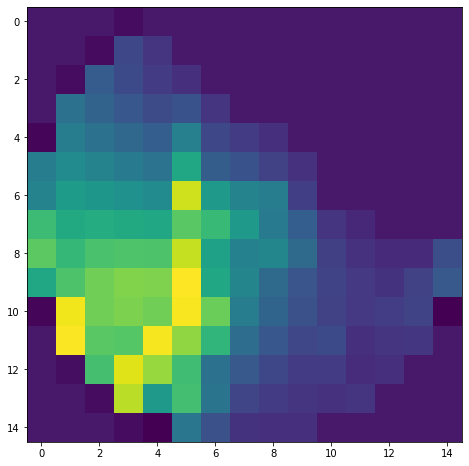

In [67]:
plt.imshow(activations[7])

In [42]:
reload(feat)
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

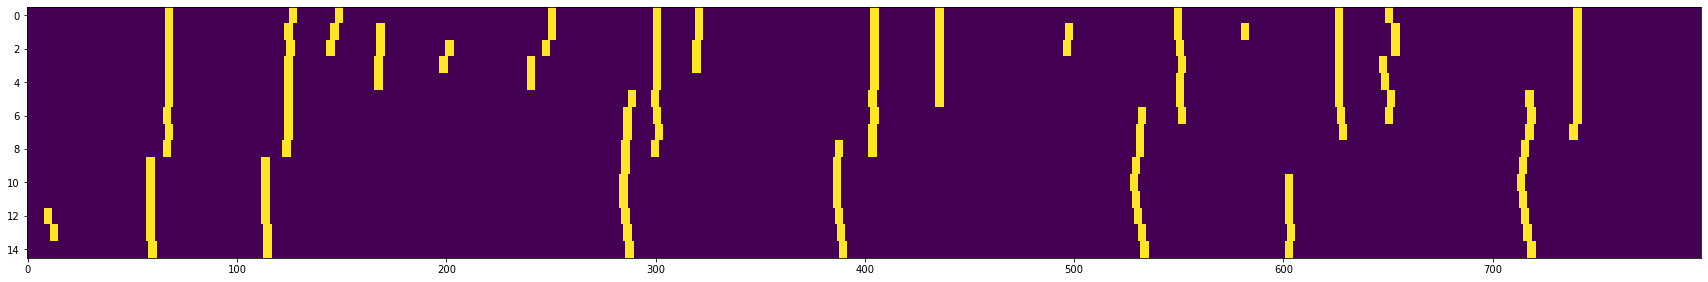

In [62]:
a,b = 3, 5
slice_peaks = feat.color_peaks_2d(fsub_stop_2d[1][5, :], patterns[5], fwhm_max = 20, area_min = 0, imin = 0,
                                 peakwidth = 2)
plt.imshow(slice_peaks, aspect=8, interpolation = 'none')

In [28]:
fsub_stop_2d[1][5, 3:5][1][0]

{'curve 0': {'FWHM': 6.115621155376653,
  'area': 255.61745757308748,
  'area_err': 1.3532148487807464e-06,
  'x0': 67.76790643950413},
 'curve 1': {'FWHM': 8.603445722883805,
  'area': -169.78699777238432,
  'area_err': 1.1241508681096698e-07,
  'x0': 60.8170955669961}}

In [58]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

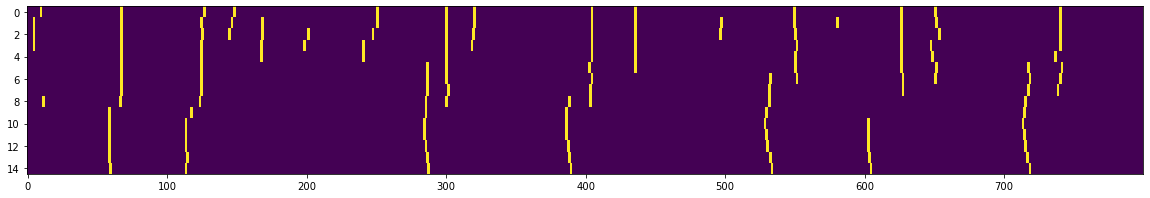

In [442]:
slice_peaks = feat.color_peaks_2d(fsub_stop_2d_2[1][5, :], patterns[5], fwhm_max = 20, area_min = 0, imin = 0,
                                 peakwidth = 1)
plt.imshow(slice_peaks, aspect=8, interpolation = 'none')

In [40]:
# def color_peaks_3d(patterns, peakparams, mask_zero = True, **kwargs):
#     """
#     Given peak fit parameters, return an array of the same shape as patterns with peak regions
#     set to 1.
#     """
#     res = np.array([feat.color_peaks_2d(params_slice, patterns_slice)
#                      for patterns_slice, params_slice in zip(patterns, peakparams)])
#     if mask_zero:
#         mask = (patterns.sum(axis = len(patterns.shape) - 1)) != 0
#         res *= mask[..., None]
#     return res

In [317]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [47]:
mask = (patterns.sum(axis = len(patterns.shape) - 1)) != 0
peakmask3d = feat.color_peaks_3d(fsub_stop_2d[1], fast_q)

In [156]:
# peakmask3d = color_peaks_3d(fast_q, fsub_stop_2d_3[1])

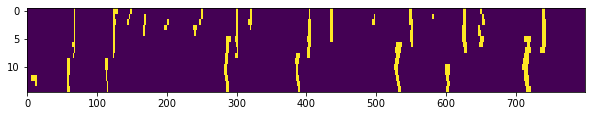

In [52]:
plt.imshow(peak_slices[5], aspect=8, interpolation = 'none')

In [10]:
def overlay_mask(img, mask, **kwargs):
    grayscale = 1 - mask
    alpha = mask
    rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
    plt.imshow(np.log(1 + img), cmap = 'jet', **kwargs)
    plt.imshow(rgb_img, cmap = 'Greys', **kwargs)

In [85]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

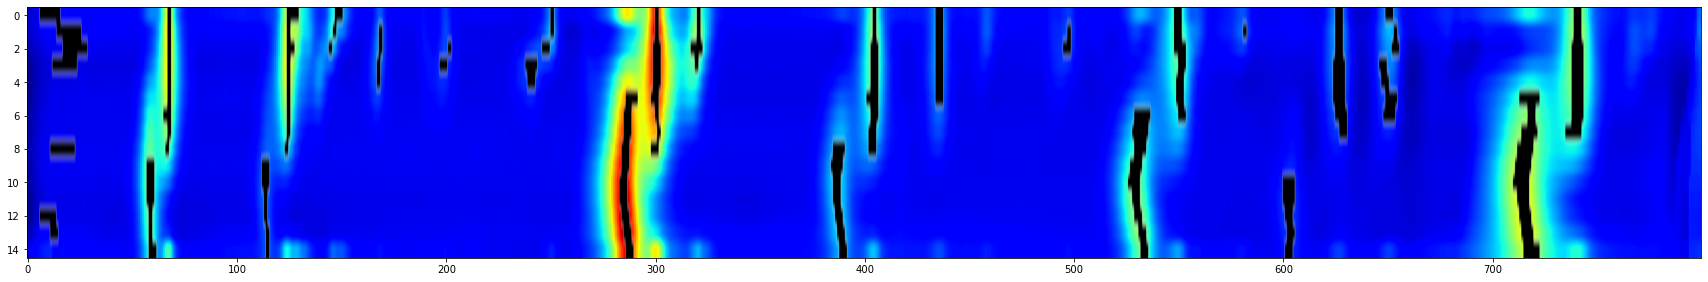

In [106]:
peak_slices = [feat.color_peaks_2d(fsub_stop_2d[1][i, :], patterns[i], fwhm_max = 80, imin = 0,
                                  peakwidth = 'auto')
              for i in range(patterns.shape[0])]

plt.rcParams["figure.figsize"]=(30, 30)
overlay_mask(fast_q[5], peak_slices[5], aspect = 8)

In [74]:
def plot_slices(callback, *args, N = 15, **kwargs):
    a, b = N, 1
    for i in range(N):
        plt.subplot(a, b, i + 1)
        plt.title('slice number {}'.format(i + 1), loc = 'right')
        callback(*(arg[i] for arg in args), **kwargs)
#        plt.imshow(np.log(1 + arr3d[:, i]), cmap = 'jet', interpolation = 'none')

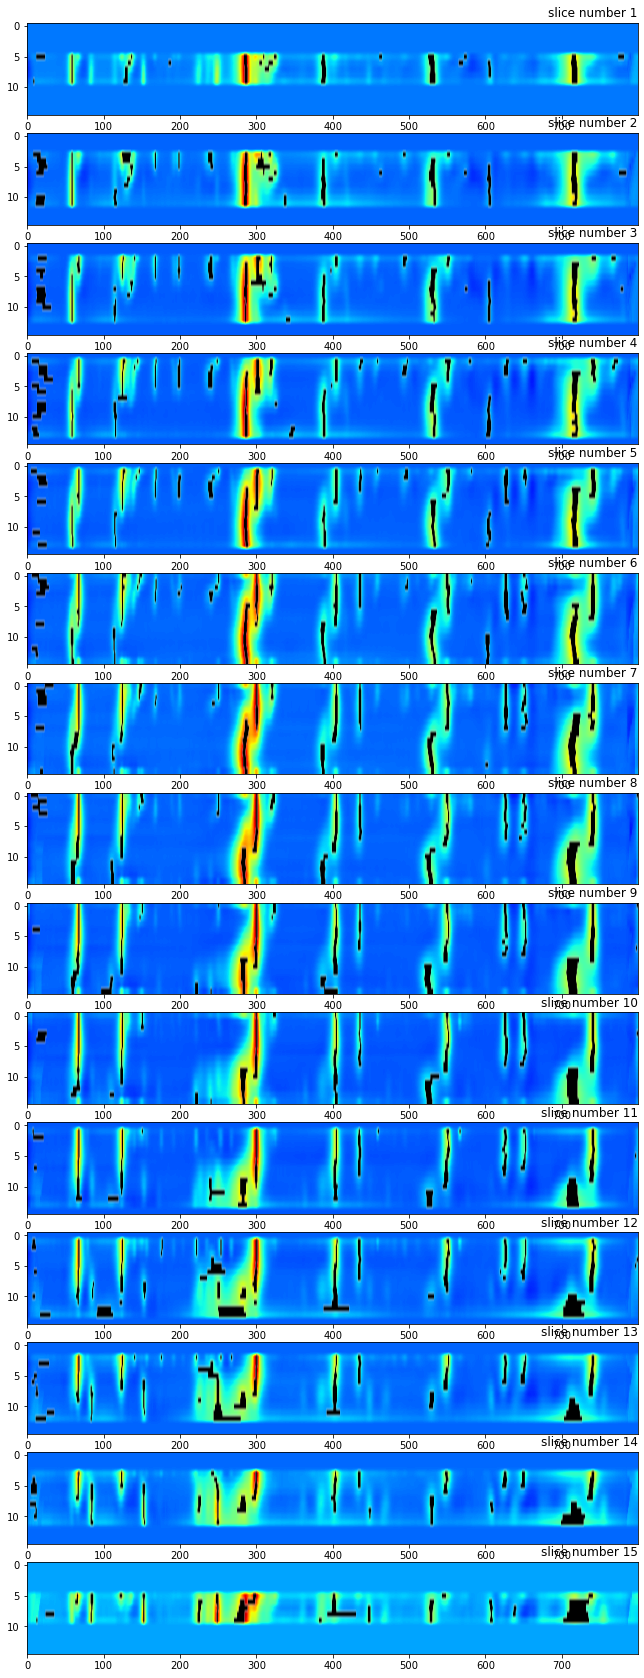

In [107]:
plot_slices(overlay_mask, fast_q * mask[..., None], peak_slices, aspect = 8, vmin = -1)#, vmax = np.log10(1 + fast_q.max()))

### TODO ask why number of peaks found depends on the intensity scale

In [37]:
patterns_pp = fast_q

In [11]:
from xrdc import visualization as vis

In [126]:
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

In [12]:
plot, volume = vis.heatmap3d(fast_q, interpolation = False);

Output()

In [101]:
import pathos

ModuleNotFoundError: No module named 'pathos'

> <ipython-input-101-93675a8f1721>(1)<module>()
----> 1 import pathos

ipdb> c


In [100]:
plot, volume = vis.heatmap3d(vfeats, interpolation = False, opacity_function = opacity_func,
                            color_range = color_range, scale = False, auto_color = False);

Output()

In [99]:
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

In [94]:
# # create opacity func
# opacity_func = np.zeros((256, 2), dtype=np.float32)
# opacity_func[:, 0] = tf.alpha.x /  max(tf.alpha.x) # rescale back between 0.0 and 1.0
# opacity_func[:, 1] = np.linspace(0, 1, 256)

vals = np.unique(vfeats.ravel())
vals.sort()
opacity_func = np.ones((len(vals), 2), dtype = np.float32)
opacity_func[:, 0] = vals
color_range = (np.min(vfeats), np.max(vfeats))

In [83]:
vfeats = (mask[..., None] * rmap(labeled))
volume.volume = vfeats

/Users/ollie/anaconda3/lib/python3.7/site-packages/k3d/objects.py:1175: UserWarning: wrong dtype: float64 ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


In [98]:
volume.volume = np.log(1 + 10 * fast_q / fast_q.max())

In [167]:
volume.volume = peakmask3d

In [363]:
%pdb

Automatic pdb calling has been turned ON


In [410]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [ ]:
mark

-4.163316680529025


(0.4323492203716807, 0.3893842895674234)

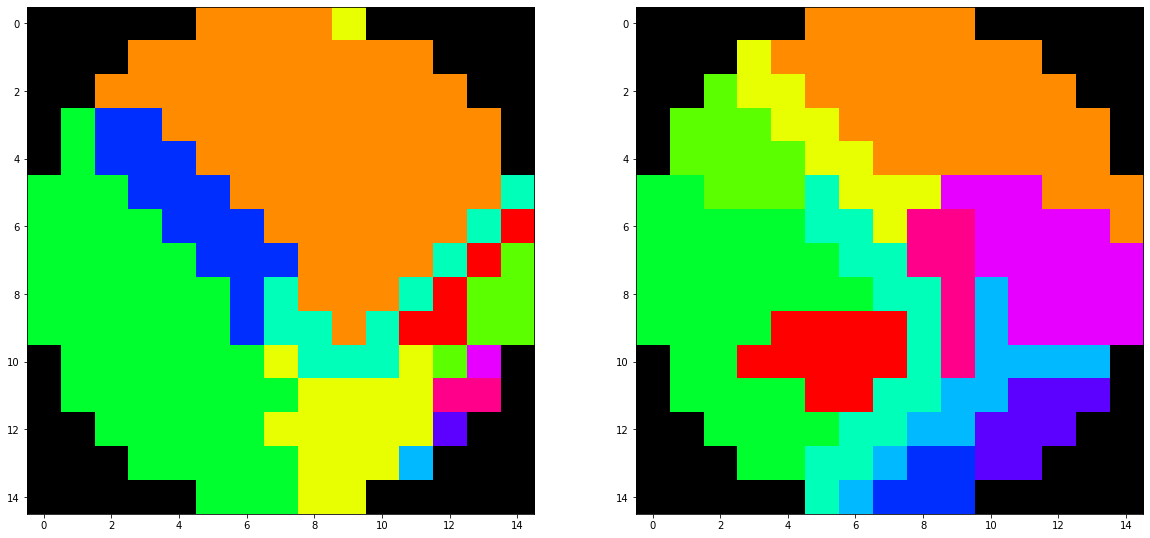

In [433]:
if debug:
    clust, sorter, clust_cms = feat.do_clust(patterns.T, nclust, ctype = 'agglom', linkage = 'average',
                                        affinity = 'cosine')
else:
    clust, sorter, clust_cms = feat.do_clust(fast_q_flat, activations[:, mask], nclust, ctype = 'agglom', linkage='average',
                                        affinity='cosine')


plt.subplot(1, 2, 1)
plot_clusters_grid(coords, clust, nclust)


plt.subplot(1, 2, 2)
plot_clusters_grid(get_coords(dgrid), y, 11)

# ax = fig.add_subplot(1,end-start,i-start+1)
# ax.imshow(cg)
# ax.invert_yaxis()
# ax.title.set_text(i)
# ax.axis("off")
# fig.show()

from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as rand

ami(y, clust), rand(y, clust)

In [424]:
activations.shape

(23, 15, 15)

In [409]:
patterns.shape

(15, 15, 800)

In [405]:
activations_n

(15, 15)

In [19]:
axis = 3
activations = np.log(1 + (feature_masks * patterns).sum(axis = axis))
#activations = (feature_masks * patterns).sum(axis = axis)
scale = np.mean(activations, axis = (1, 2))
# activations_n1 = activations / scale[:, None, None]
activations_n1 = feat.norm(activations)

mask = (patterns.sum(axis = 2) != 0)
patterns = patterns[mask]


/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py:136: RuntimeWarning: invalid value encountered in true_divide
  return ((arr - arr.mean(axis = axis)) / arr.std(axis = axis))


NameError: name 'dgrid' is not defined

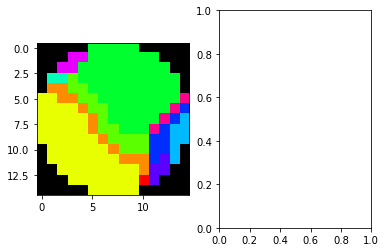

In [26]:
if debug:
    clust, sorter, clust_cms = feat.do_clust(patterns.T, nclust, ctype = 'agglom', linkage = 'average',
                                        affinity = 'cosine')
else:
    clust, sorter, clust_cms = feat.do_clust(patterns, activations[:, mask], nclust, ctype = 'agglom', linkage='average',
                                        affinity='cosine')


plt.subplot(1, 2, 1)
d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), clust, nclust)


plt.subplot(1, 2, 2)
d3d.plot_clusters_grid(d3d.get_coords(dgrid), y, 11)

# ax = fig.add_subplot(1,end-start,i-start+1)
# ax.imshow(cg)
# ax.invert_yaxis()
# ax.title.set_text(i)
# ax.axis("off")
# fig.show()

from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as rand

ami(y, clust), rand(y, clust)

In [29]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .2, threshold = 50)

In [30]:
patterns.shape, m3d_agglom.shape

((177, 400), (15, 15, 400))

In [ ]:
max_ind = argrelextrema(orig, np.greater, axis = axis)
#     max_ind_2 = argrelextrema(orig, np.greater, axis = 0)
#     max_ind = np.hstack((max_ind[0], max_ind_2[0])), np.hstack((max_ind[1], max_ind_2[1]))

edges = np.zeros_like(orig)
edges[max_ind] = 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


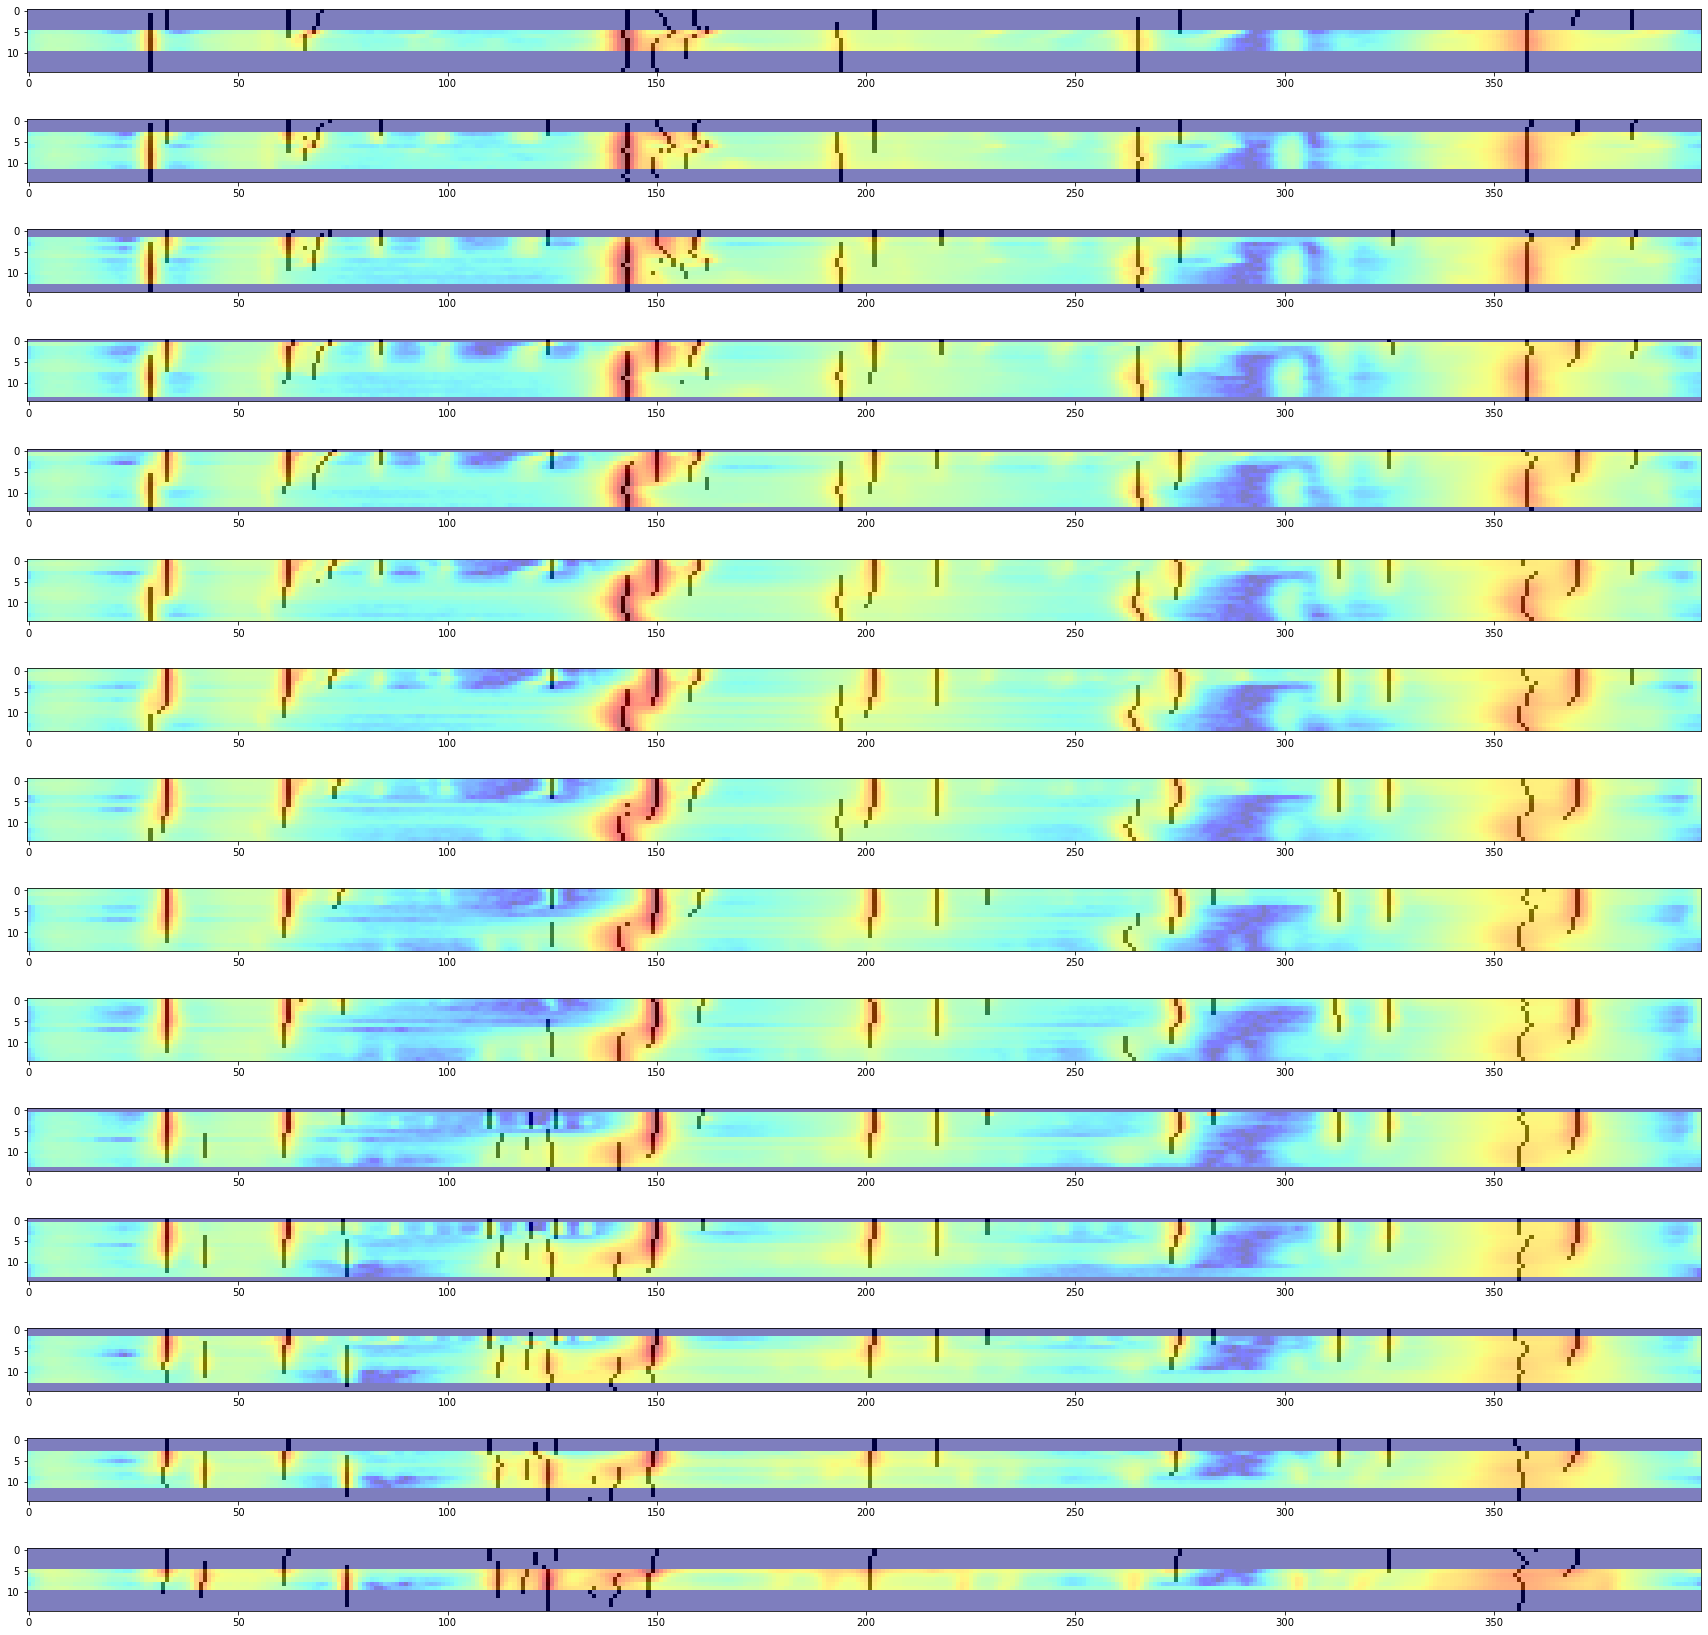

In [467]:
plt.rcParams["figure.figsize"]=(30, 30)

a, b = dim, 1

def plot_cuts(m3d_agglom, axis = 0, cmap = 'jet', **kwargs):
    for i in range(15):
        plt.subplot(a, b, i + 1)
        if axis == 0:
            plt.imshow(np.log(1 + m3d_agglom[i, :]), cmap = cmap, **kwargs)
        if axis == 1:
            plt.imshow(np.log(1 + m3d_agglom[:, i]), cmap = cmap, **kwargs)
plot_cuts(m3d_agglom)
plot_cuts(ridges, alpha = .5, cmap = 'Greys')

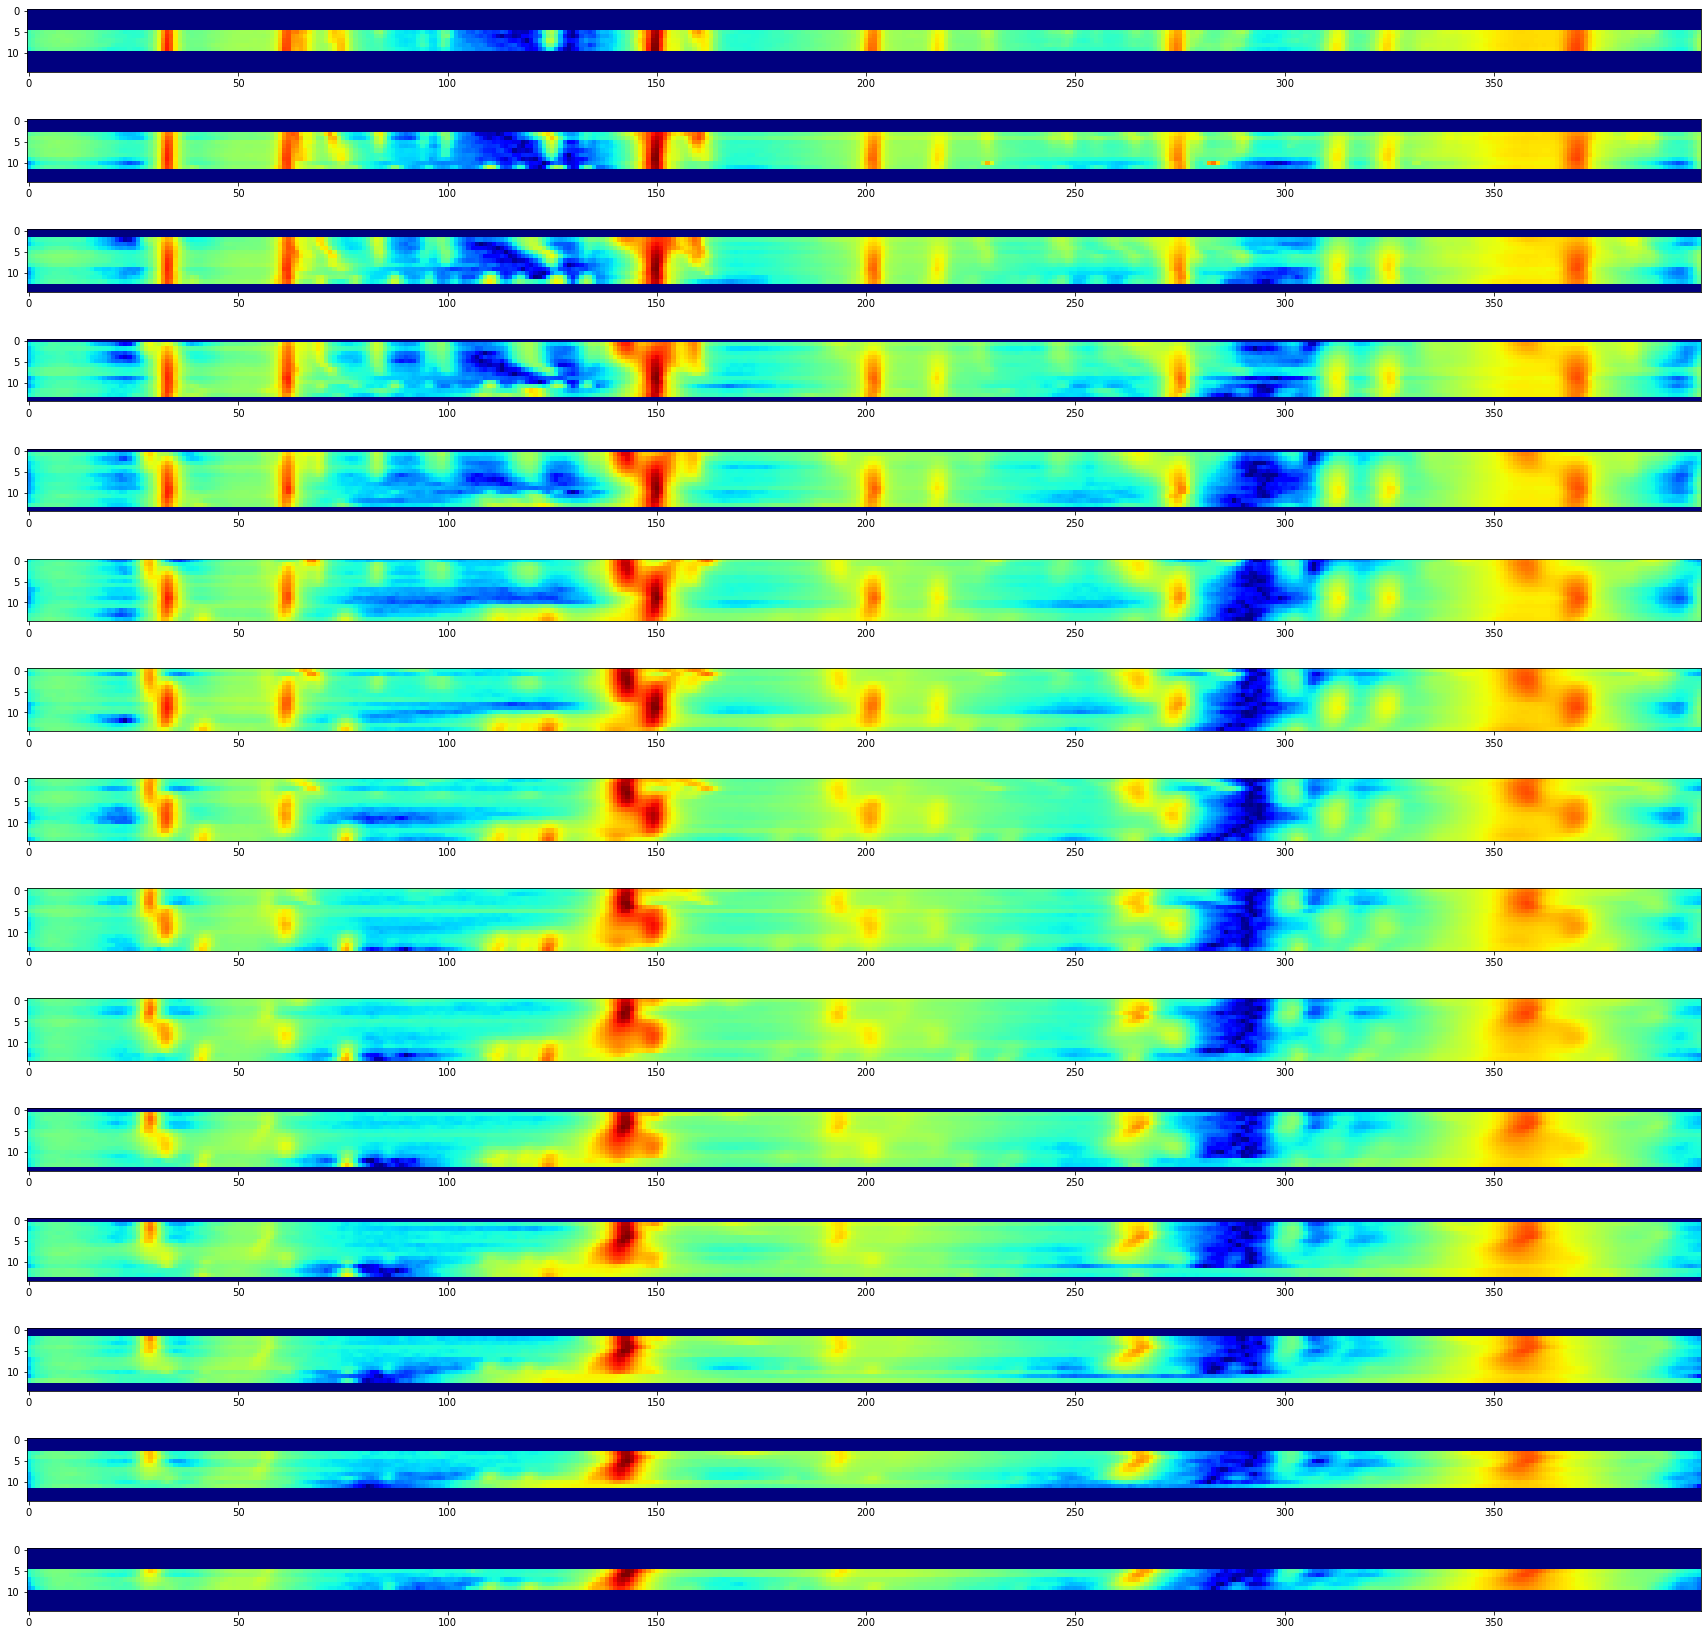

In [470]:
for i in range(15):
    plt.subplot(a, b, i + 1)
    plt.imshow(np.log(1 + m3d_agglom[:, i]), cmap = 'jet', interpolation = 'none')
# plot_cuts(ridges, alpha = .5, cmap = 'Greys')

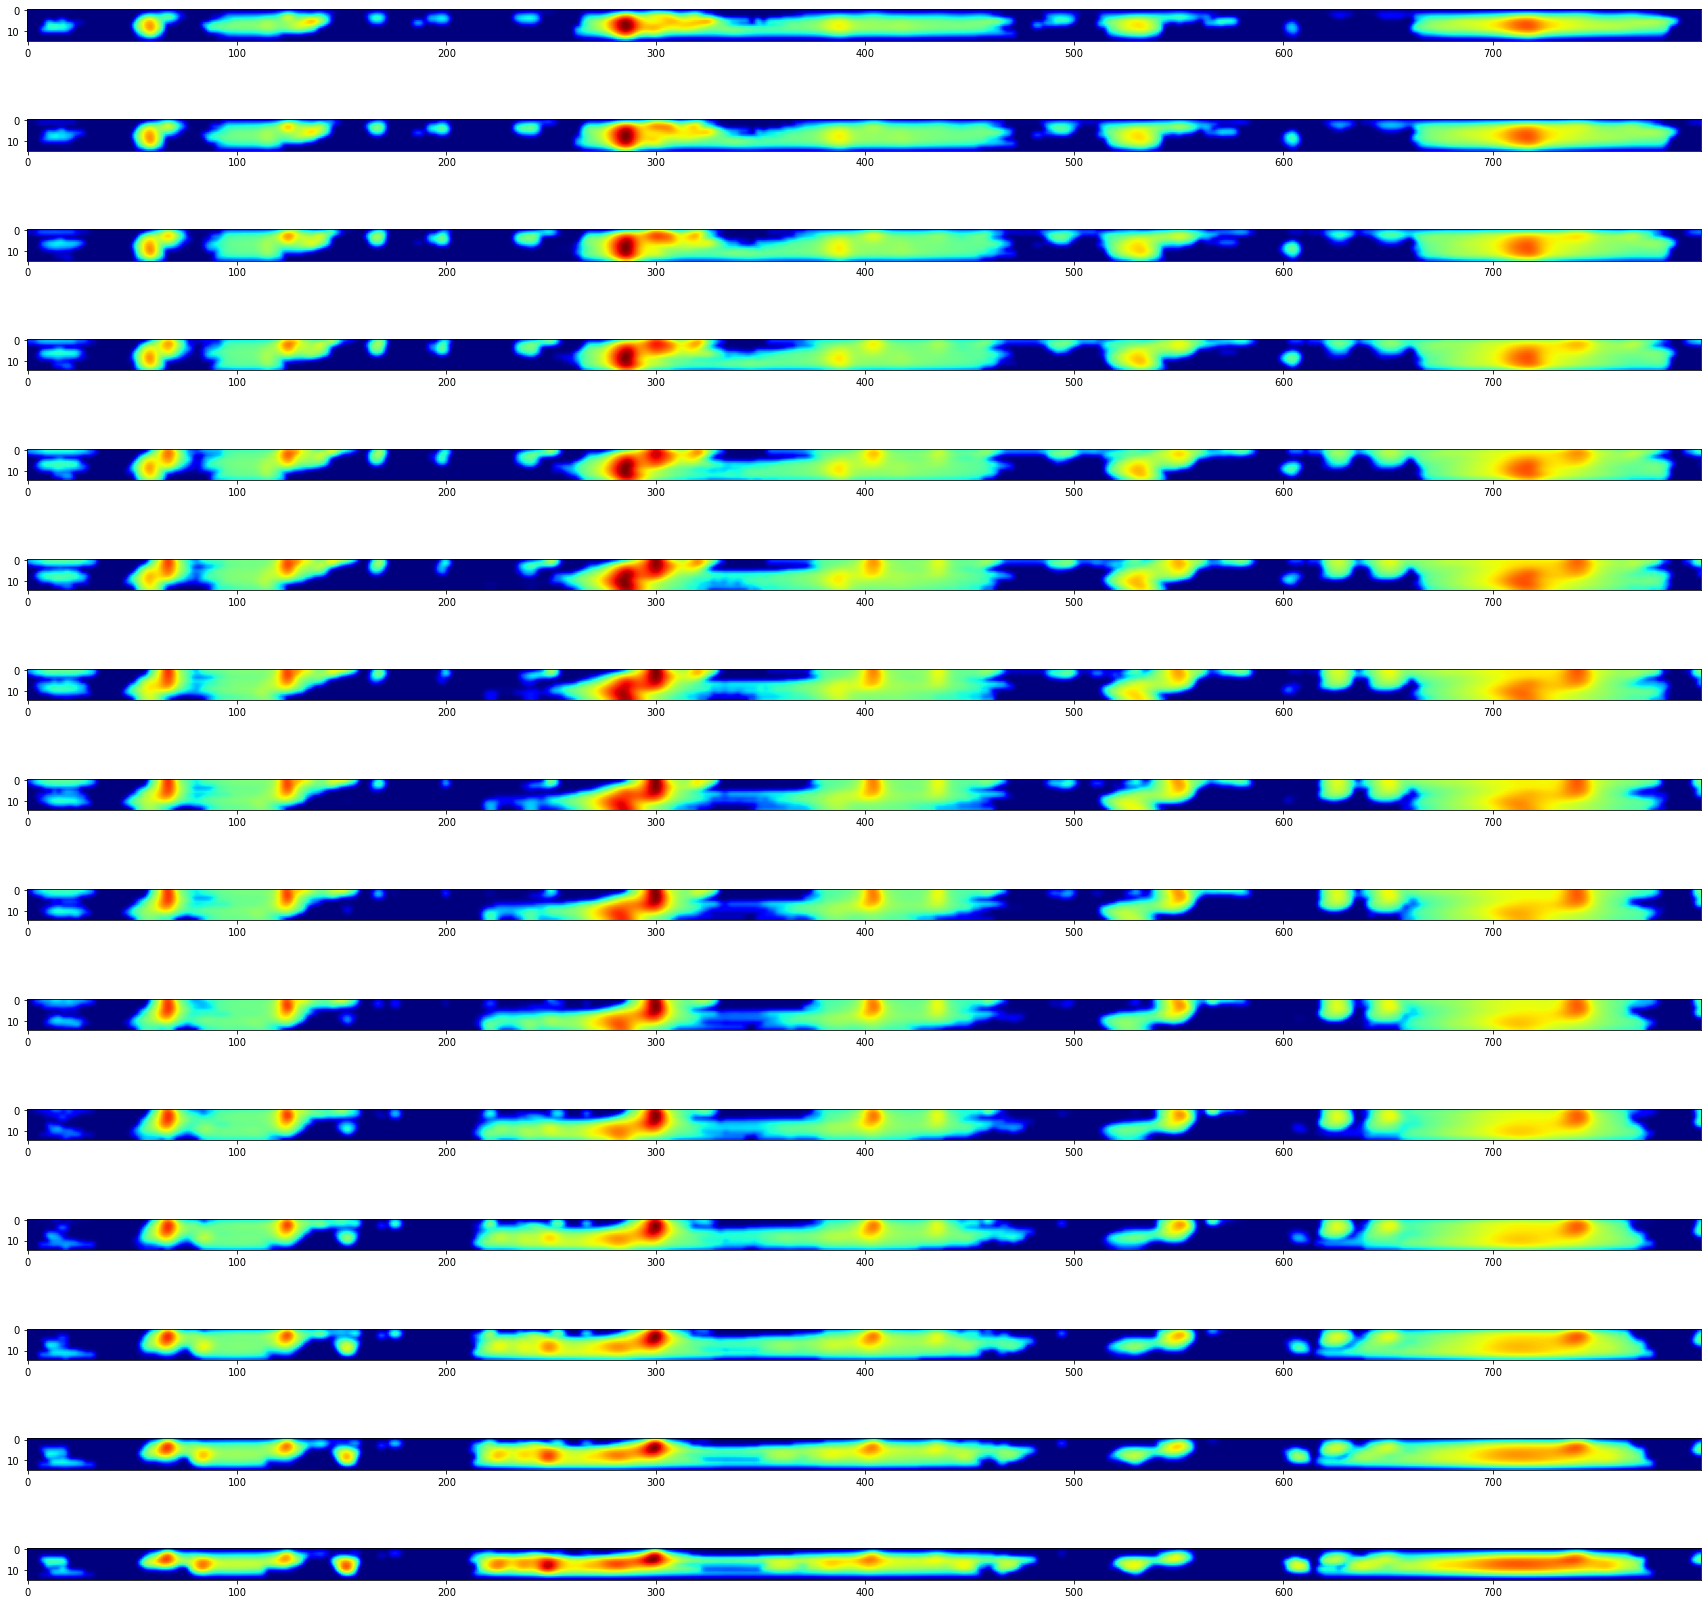

In [114]:
plot_cuts(preprocess(m3d, smooth = 1))

In [131]:
# m3d_agglom = m3d_agglom[:, :14]

In [210]:
m3d_agglom.shape

(15, 15, 400)

In [246]:
ridges.max()

1.0

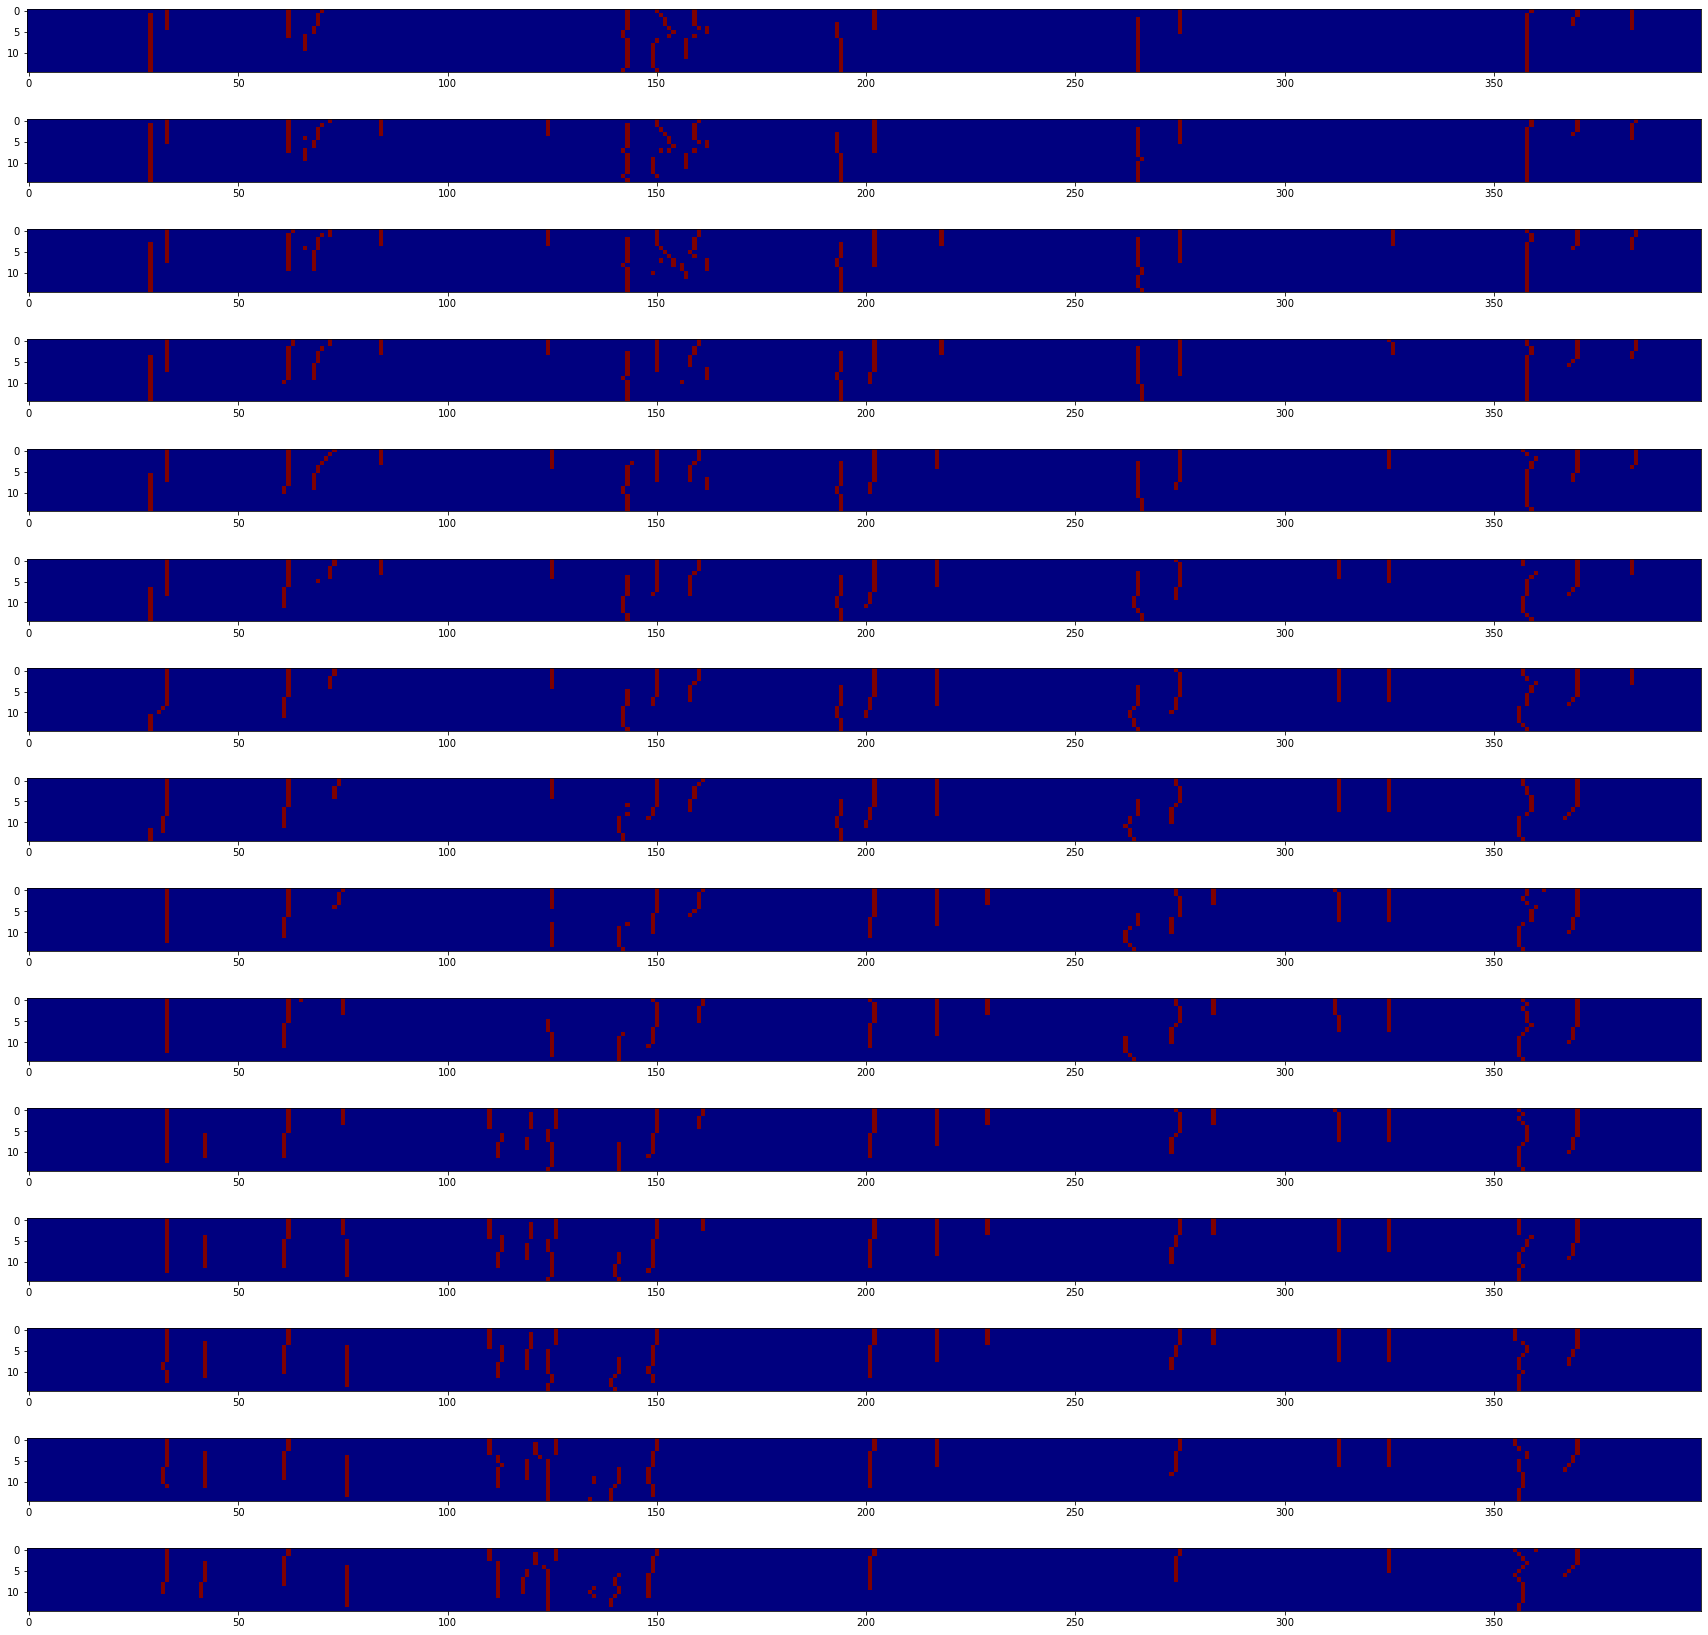

In [616]:
plot_cuts(ridges)

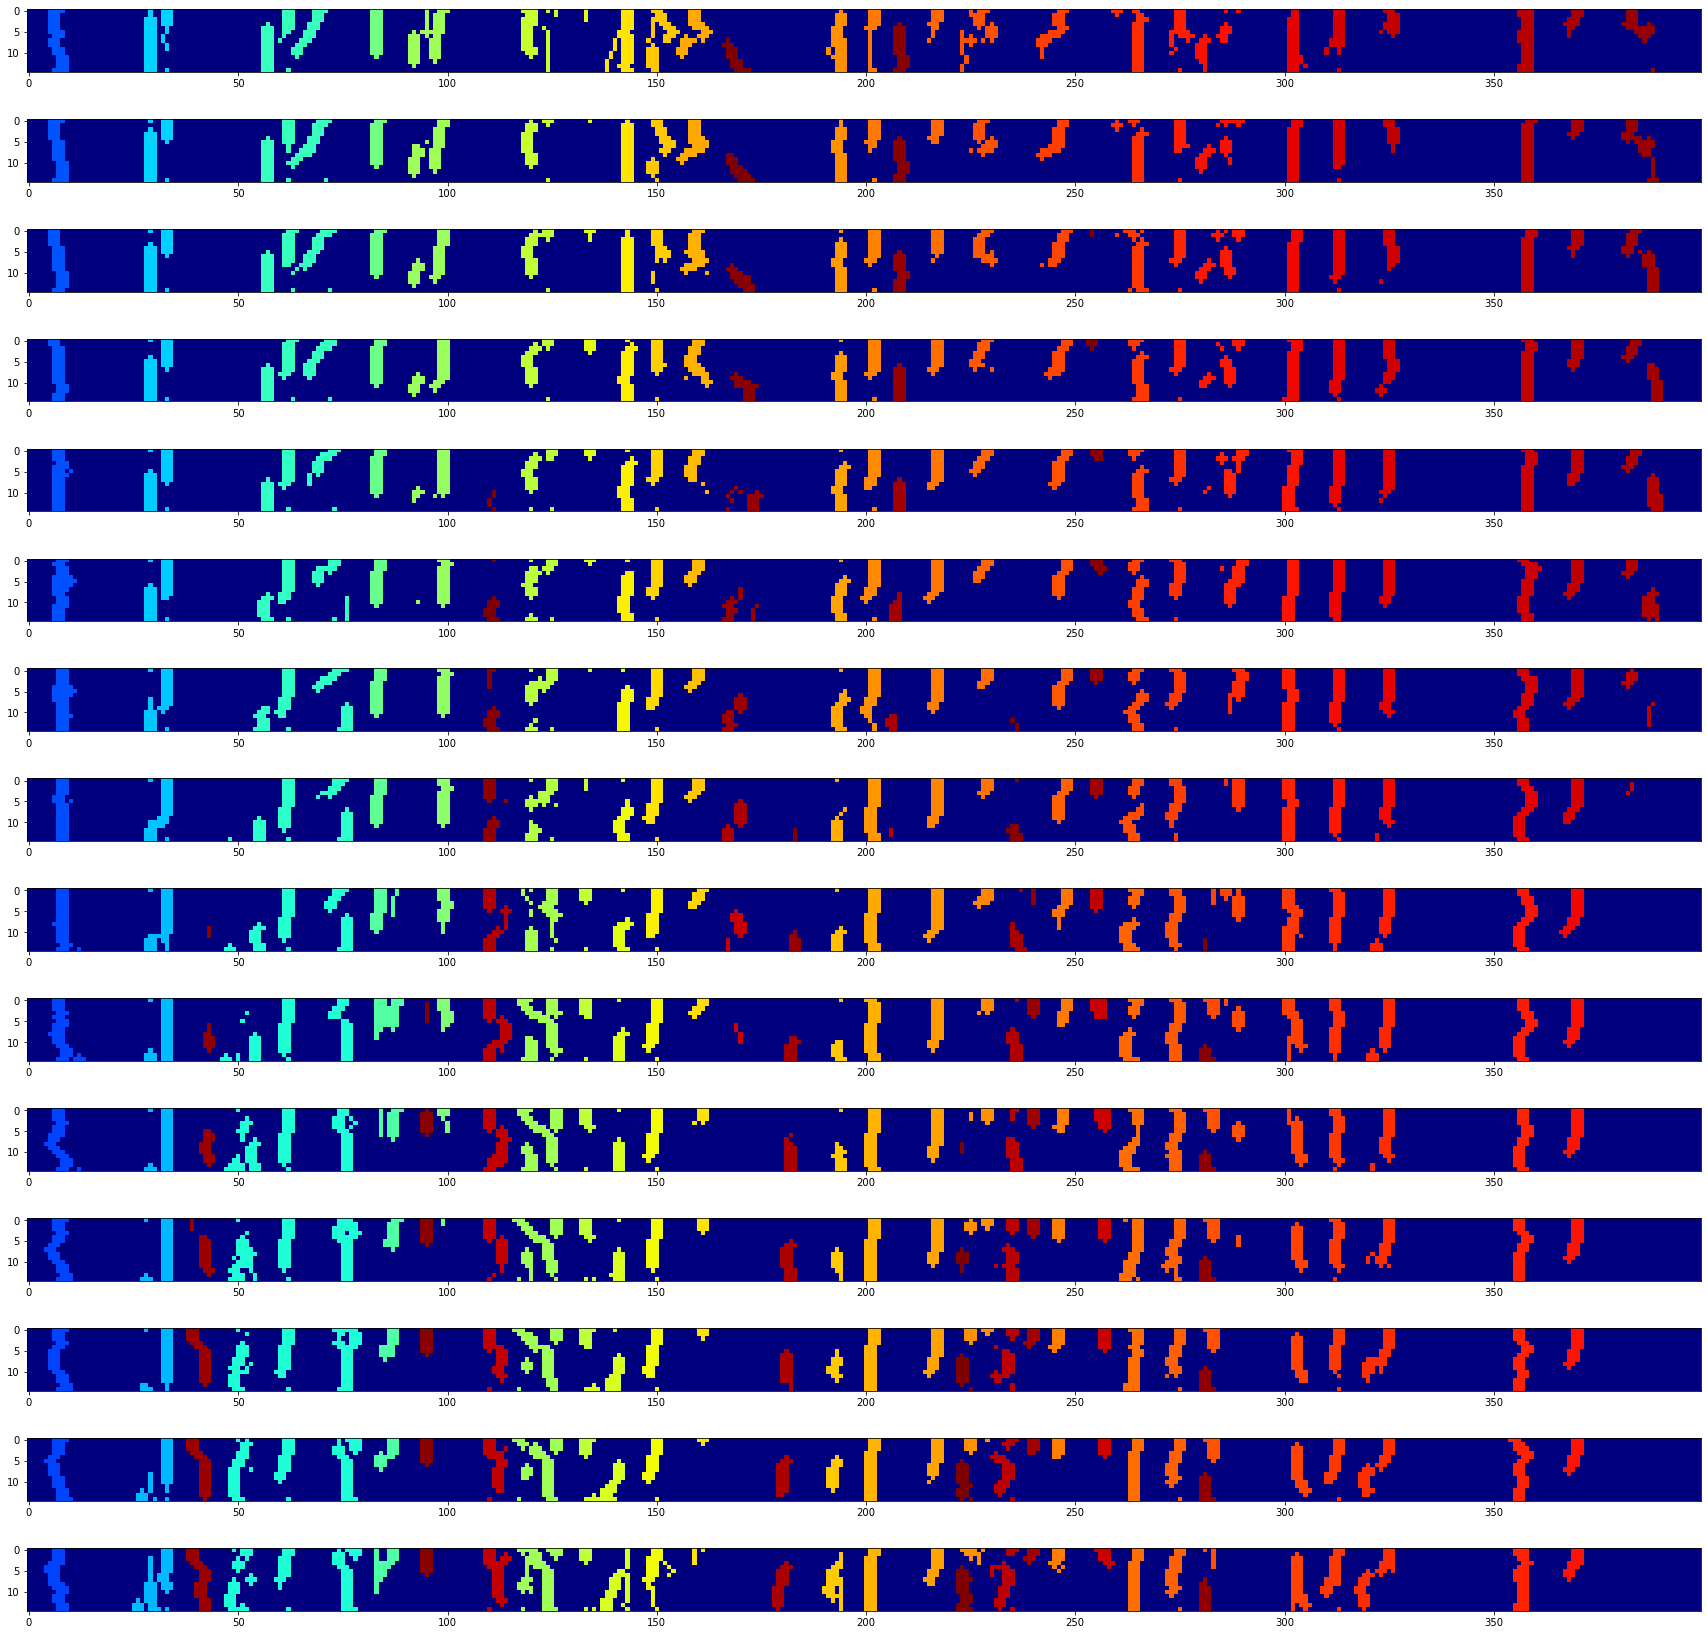

In [655]:
plot_cuts(labeled)

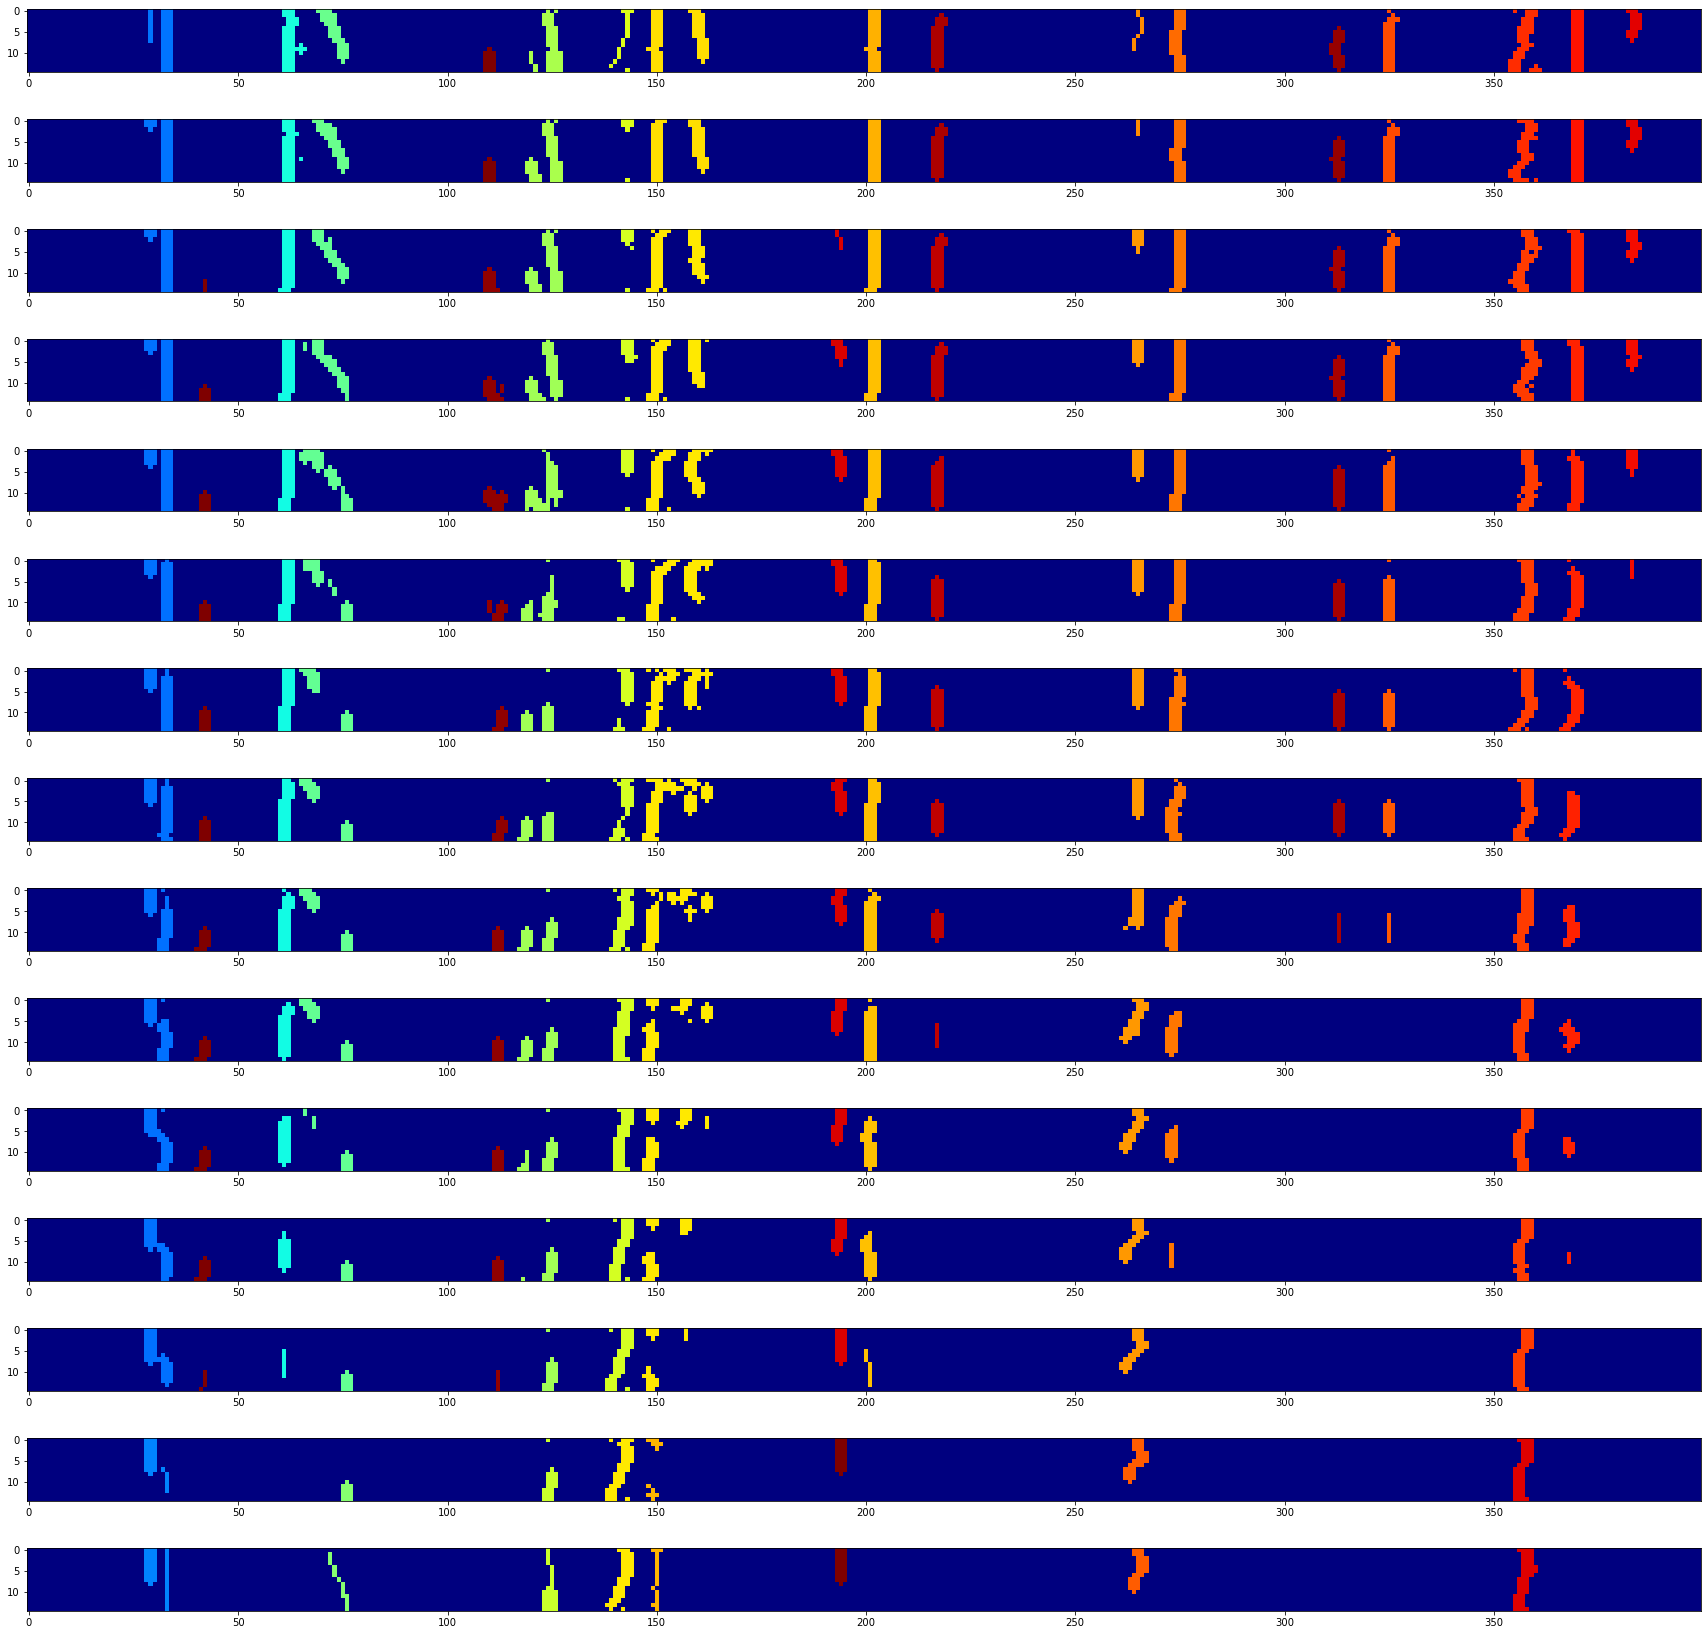

In [618]:
plot_cuts(labeled, axis = 1)

### Test cases for the visualization:

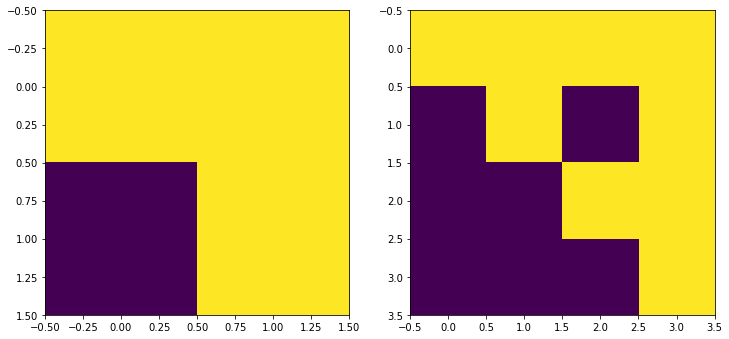

In [1726]:
ta = np.ones((3, 2, 2))

ta[:, 1, 0] = 0

plt.rcParams["figure.figsize"]=(12, 12)
a, b = 1, 2

plt.subplot(a, b, 1)
plt.imshow(ta.sum(axis = 0))

plt.subplot(a, b, 2)
ttmp = np.einsum("kij, klm->ijlm", ta, ta)
plt.imshow((gridstack(ttmp)))

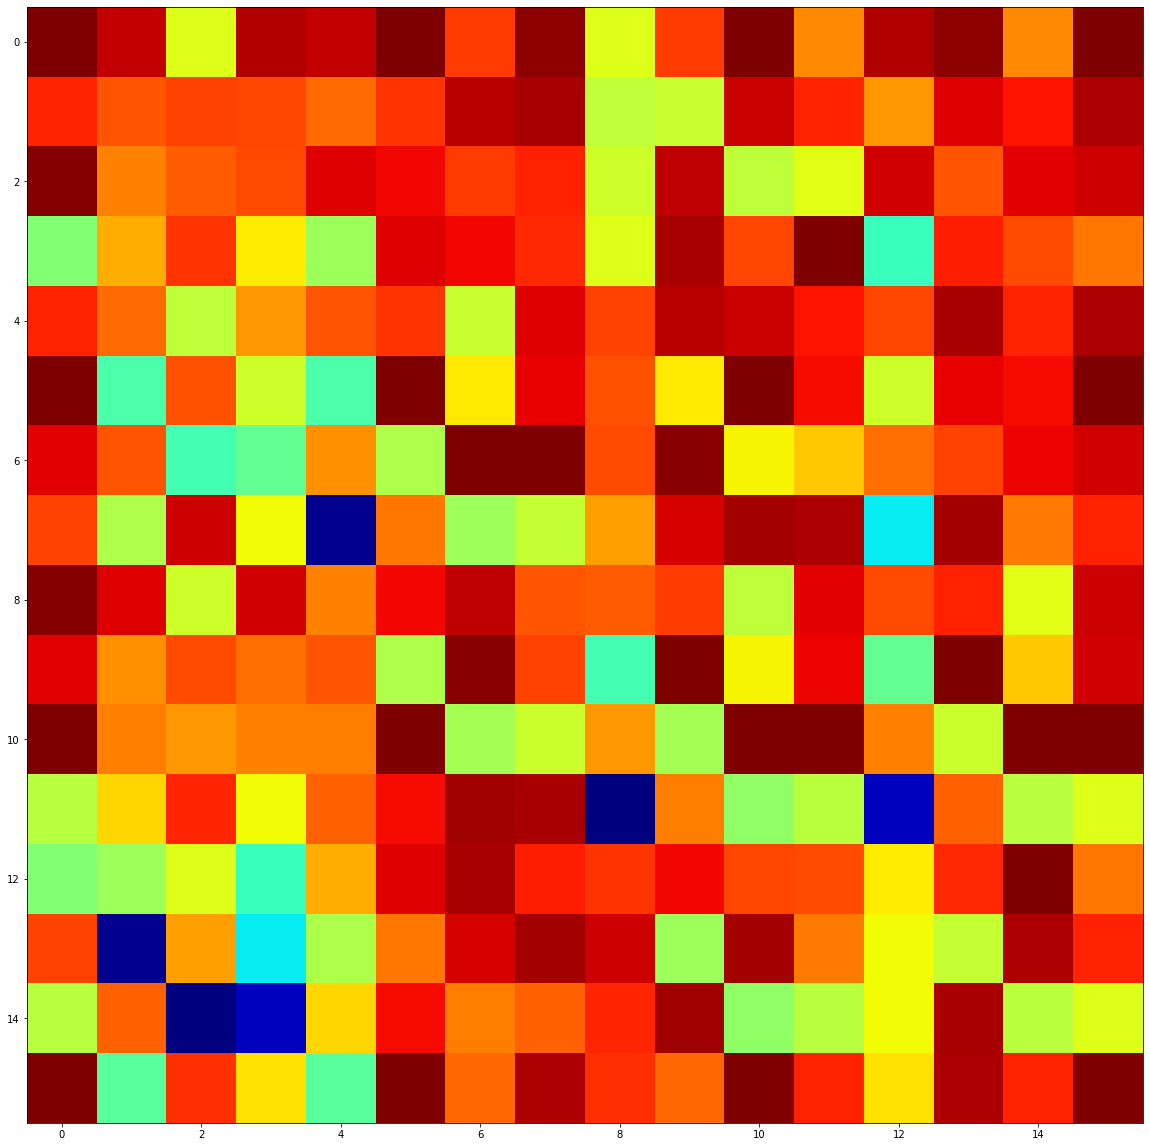

In [1841]:
ta = np.random.rand(3, 4, 4)
ta[0, 3, 0] = 0
#ta[1, 3, 0] = 0
ta[2, 3, 0] = 0
ta[:, 2, 1] *= 10


scale = np.log(np.mean(ta, axis = (1, 2)))

activations_n1 = ta * 2 # / scale[:, None, None]
activations_n1[:, 0, 1] = 2
ttmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

norm = np.linalg.norm(activations_n1, axis = 0)

norm4d = np.einsum("ij, kl->ijkl", norm, norm)

tmp_csim = ttmp / (norm4d + 1e-10)

plt.imshow((gridstack(tmp_csim)), cmap = 'jet')

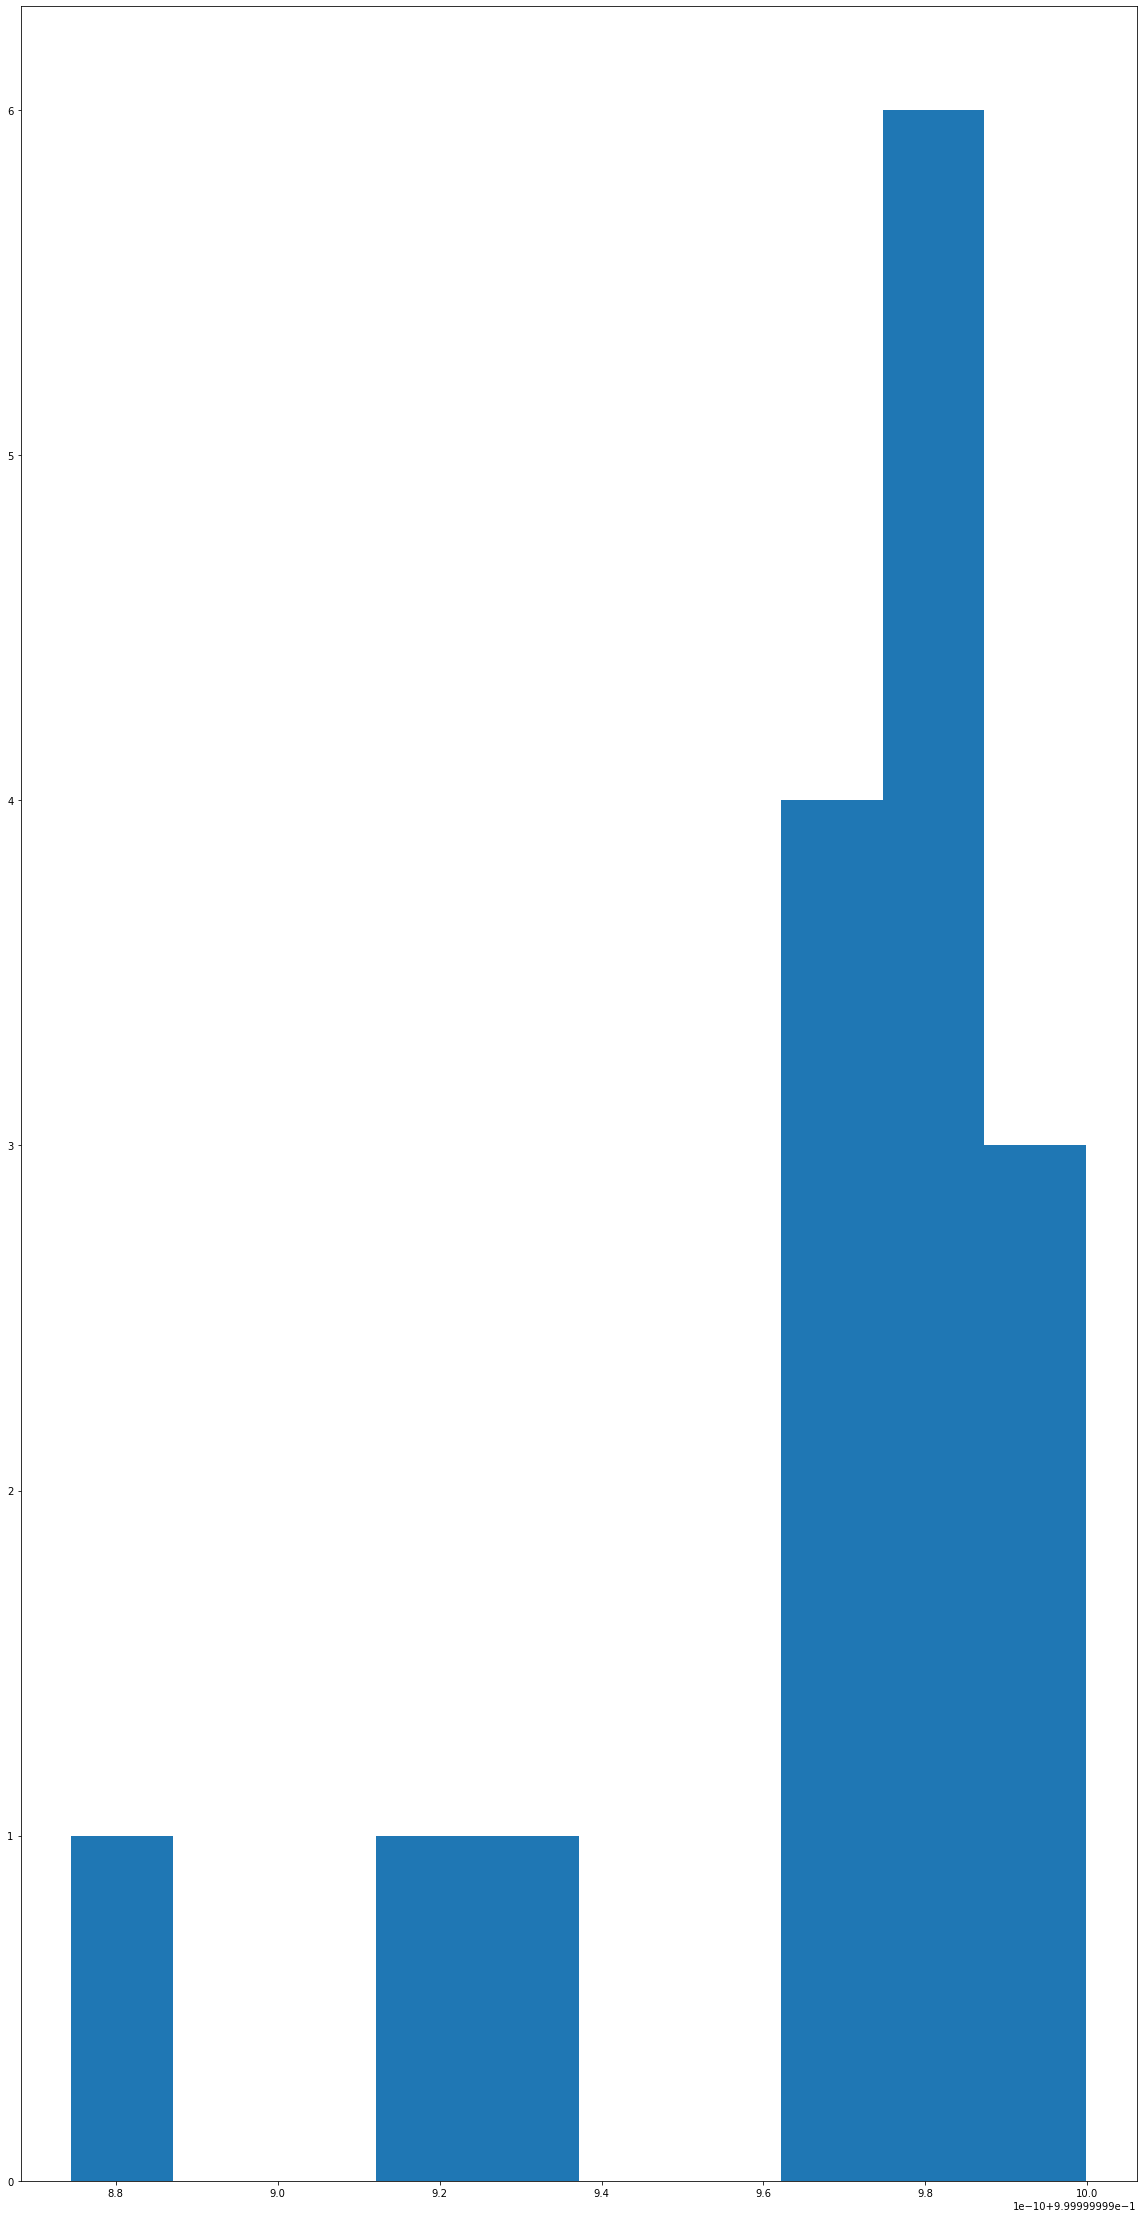

In [1842]:
plt.hist(tmp_csim.max(axis = (0, 1)).ravel(), bins = 10);

In [226]:
%pdb

Automatic pdb calling has been turned ON


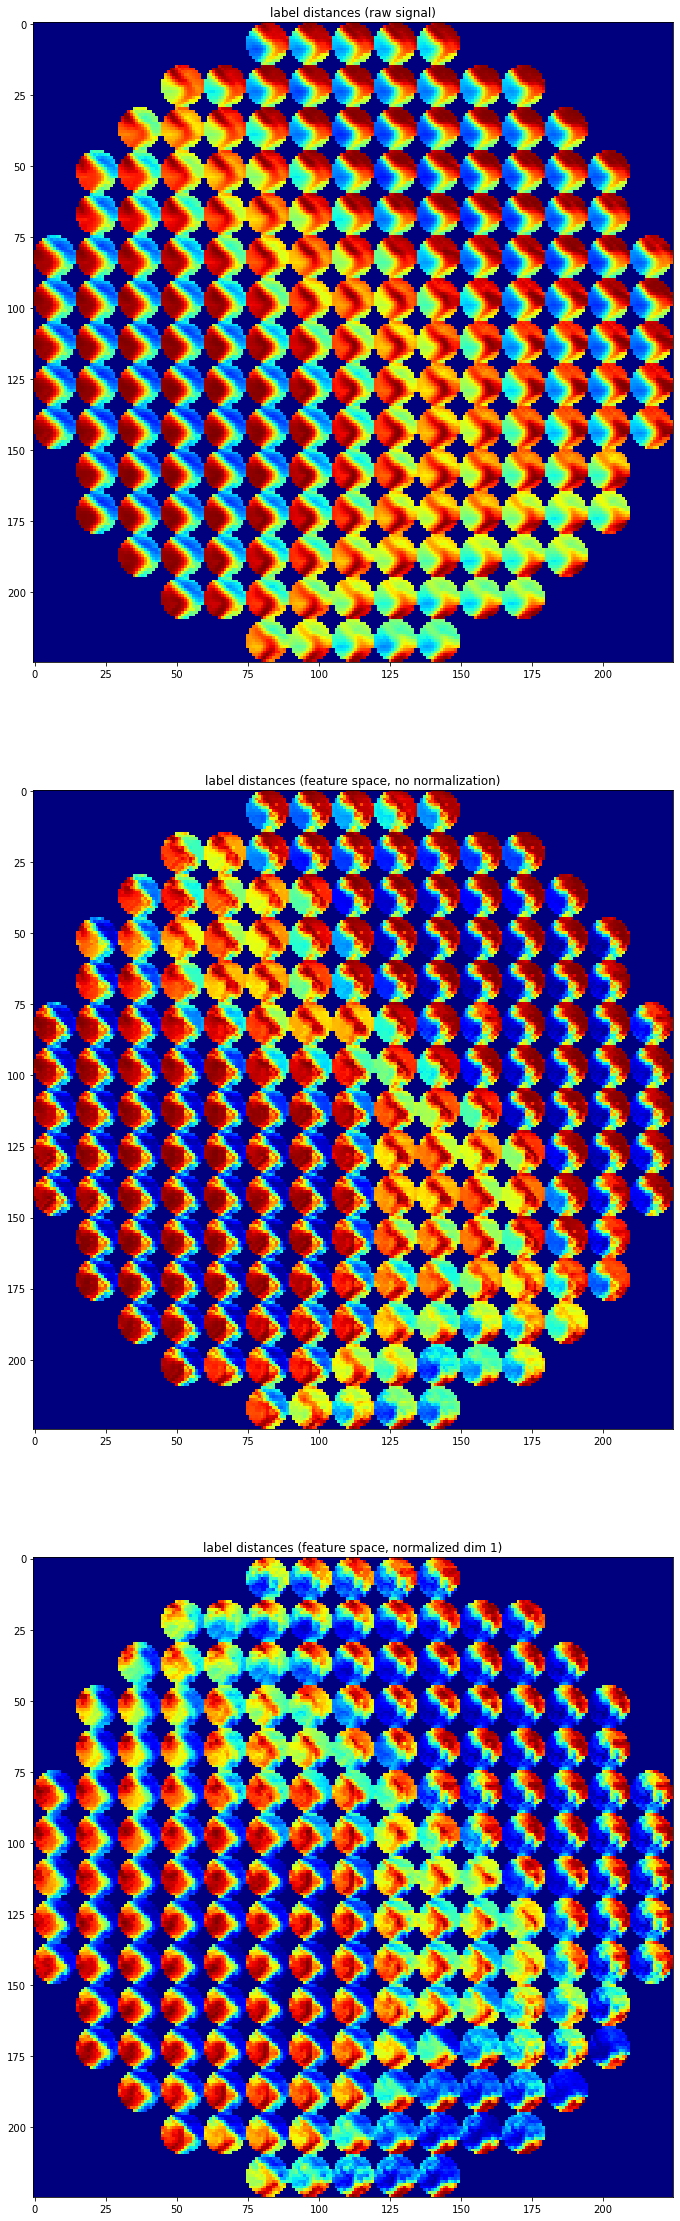

In [22]:
plt.rcParams["figure.figsize"]=(20, 40)

a, b, = 3, 1
similarity_plot_row(csim3d, "label", swap3d(patterns), activations, activations_n1, 
                        activations_n1_log = None, offset = 0, swapper = None,
                   plotter = lambda arr: simple_heatmap(gridstack(arr)))

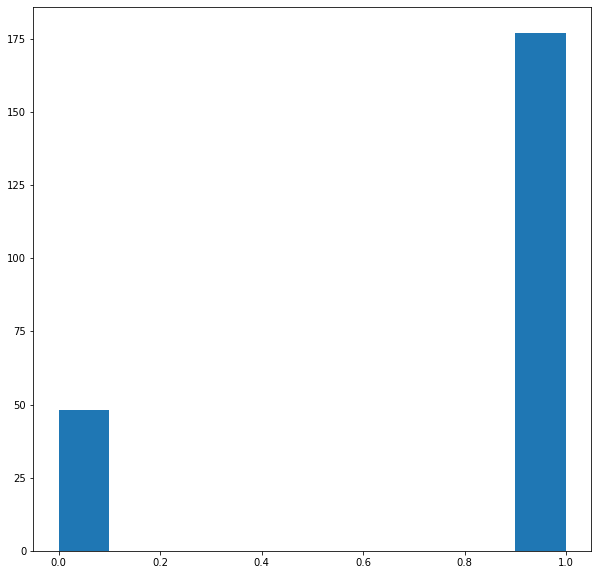

In [1789]:
plt.hist(tmp_csim.max(axis = (0, 1)).ravel());

### Compare to a wrong way of calculating the similarity matrix:

In [1675]:
csim2 = l2_pairs(activations.reshape(16, -1).T).T

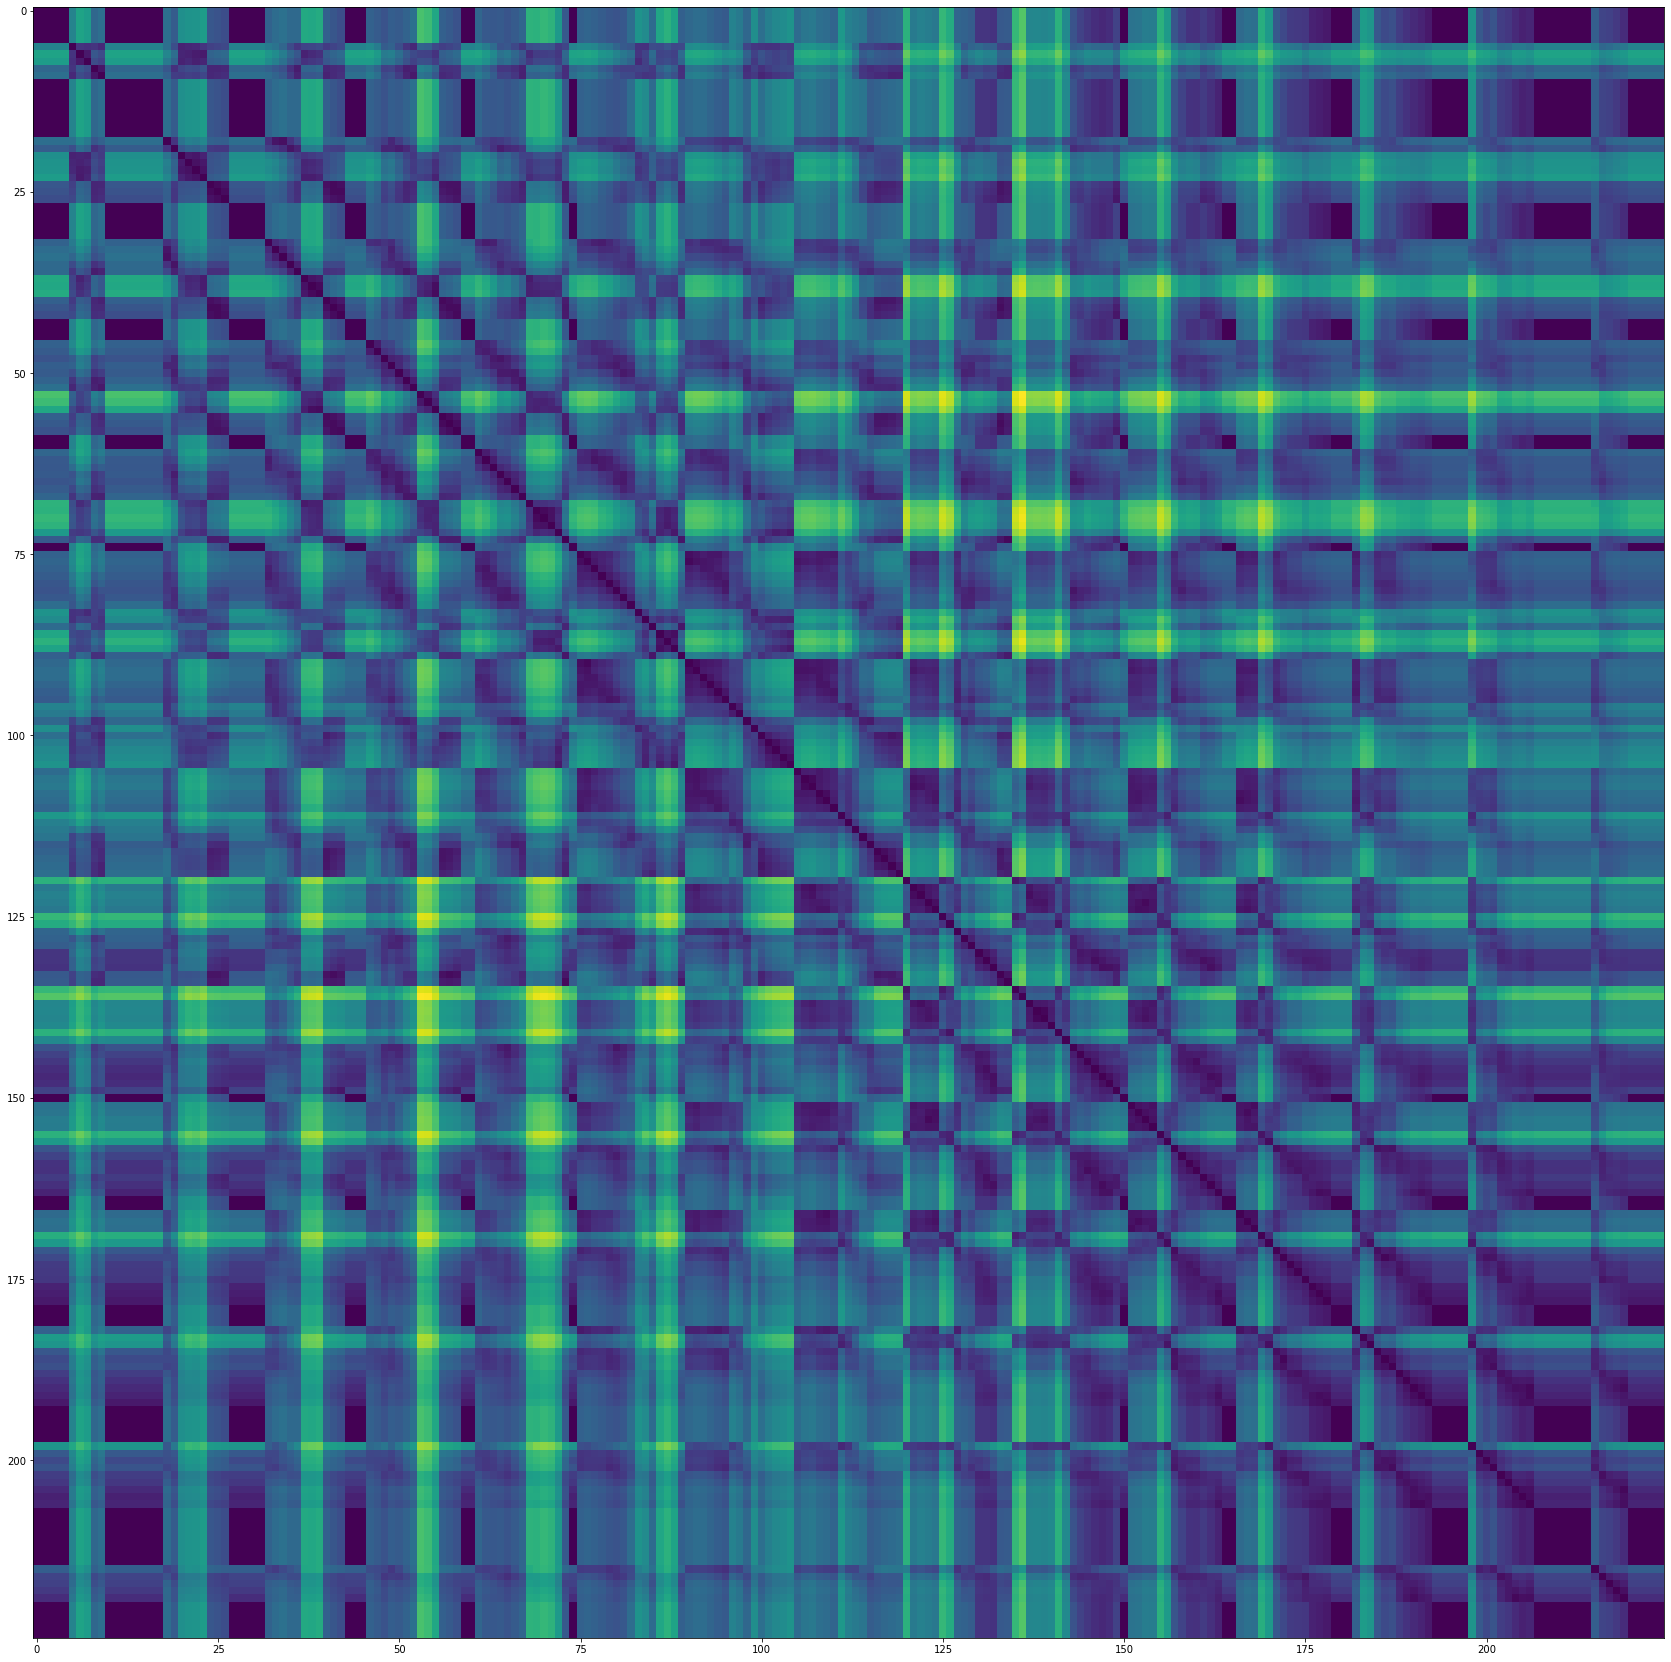

In [1677]:
plt.imshow(csim2)

In [397]:
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import scipy.cluster.vq as scv

In [514]:
arr=plt.imread('/Users/ollie/Downloads/Outlook-xrjjtowh (1).jpg') / 255

alpha = np.ones(arr.shape[:2] + (1,))

arr = np.dstack((arr, alpha))